# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Seed

In [6]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [7]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [78]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [79]:
df = preprocessing(df,
                   used=['cum_winner'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : cum_winner, wml


In [80]:
def normal_wml(df):
  print("'wml'이 양수면 1 & 음수면 0")
  print("Output : 'Preprocessed_Data' & 'WML'")
  print()

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0
  WML = df[['wml']]

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f'Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df, WML

In [81]:
dynmom, WML = normal_wml(df)

'wml'이 양수면 1 & 음수면 0
Output : 'Preprocessed_Data' & 'WML'

Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

In [82]:
def Roling_Windows(data, window_size, method, model, model_name, plot=True, plot_feature=True):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
    'TRAIN_START_DATE':[],
    'TRAIN_END_DATE':[],
    'TEST_DATE':[],
    'Actual_POS_WML':[],
    f'{model_name}_PRED_POS_WML':[],
    f'{model_name}_PROB_POS_WML':[]
  }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print(f'\n{model_name} Model의 Rolling {method} Window를 실행합니다\n')
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml'])
    y_test = test['pos_wml'] 

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)
    prob_test = MODEL.predict_proba(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])
    result_dict[f'{model_name}_PROB_POS_WML'].append(prob_test[0][-1])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 모델 성능 시각화
  if plot == True:
    plot_result(result, method, model_name)
  
  # 모델의 변수 중요도 시각화
  if plot_feature == True:
    plot_feature_importances(result, model_name)
    print()

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [83]:
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results {method} of the {model_name} model')
  
  plt.show()

In [84]:
def plot_feature_importances(data, model_name):

  data = data.drop(columns=['TRAIN_START_DATE', 'TRAIN_END_DATE', 'Actual_POS_WML',
                           f'{model_name}_PRED_POS_WML', f'{model_name}_PROB_POS_WML'])

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [85]:
def display_feature_importance(data, method):
       
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

In [86]:
def slice_feature_importance(data, num, method, model_name):

  if type(num) != bool:
    division = int(data.shape[0]/num)
    
    for i in range(num):

      if i == num-1:
        sliced_data = data.iloc[i*division:]

      else:
        sliced_data = data.iloc[i*division:(i+1)*division]

      start = sliced_data.index[0]
      end = sliced_data.index[-1]

      print()
      print('*'*50)
      print(f'\nDATE : {start} ~ {end}\n')
      print('*'*50)
      print()
      
      plot_result(sliced_data, method, model_name)
      plot_feature_importances(sliced_data, model_name)
  
  else:
    start = input('Start Date (ex: 20200131): ')
    end = input('Start Date (ex: 20221230): ')
    print('*'*50)
    print(f'\nDate : {start} ~ {end}\n')
    print('*'*50)
    print()

    sliced_data = data.loc[start:end]
    plot_result(sliced_data, method, model_name)
    plot_feature_importances(sliced_data)

In [87]:
def cumm_return_by_dynamic(data, wml, weight, A0_P1, A1_P0,  plot=True):

  start_index = data.index[0]
  wml = wml.loc[start_index:]

  df = pd.DataFrame(wml['wml'] * data[weight])
  df.columns = ['cum_return']
  df['cum_return'] = (1 + df.cum_return).cumprod() - 1 
  
  S = df['cum_return'].mean()/df['cum_return'].std()

  print('Sharpe Ratio : {:0.5f}\n'.format(S))

  print('최근 누적 수익률\n')
  latly_10 = df.sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = df.sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  TEST_WML = wml.copy()
  TEST_WML['wml'] = (1 + TEST_WML.wml).cumprod() - 1
  TEST_WML.columns = ['cum_return'] 

  if plot == True:

    plt.figure(figsize=(13, 6))
    sns.lineplot(data=df, x=df.index, y=df['cum_return'], label='With_ML')
    sns.lineplot(data=TEST_WML, x=TEST_WML.index, y=TEST_WML['cum_return'], label='Original')
    plt.xticks([df.index[i] for i in range(0,len(df.index), 12)])
    plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=5,
                    width=5)
    for i in A0_P1:
      plt.vlines(i, -80000, 0, color='pink', linewidth=0.4, alpha=1)

    for i in A1_P0:
      plt.vlines(i, 80000, 0, color='pink', linewidth=0.4, alpha=1)

    plt.legend(fontsize=10)
    plt.show() 

  return df

In [88]:
def What_Pred(data, WML, model_name):

  start_index = data.index[0]
  WML = WML.loc[start_index:]
  WML.index.name = 'TEST_DATE'

  Q1 = WML.quantile(0.25)
  Q3 = WML.quantile(0.75)
  IQR = Q3 - Q1

  Upper = Q3 + (1.5*IQR)
  Lower = Q1 - (1.5*IQR)

  print('\nIQR 기준 WML 이상치 (Maximum 미만) 개수\n')

  cond_U = (WML['wml']>Upper[0])  
  WML_U = WML.loc[cond_U]
  
  print(f'Number of Outlier by IQR (Maximum) : {WML_U.shape[0]}')
  print(f'Maximum by IQR : {Upper[0]}')
  print(f"Max Outlier : {WML_U['wml'].max()}")
  print(f"Min Outlier : {WML_U['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_1 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_1 = Result.loc[cond_1]
  print('\nACTUAL = PRED = 1\n')
  sns.boxplot(data=R_1, x='wml')
  plt.show()
  display(R_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  print('\nIQR 기준 WML 이상치 (Minimum 미만) 개수\n')

  cond_L = (WML['wml']<Lower[0])  
  WML_L = WML.loc[cond_L]
  
  print(f'Number of Outlier by IQR (Minimum) : {WML_L.shape[0]}')
  print(f'Minimun by IQR : {Lower[0]}')
  print(f"Max Outlier : {WML_L['wml'].max()}")
  print(f"Min Outlier : {WML_L['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_0 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_0 = Result.loc[cond_0]
  print('\nACTUAL = PRED = 0\n')
  sns.boxplot(data=R_0, x='wml')
  plt.show()
  display(R_0[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_0_1 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_0_1 = Result.loc[cond_0_1]
  print('\nACTUAL = 0 &  PRED = 1\n')
  sns.boxplot(data=R_0_1, x='wml')
  plt.show()
  sns.barplot(data=R_0_1.sort_values(by='wml', ascending=True), x=R_0_1.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_0_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_1_0 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_1_0 = Result.loc[cond_1_0]
  print('\nACTUAL = 1 &  PRED = 0\n')
  sns.boxplot(data=R_1_0, x='wml')
  plt.show()
  sns.barplot(data=R_1_0.sort_values(by='wml', ascending=True), x=R_1_0.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_1_0[['wml']].describe().T)

  return list(R_0_1.index), list(R_1_0.index)

## Rolling Fixed Windows

### Random Forest

In [89]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.34      0.34       316
         1.0       0.65      0.67      0.66       590

    accuracy                           0.55       906
   macro avg       0.50      0.50      0.50       906
weighted avg       0.55      0.55      0.55       906


accuracy : 0.5507726269315674

precision : 0.6517412935323383

recall : 0.6661016949152543

F1-Score : 0.6588432523051132



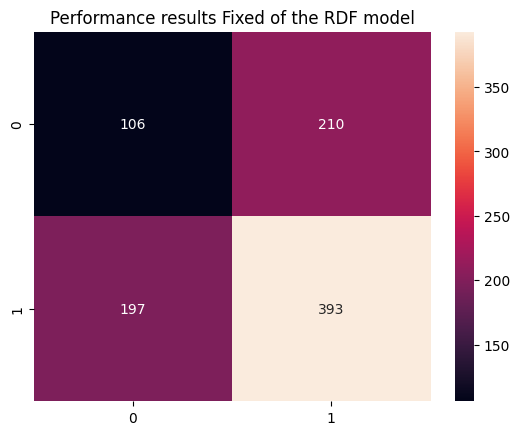


Feature Importance of the model



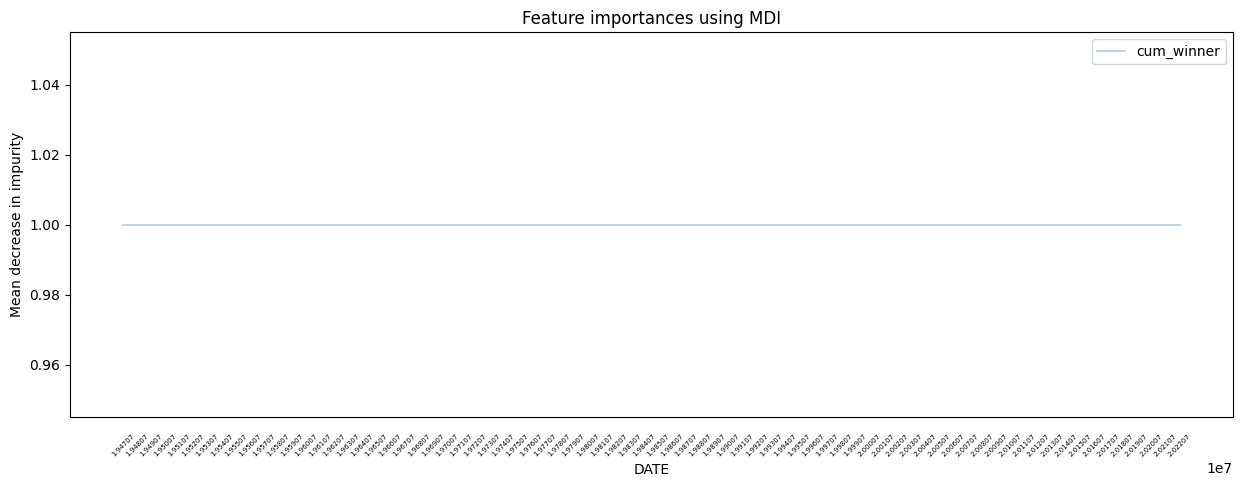

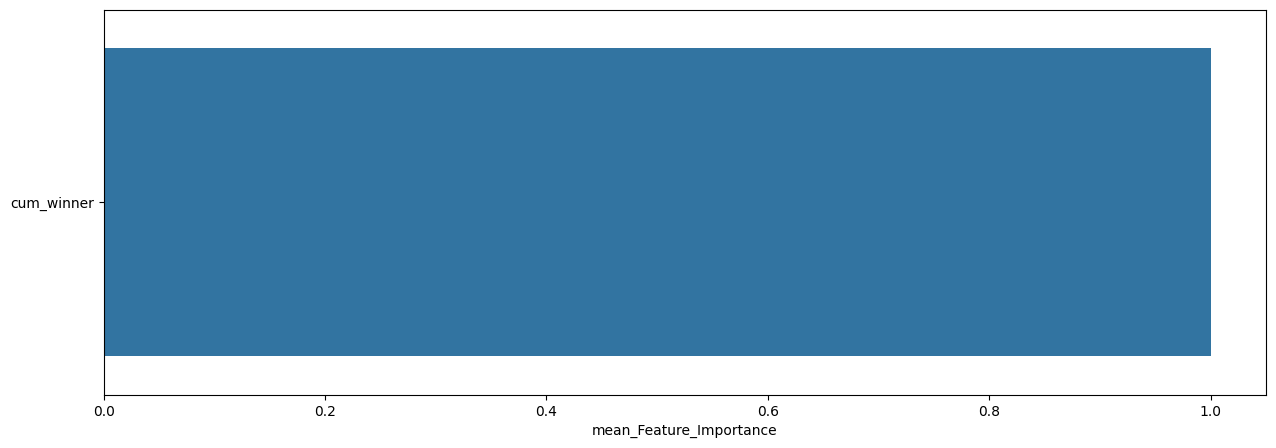

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [90]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=RDF, # 사용할 모델
                                  model_name='RDF', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.40      0.44      0.42        75
         1.0       0.71      0.67      0.69       151

    accuracy                           0.59       226
   macro avg       0.55      0.55      0.55       226
weighted avg       0.60      0.59      0.60       226


accuracy : 0.5929203539823009

precision : 0.7062937062937062

recall : 0.6688741721854304

F1-Score : 0.6870748299319727



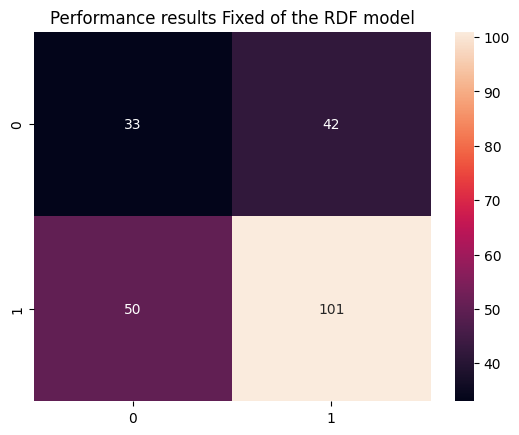


Feature Importance of the model



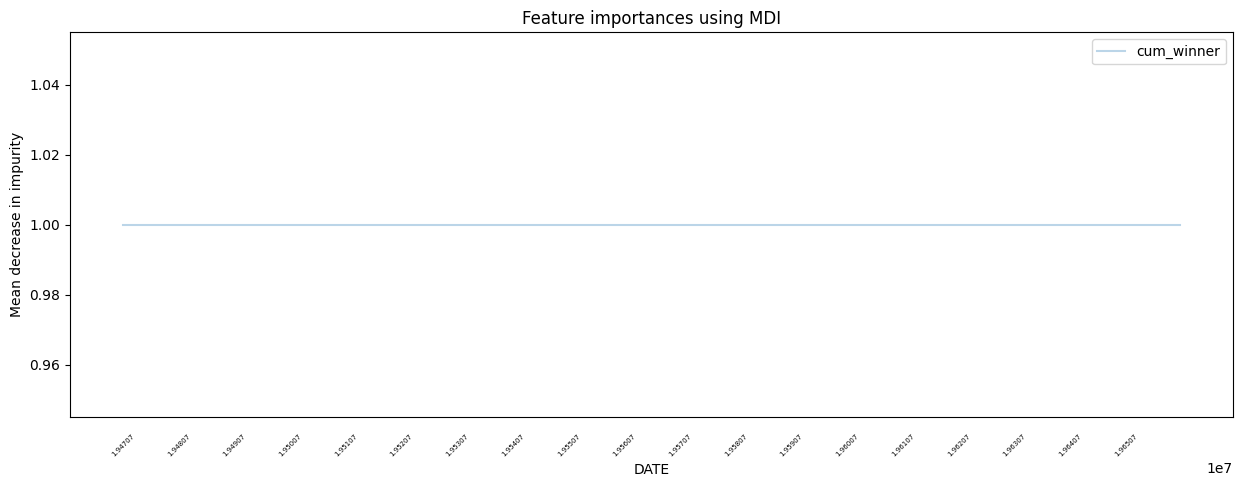

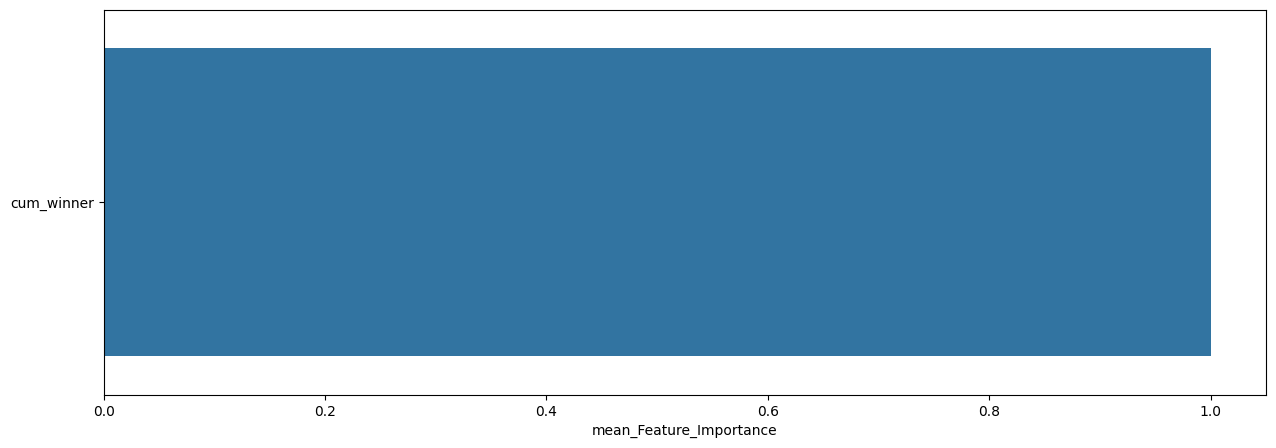

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.39      0.39        75
         1.0       0.70      0.70      0.70       151

    accuracy                           0.60       226
   macro avg       0.54      0.54      0.54       226
weighted avg       0.60      0.60      0.60       226


accuracy : 0.5973451327433629

precision : 0.6973684210526315

recall : 0.7019867549668874

F1-Score : 0.6996699669966997



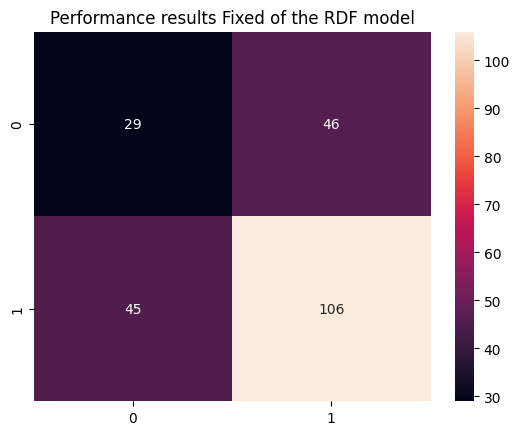


Feature Importance of the model



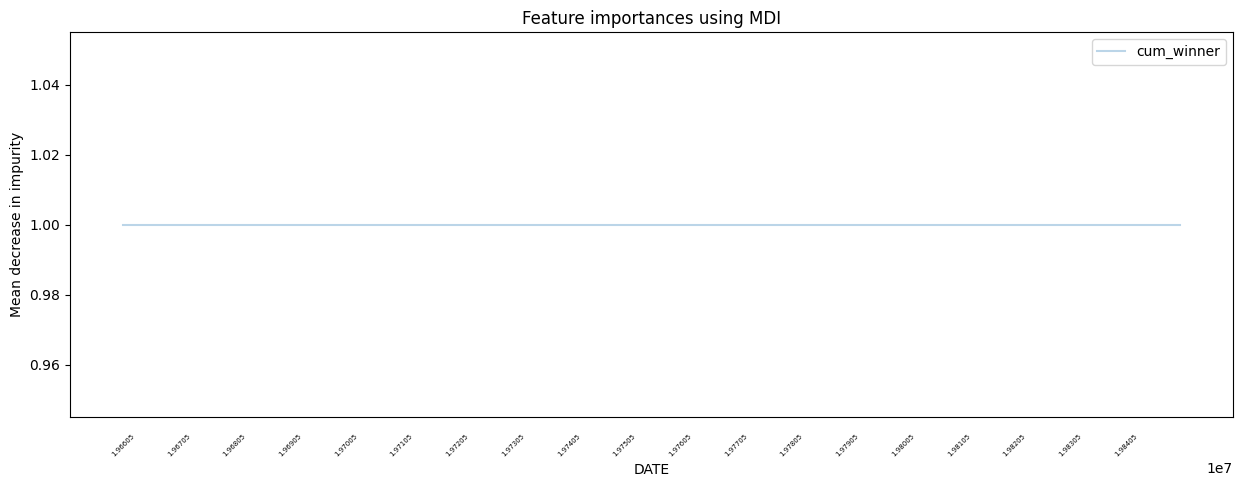

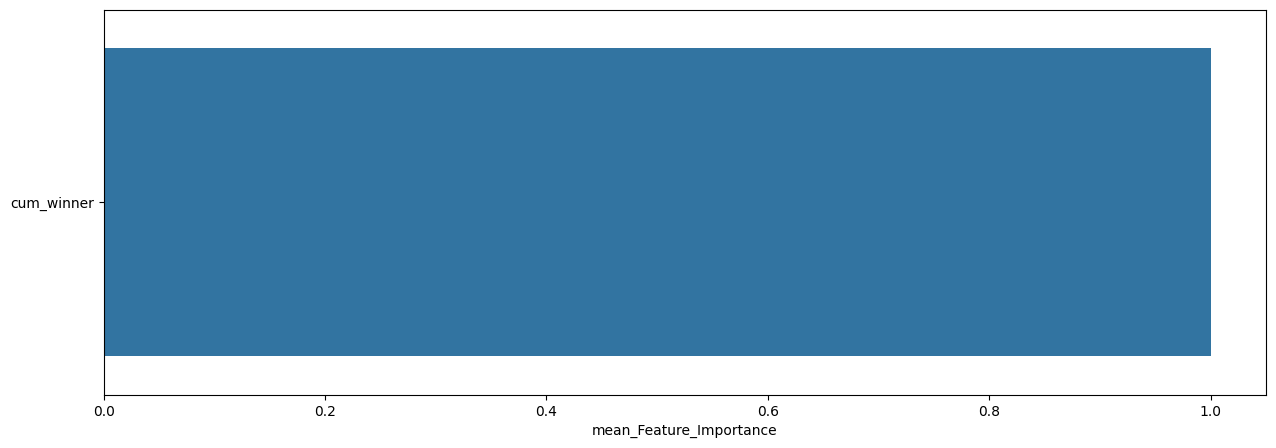

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.24      0.20      0.22        70
         1.0       0.66      0.71      0.69       156

    accuracy                           0.55       226
   macro avg       0.45      0.46      0.45       226
weighted avg       0.53      0.55      0.54       226


accuracy : 0.5530973451327433

precision : 0.6646706586826348

recall : 0.7115384615384616

F1-Score : 0.6873065015479876



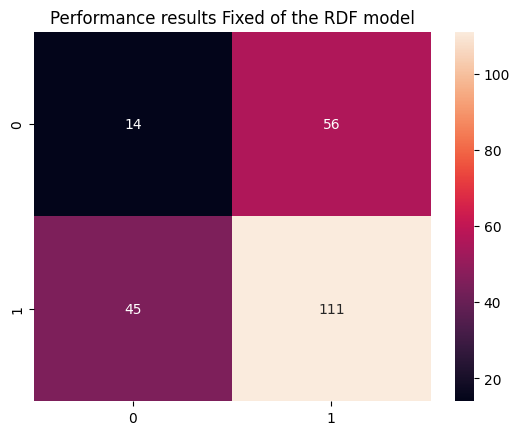


Feature Importance of the model



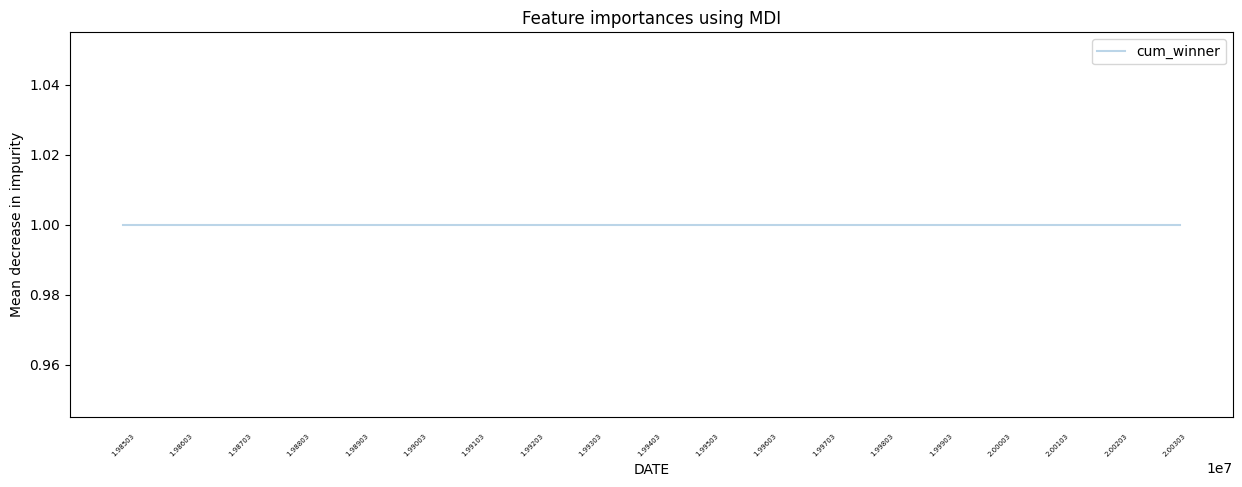

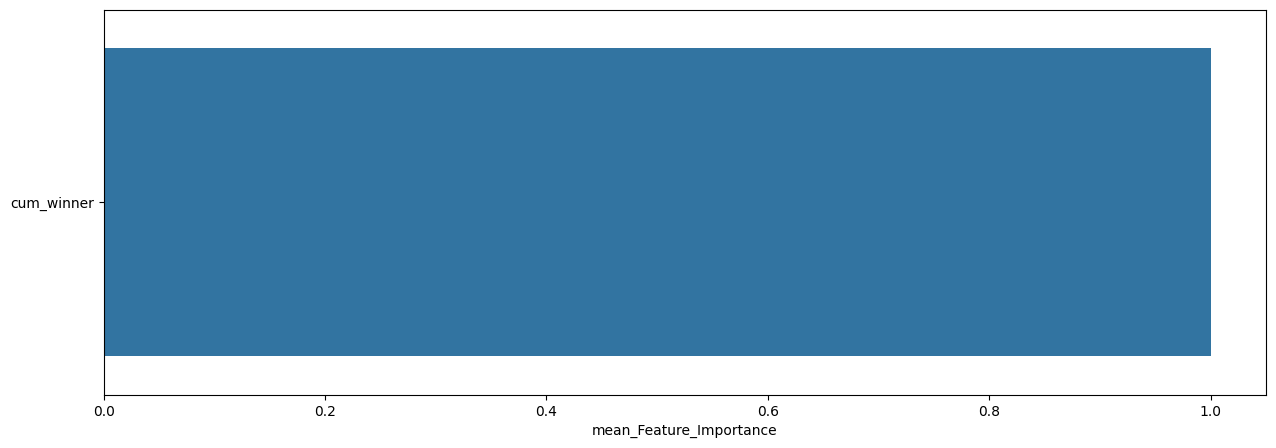

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.31      0.33        96
         1.0       0.53      0.57      0.55       132

    accuracy                           0.46       228
   macro avg       0.44      0.44      0.44       228
weighted avg       0.45      0.46      0.46       228


accuracy : 0.4605263157894737

precision : 0.5319148936170213

recall : 0.5681818181818182

F1-Score : 0.5494505494505494



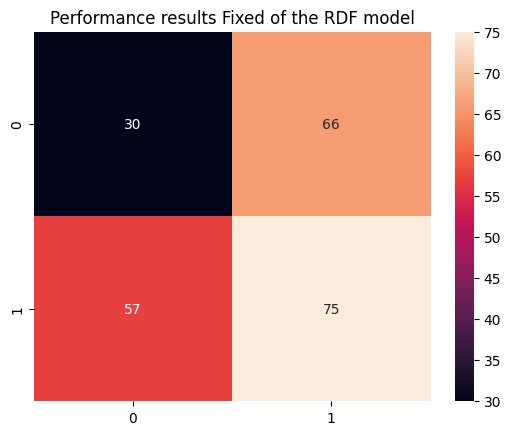


Feature Importance of the model



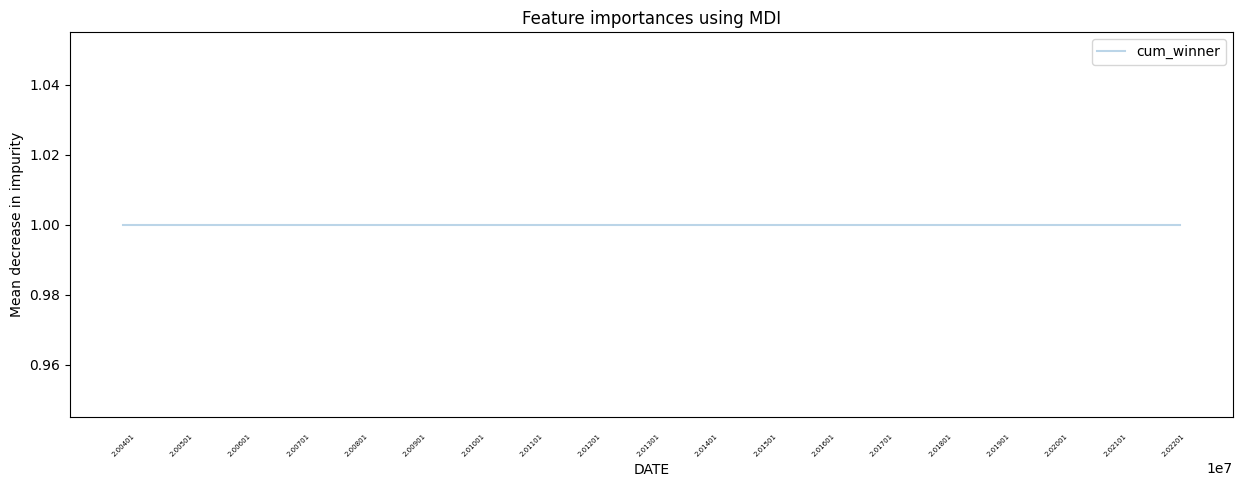

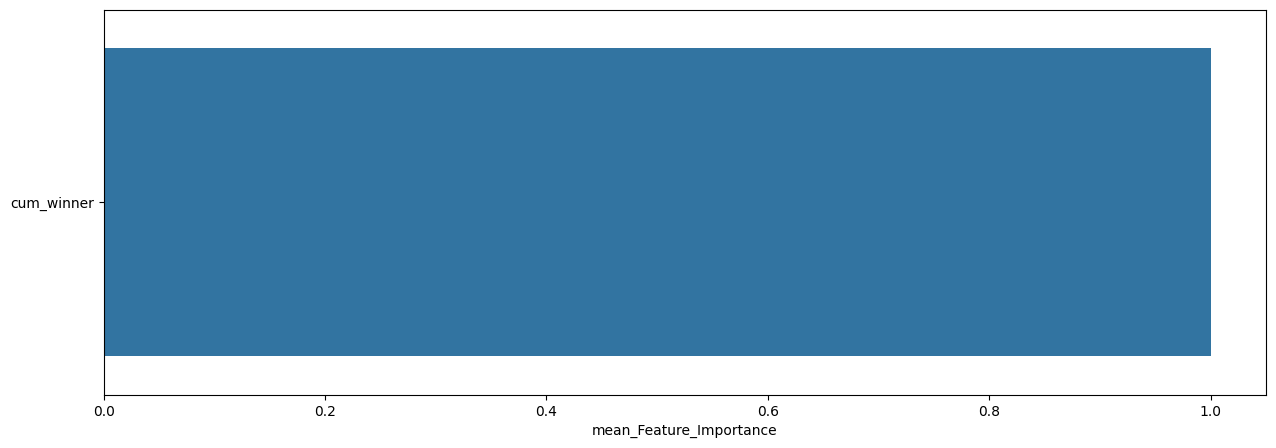

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [91]:
slice_feature_importance(Fixed_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



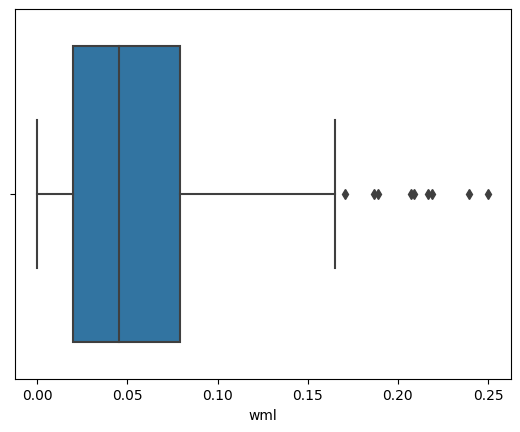

count      mean       std       min       25%       50%      75%  \
wml  393.0  0.055128  0.045401  0.000128  0.020141  0.045557  0.07947   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



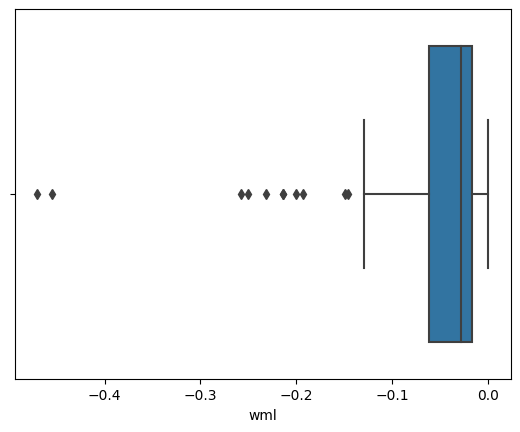

count      mean       std       min       25%       50%       75%  \
wml  106.0 -0.058575  0.080007 -0.469903 -0.062136 -0.028293 -0.016824   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



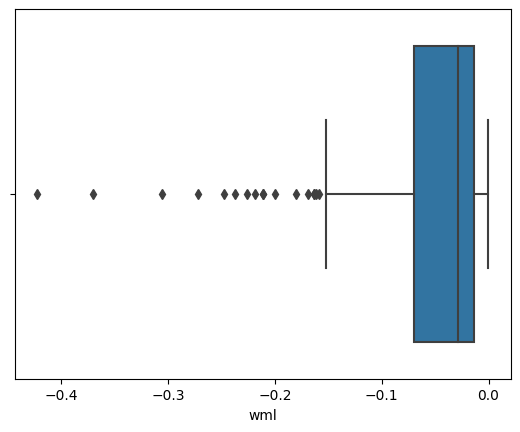

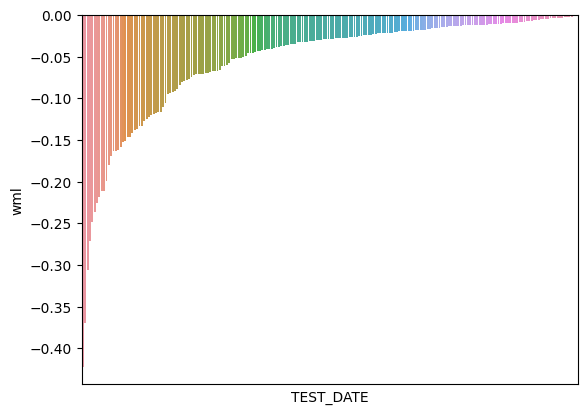

count      mean       std     min       25%       50%     75%       max
wml  210.0 -0.055168  0.066545 -0.4224 -0.069478 -0.028699 -0.0134 -0.000183


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



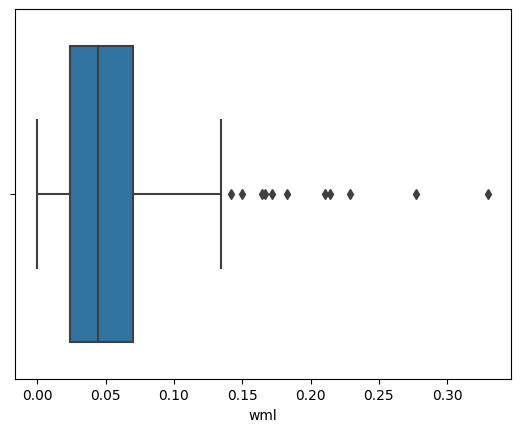

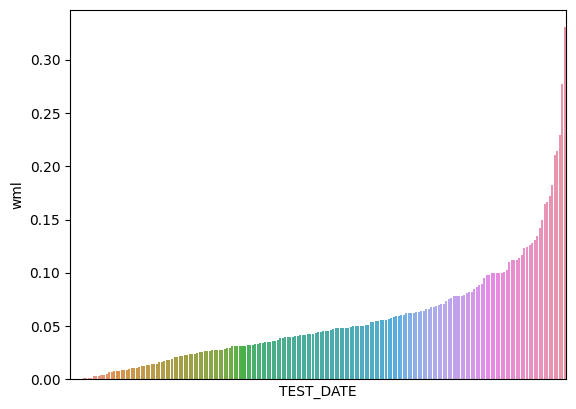

count      mean       std       min       25%       50%      75%  \
wml  197.0  0.055493  0.049622  0.000007  0.024176  0.044264  0.07036   

          max  
wml  0.330163

In [92]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Fixed_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.75214

최근 누적 수익률

  2022년-12월 -> 3737.64
  2022년-11월 -> 3737.64
  2022년-10월 -> 3555.23
  2022년-09월 -> 3148.00
  2022년-08월 -> 3148.00

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-06월 -> 13765.43
  2등 : 2002년-07월 -> 13765.43
  3등 : 2002년-08월 -> 13366.60
  4등 : 2002년-09월 -> 13366.60
  5등 : 2002년-10월 -> 13366.60
  6등 : 2002년-05월 -> 11836.52
  7등 : 2002년-02월 -> 11454.02
  8등 : 2002년-03월 -> 10978.39
  9등 : 2002년-04월 -> 10978.39
  10등 : 2003년-02월 -> 10023.59



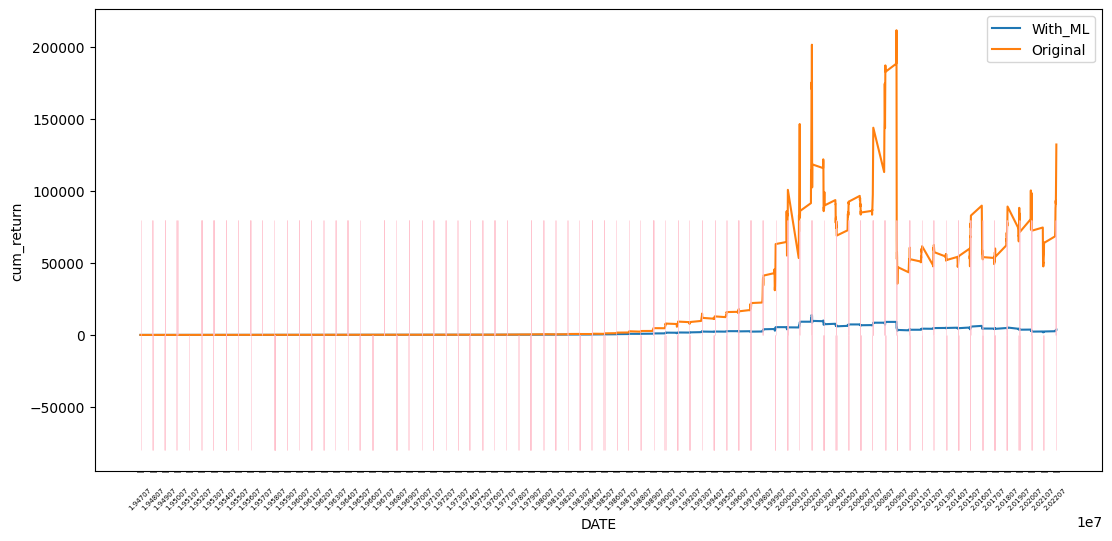

In [93]:
RDF_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.76736

최근 누적 수익률

  2022년-12월 -> 5280.55
  2022년-11월 -> 5263.20
  2022년-10월 -> 5078.23
  2022년-09월 -> 4496.59
  2022년-08월 -> 4465.35

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 9630.79
  2등 : 2002년-07월 -> 9247.66
  3등 : 2002년-06월 -> 9217.40
  4등 : 2002년-08월 -> 9052.06
  5등 : 2002년-10월 -> 8905.25
  6등 : 2002년-05월 -> 7925.75
  7등 : 2002년-04월 -> 7481.30
  8등 : 2009년-02월 -> 7382.94
  9등 : 2002년-02월 -> 7337.79
  10등 : 2008년-11월 -> 7201.76



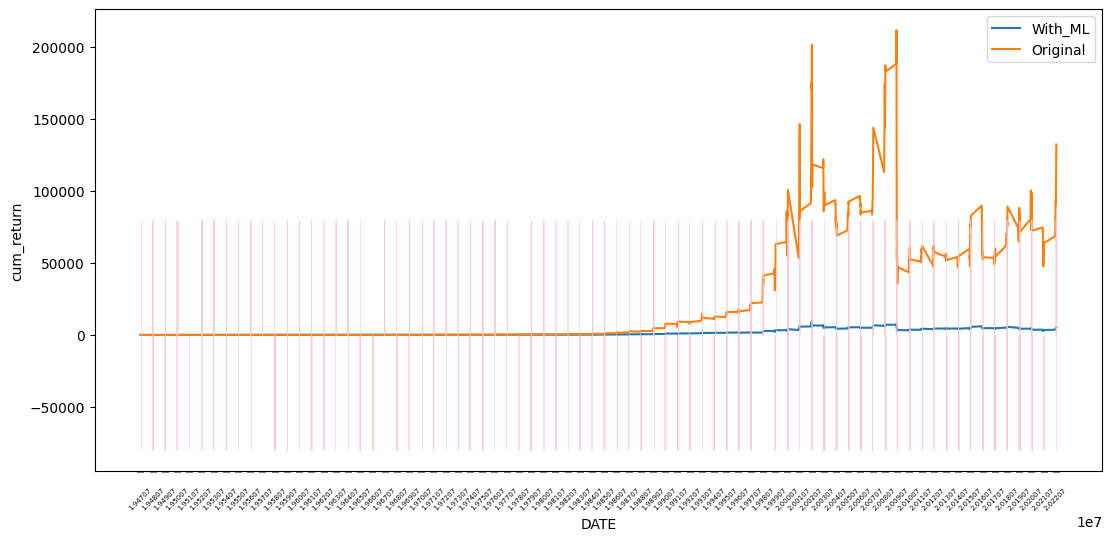

In [94]:
RDF_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [95]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.25      0.29       316
         1.0       0.65      0.74      0.69       590

    accuracy                           0.57       906
   macro avg       0.50      0.50      0.49       906
weighted avg       0.54      0.57      0.55       906


accuracy : 0.5728476821192053

precision : 0.6503703703703704

recall : 0.7440677966101695

F1-Score : 0.6940711462450593



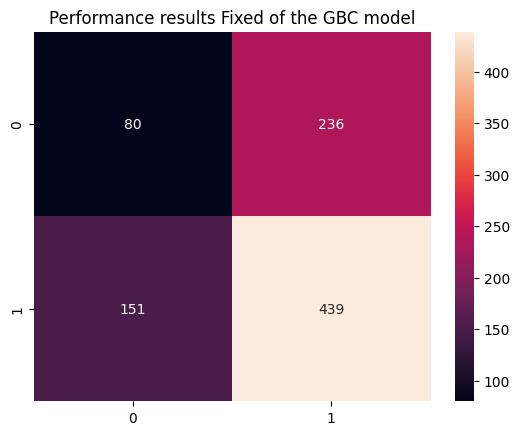


Feature Importance of the model



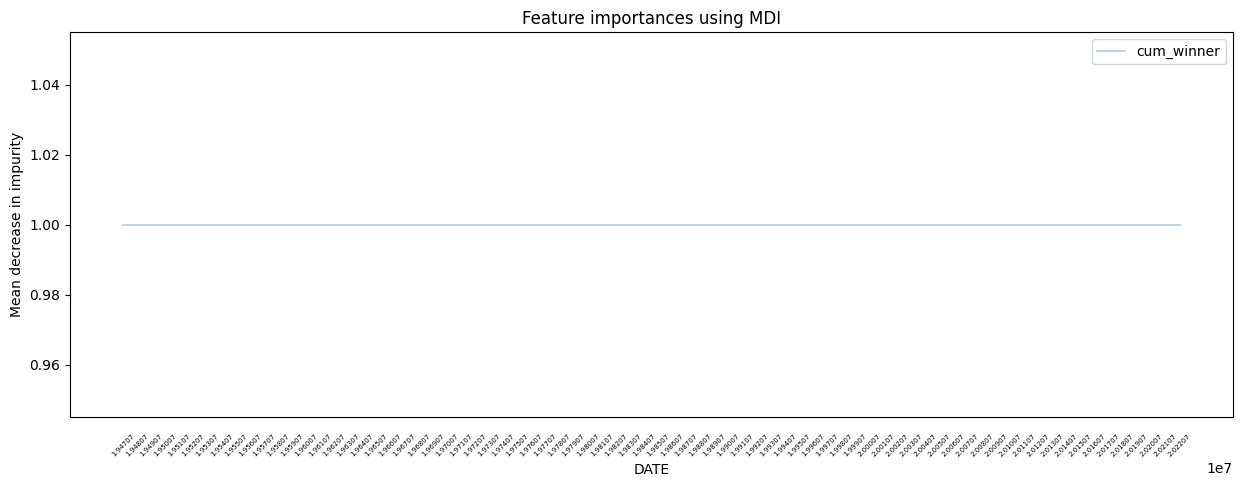

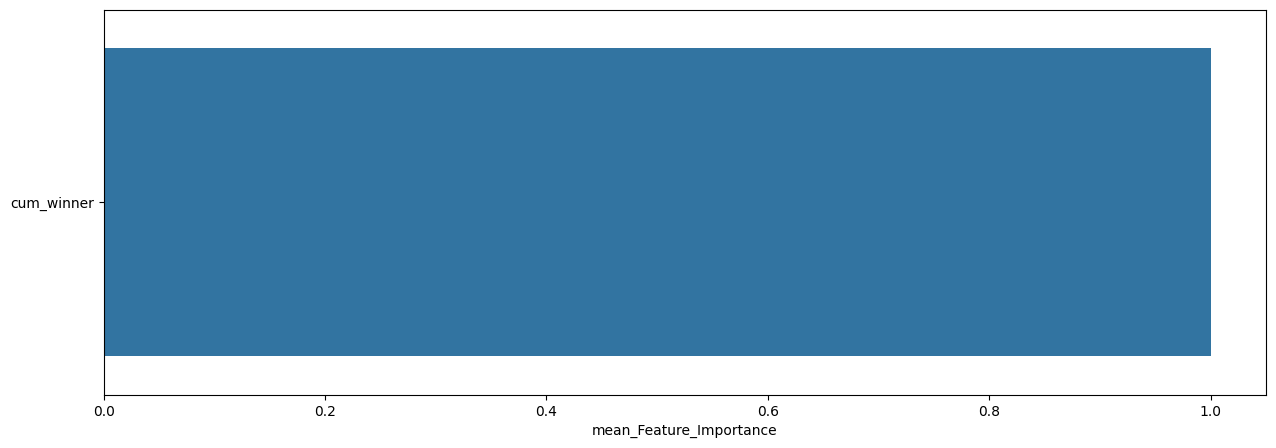

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [96]:
Fixed_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=GBC, # 사용할 모델
                                  model_name='GBC', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.36      0.37        75
         1.0       0.69      0.71      0.70       151

    accuracy                           0.59       226
   macro avg       0.54      0.53      0.53       226
weighted avg       0.59      0.59      0.59       226


accuracy : 0.5929203539823009

precision : 0.6903225806451613

recall : 0.7086092715231788

F1-Score : 0.6993464052287581



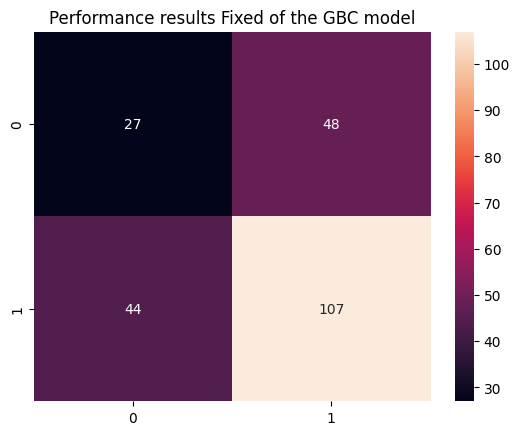


Feature Importance of the model



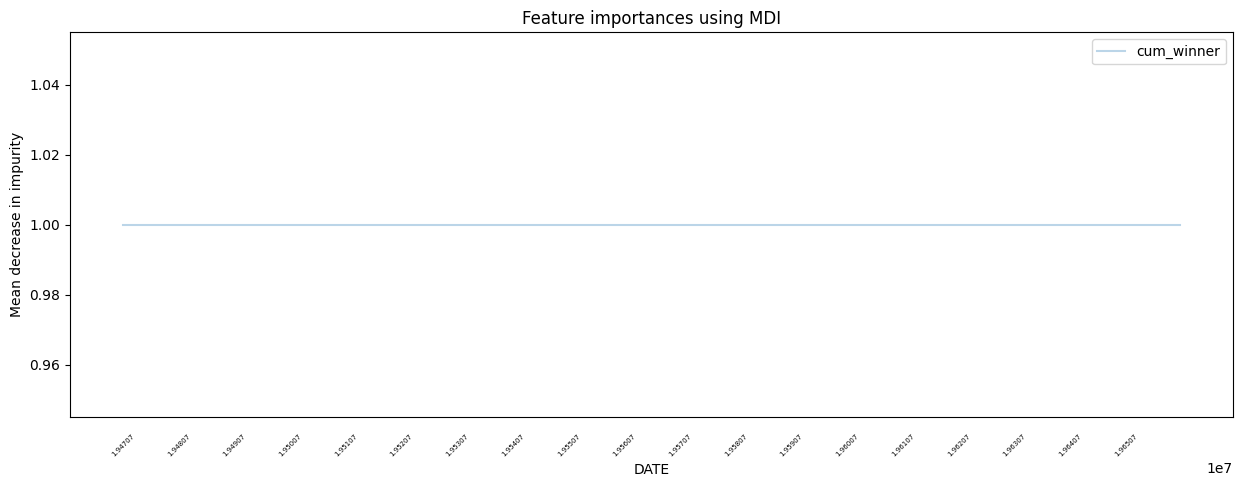

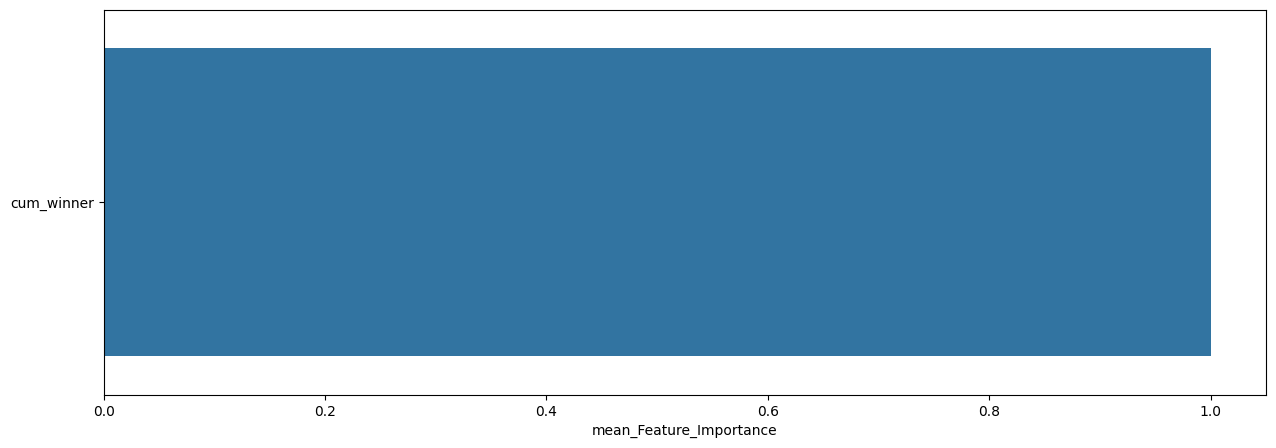

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.27      0.31        75
         1.0       0.68      0.79      0.73       151

    accuracy                           0.62       226
   macro avg       0.53      0.53      0.52       226
weighted avg       0.58      0.62      0.59       226


accuracy : 0.6150442477876106

precision : 0.6839080459770115

recall : 0.7880794701986755

F1-Score : 0.7323076923076923



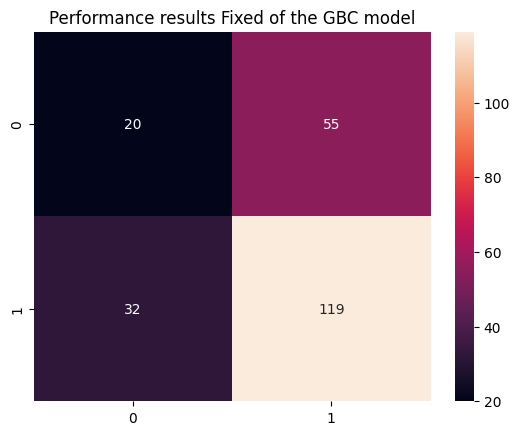


Feature Importance of the model



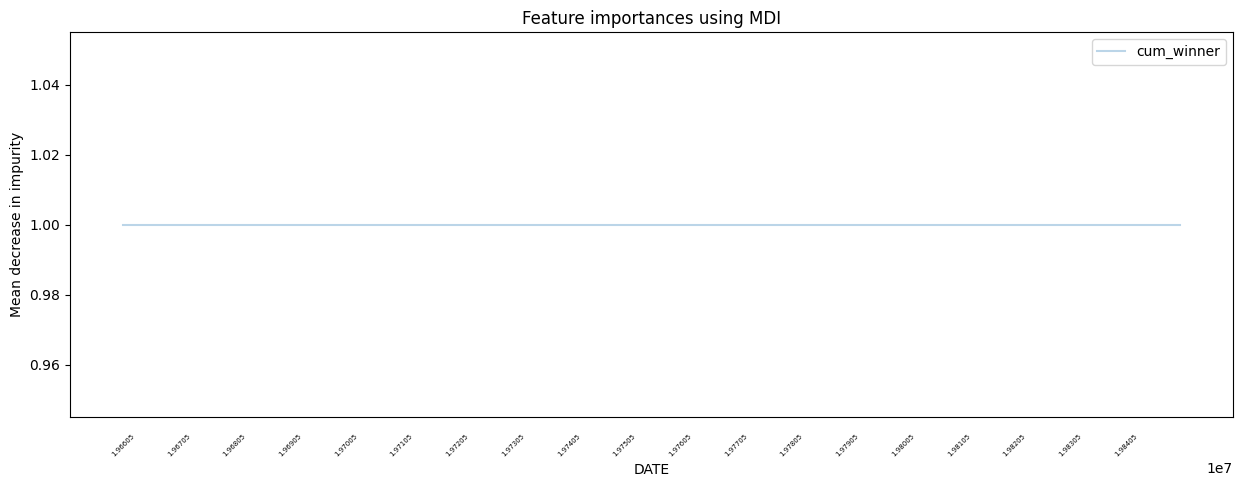

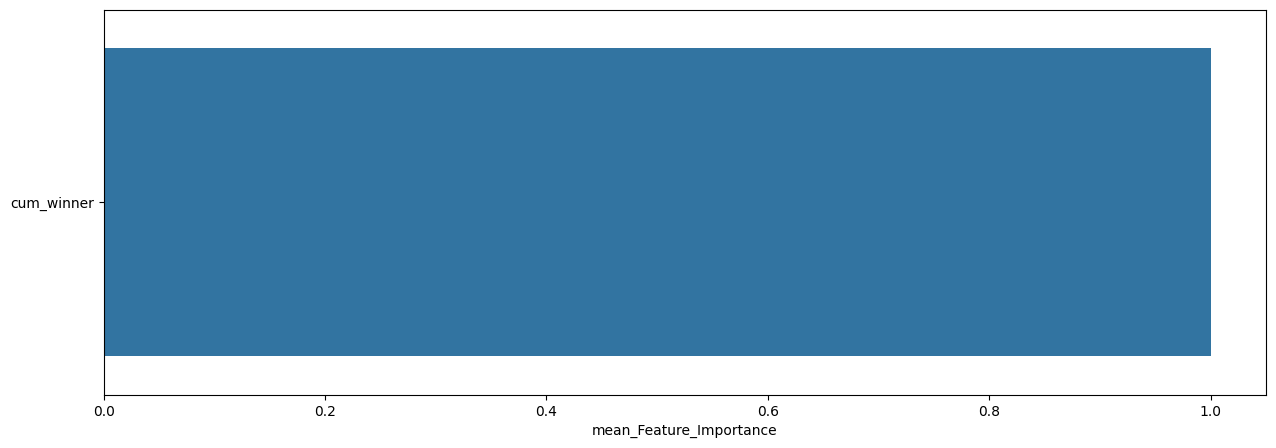

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.19      0.11      0.14        70
         1.0       0.66      0.78      0.72       156

    accuracy                           0.58       226
   macro avg       0.43      0.45      0.43       226
weighted avg       0.52      0.58      0.54       226


accuracy : 0.5752212389380531

precision : 0.6630434782608695

recall : 0.782051282051282

F1-Score : 0.7176470588235294



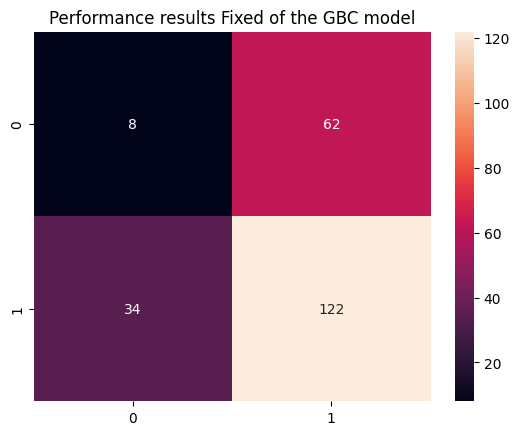


Feature Importance of the model



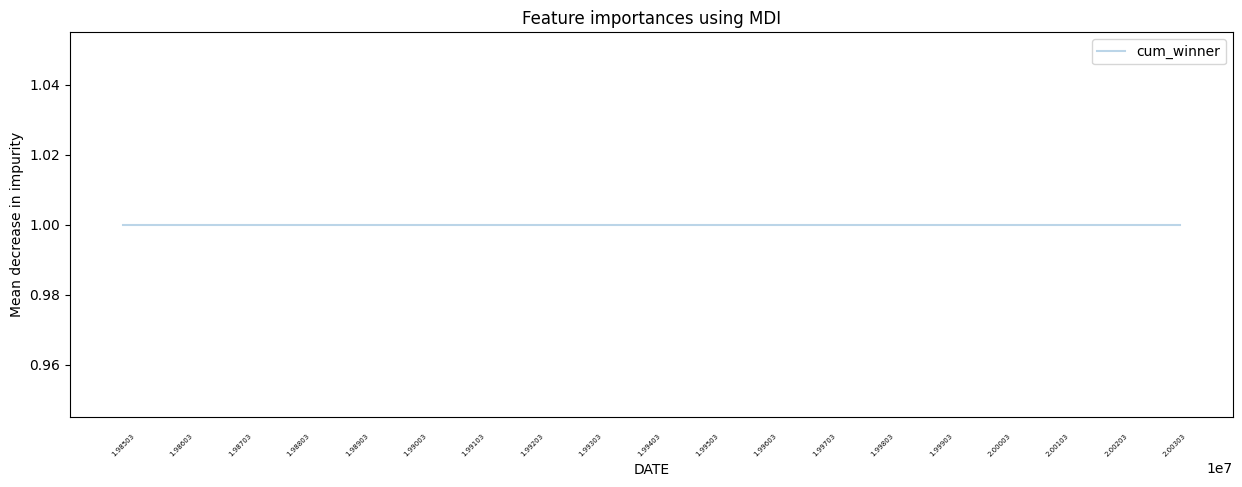

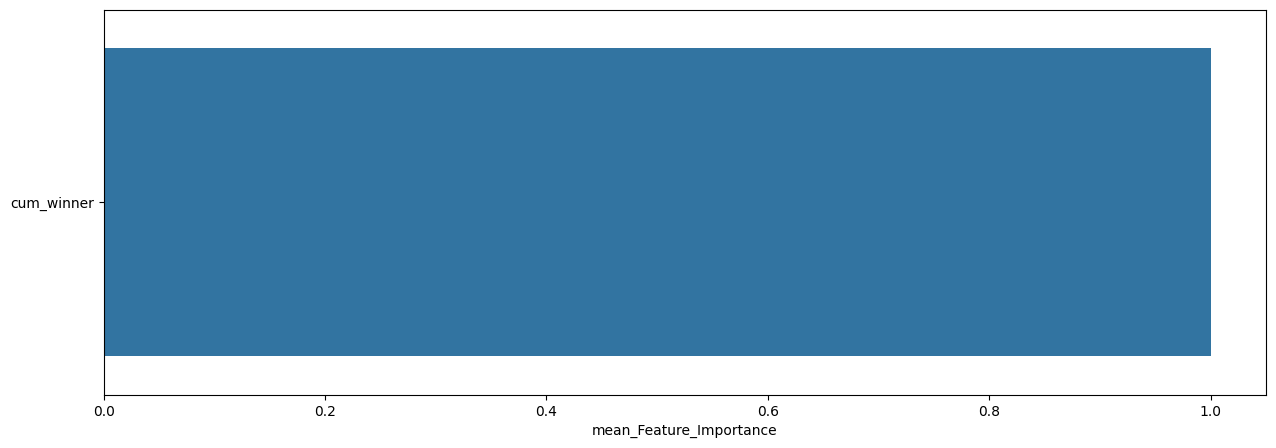

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.26      0.31        96
         1.0       0.56      0.69      0.62       132

    accuracy                           0.51       228
   macro avg       0.47      0.47      0.46       228
weighted avg       0.48      0.51      0.49       228


accuracy : 0.5087719298245614

precision : 0.5617283950617284

recall : 0.6893939393939394

F1-Score : 0.6190476190476192



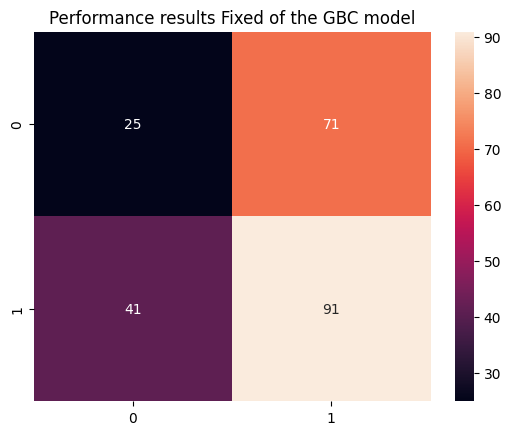


Feature Importance of the model



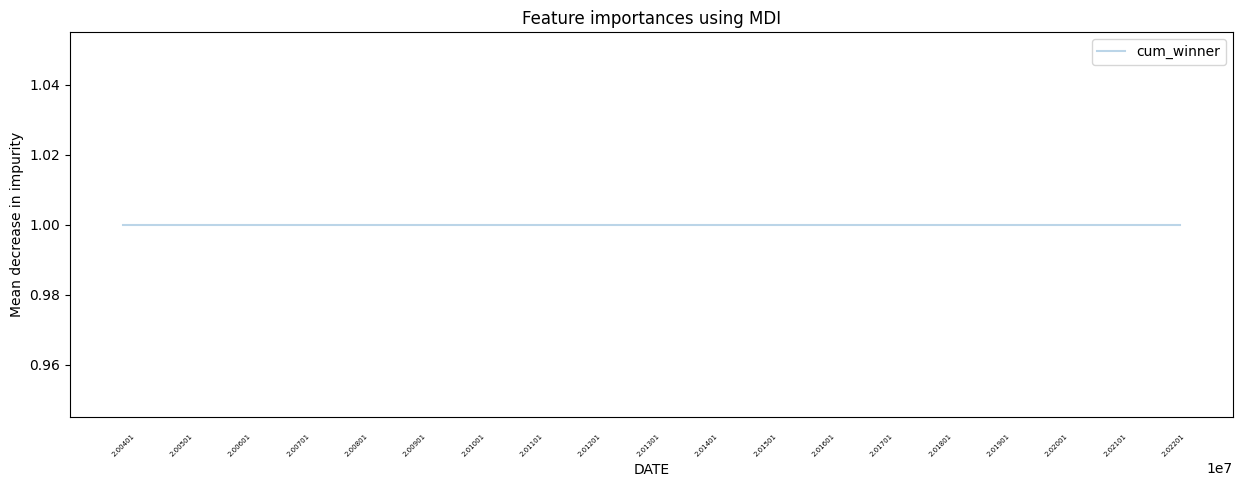

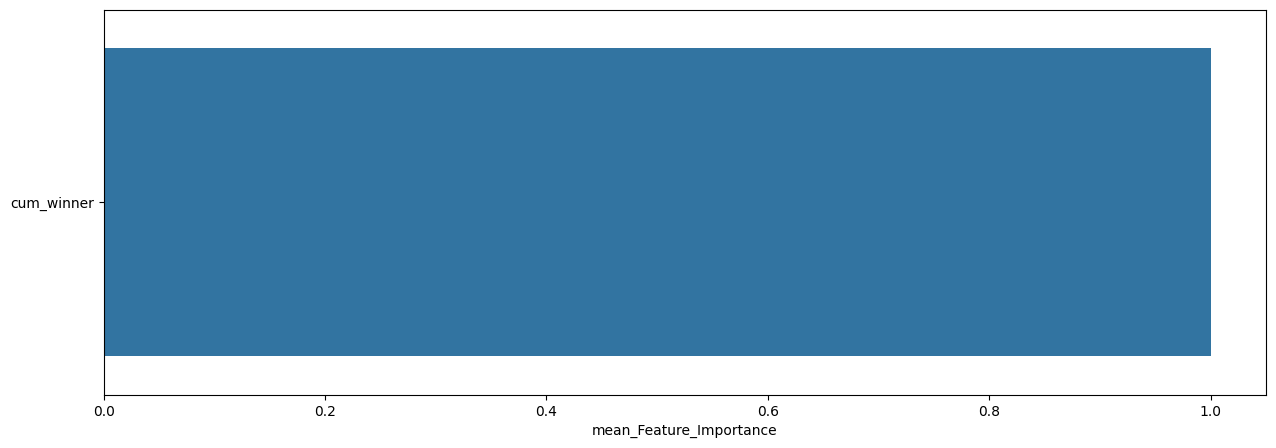

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [97]:
slice_feature_importance(Fixed_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



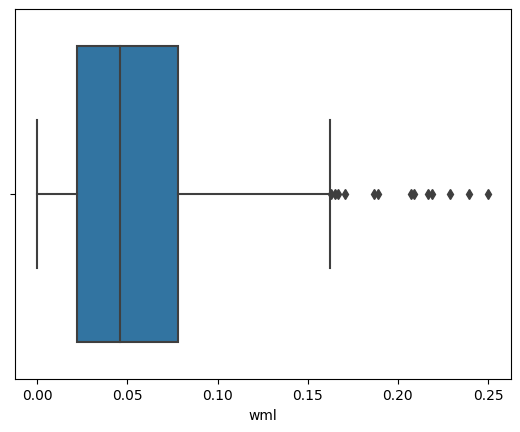

count      mean      std       min       25%       50%       75%  \
wml  439.0  0.055637  0.04511  0.000128  0.021926  0.046172  0.078207   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



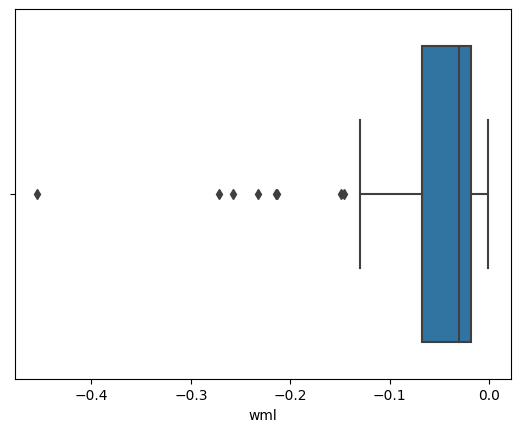

count      mean       std       min       25%       50%       75%  \
wml   80.0 -0.059318  0.074284 -0.454349 -0.068119 -0.030026 -0.018709   

          max  
wml -0.000957


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



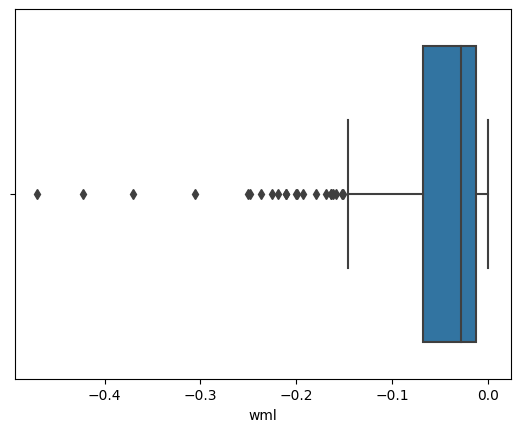

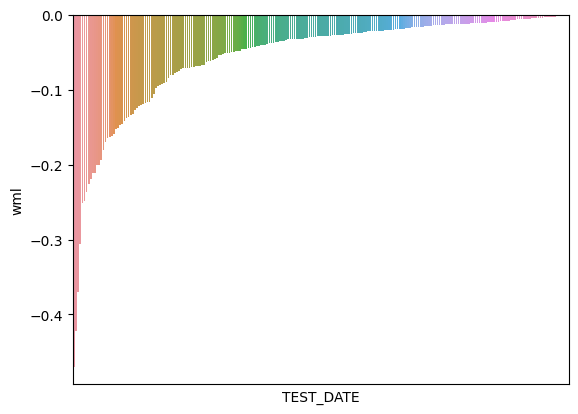

count      mean       std       min      25%       50%       75%  \
wml  236.0 -0.055292  0.070305 -0.469903 -0.06795 -0.028581 -0.013162   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



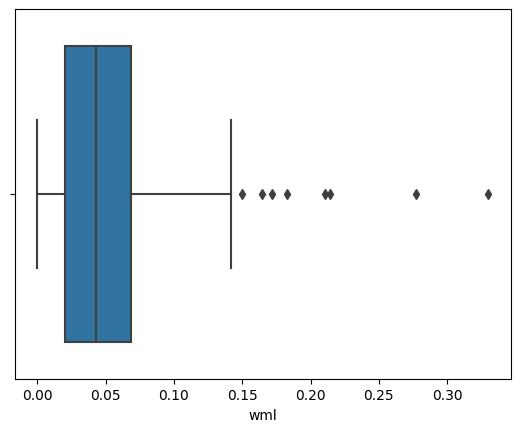

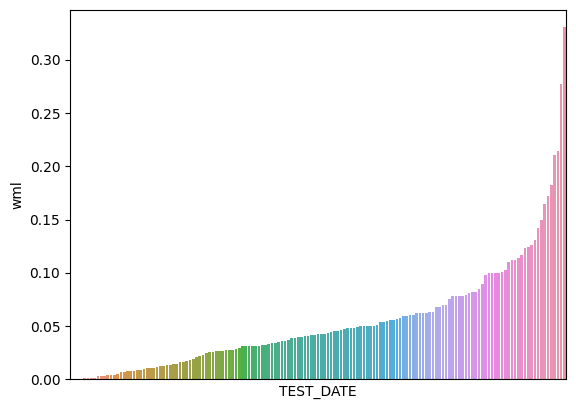

count      mean       std       min       25%       50%       75%  \
wml  151.0  0.054123  0.051582  0.000007  0.019948  0.042855  0.068773   

          max  
wml  0.330163

In [98]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Fixed_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.80761

최근 누적 수익률

  2022년-12월 -> 9792.08
  2022년-11월 -> 9792.08
  2022년-10월 -> 9314.29
  2022년-09월 -> 8247.57
  2022년-08월 -> 8247.57

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-07월 -> 14482.74
  2등 : 2002년-06월 -> 14482.74
  3등 : 1999년-12월 -> 14269.01
  4등 : 2000년-01월 -> 14269.01
  5등 : 2000년-02월 -> 14269.01
  6등 : 2002년-09월 -> 14063.13
  7등 : 2002년-08월 -> 14063.13
  8등 : 2000년-09월 -> 13923.34
  9등 : 2000년-10월 -> 13923.34
  10등 : 2000년-08월 -> 13923.34



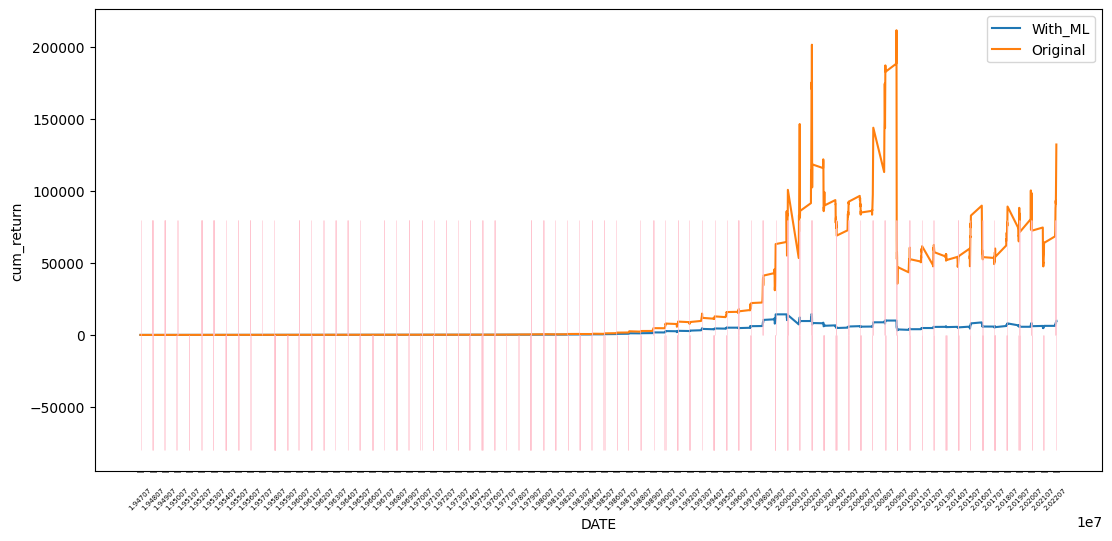

In [99]:
GBC_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.80227

최근 누적 수익률

  2022년-12월 -> 5214.29
  2022년-11월 -> 5029.98
  2022년-10월 -> 4820.69
  2022년-09월 -> 4367.12
  2022년-08월 -> 4272.57

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 7165.10
  2등 : 2002년-07월 -> 6783.08
  3등 : 2002년-06월 -> 6665.49
  4등 : 2002년-08월 -> 6653.25
  5등 : 2009년-02월 -> 6553.18
  6등 : 2008년-11월 -> 6482.61
  7등 : 2002년-10월 -> 6465.15
  8등 : 2009년-01월 -> 6370.50
  9등 : 2008년-12월 -> 6344.57
  10등 : 2008년-06월 -> 5965.98



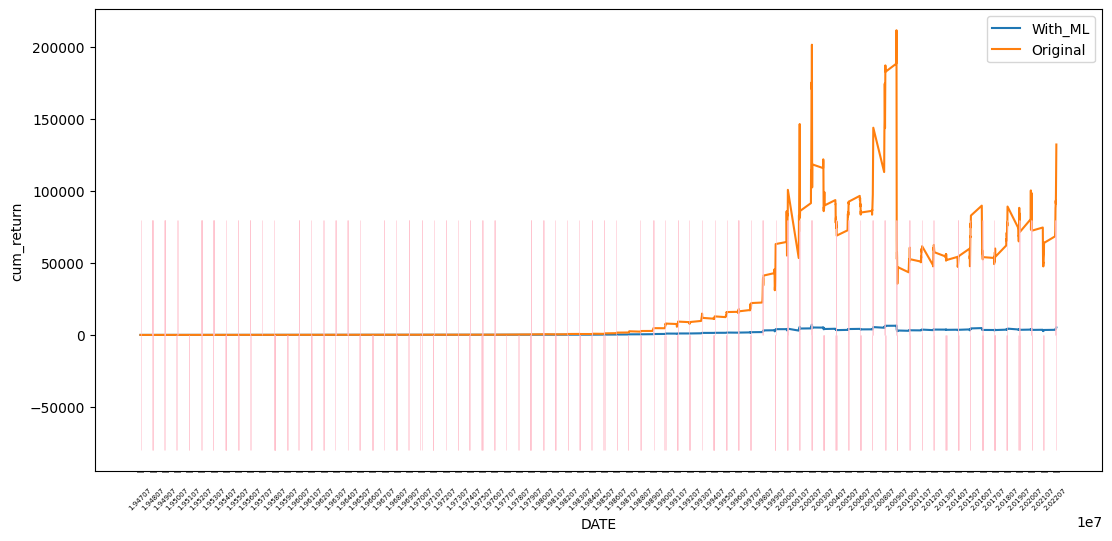

In [100]:
GBC_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PROB_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

### XGB

In [101]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : None
 

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.28      0.31       316
         1.0       0.65      0.70      0.67       590

    accuracy                           0.55       906
   macro avg       0.49      0.49      0.49       906
weighted avg       0.54      0.55      0.54       906


accuracy : 0.5540838852097131

precision : 0.6453125

recall : 0.7

F1-Score : 0.6715447154471544



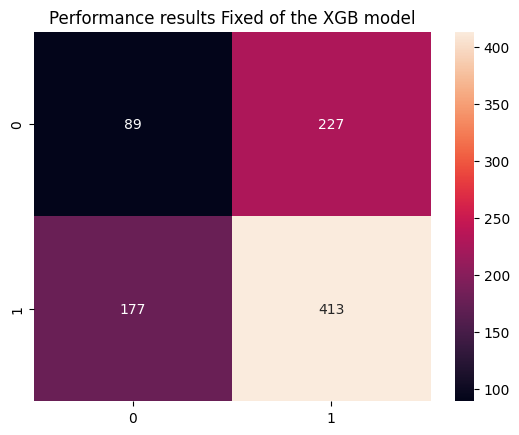


Feature Importance of the model



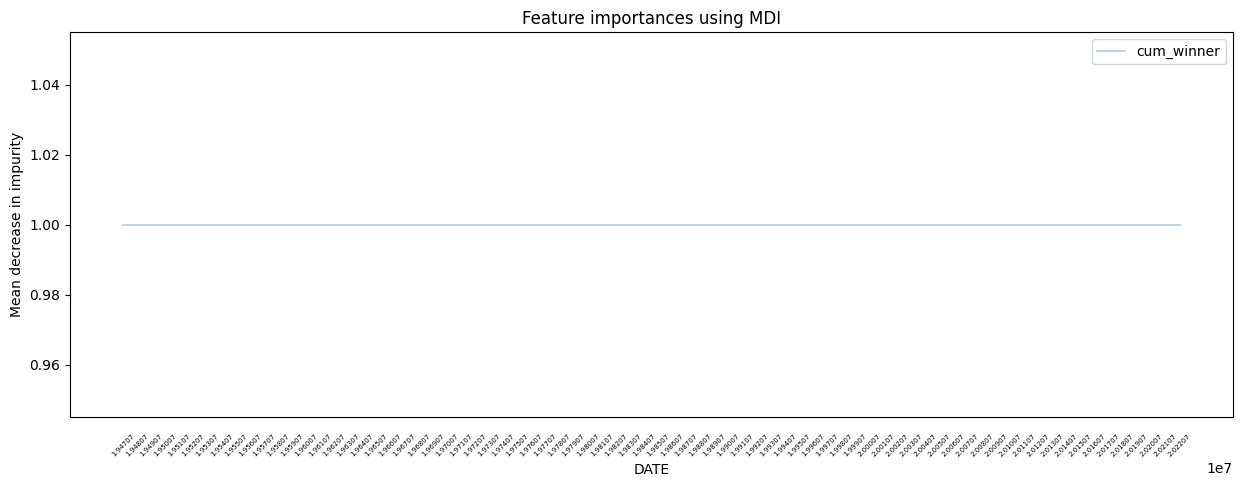

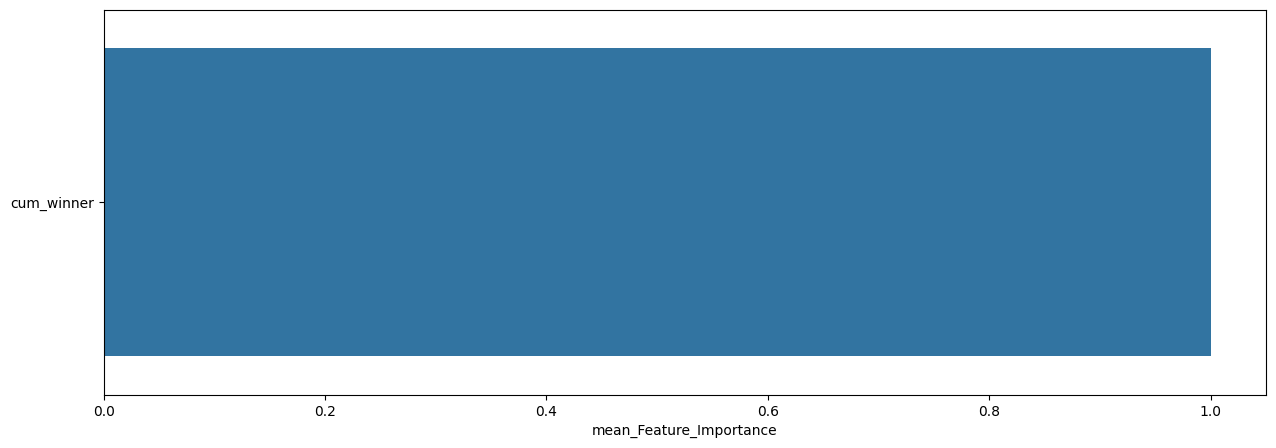

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [102]:
Fixed_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.41      0.39        75
         1.0       0.69      0.65      0.67       151

    accuracy                           0.57       226
   macro avg       0.53      0.53      0.53       226
weighted avg       0.58      0.57      0.58       226


accuracy : 0.5707964601769911

precision : 0.6901408450704225

recall : 0.6490066225165563

F1-Score : 0.6689419795221843



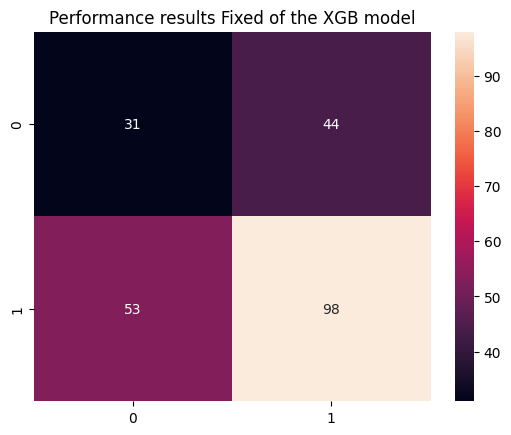


Feature Importance of the model



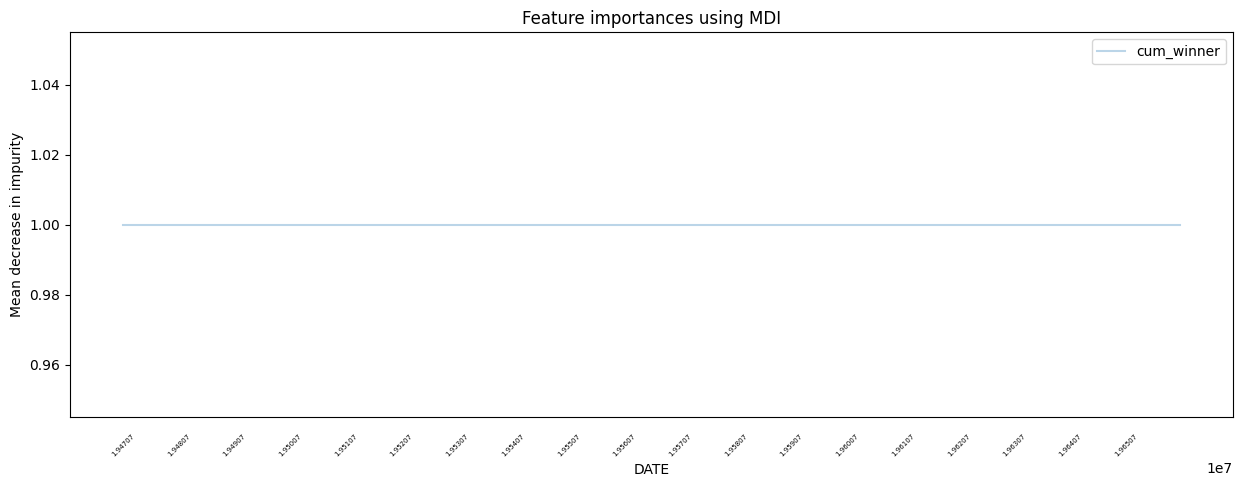

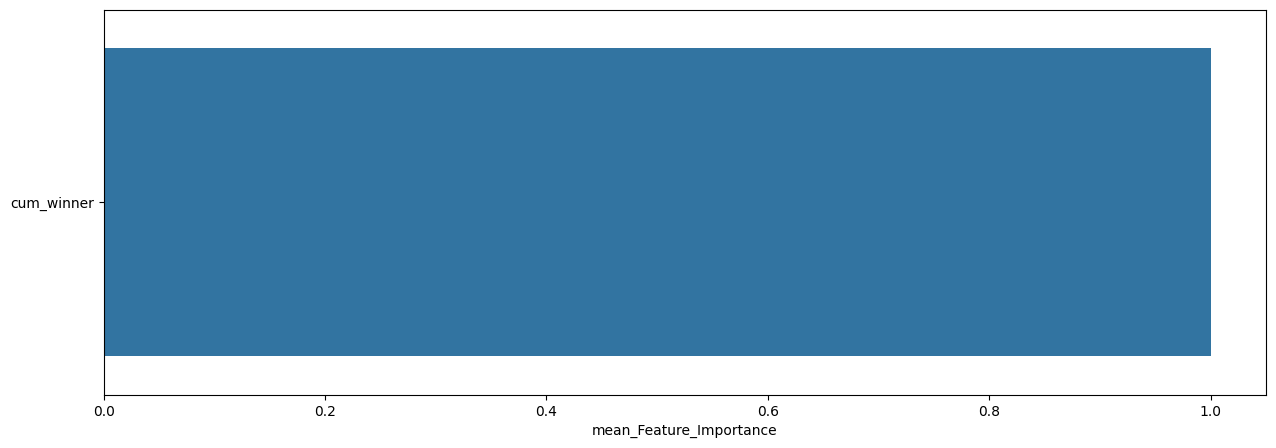

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.27      0.30        75
         1.0       0.67      0.75      0.71       151

    accuracy                           0.59       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.56      0.59      0.57       226


accuracy : 0.588495575221239

precision : 0.6726190476190477

recall : 0.7483443708609272

F1-Score : 0.7084639498432602



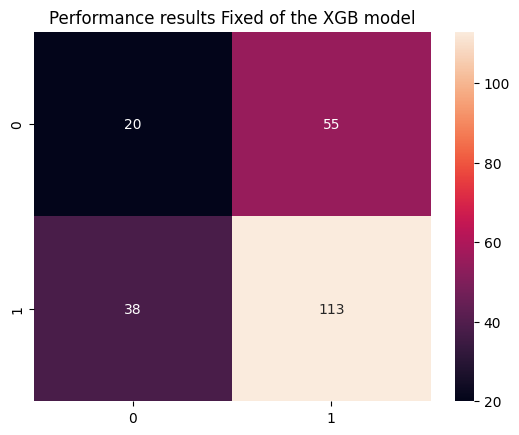


Feature Importance of the model



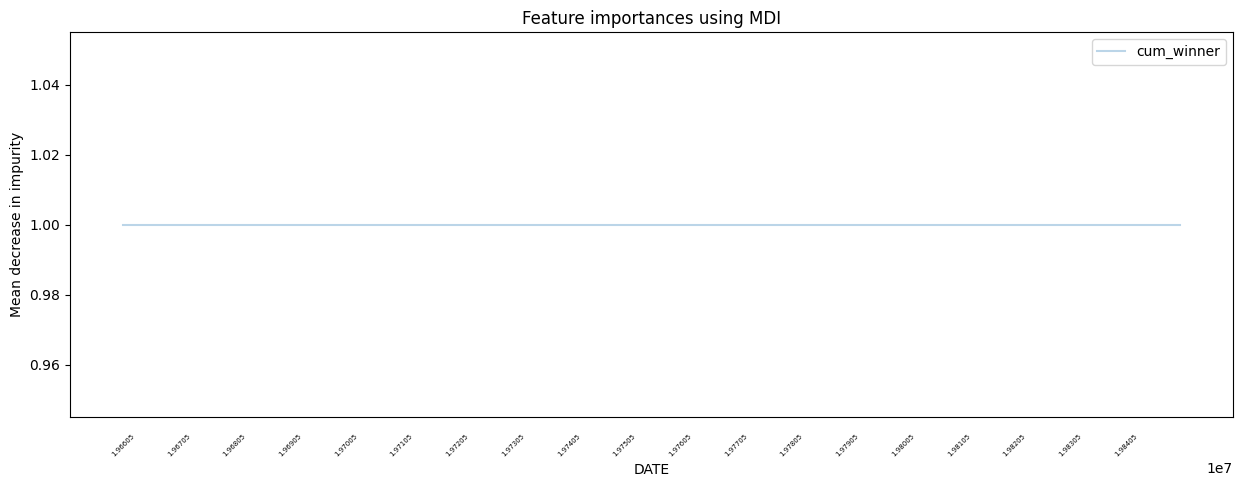

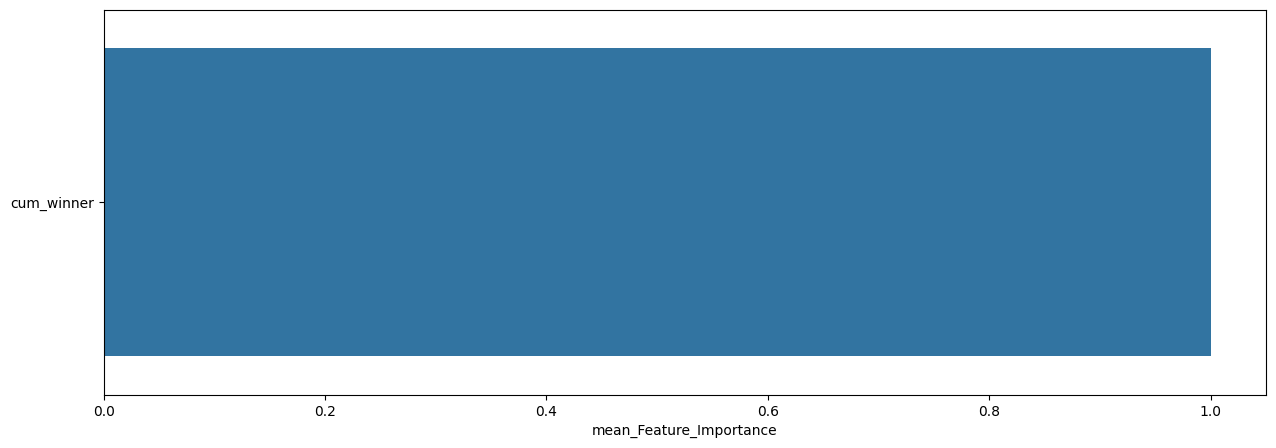

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.29      0.23      0.26        70
         1.0       0.68      0.75      0.72       156

    accuracy                           0.59       226
   macro avg       0.49      0.49      0.49       226
weighted avg       0.56      0.59      0.57       226


accuracy : 0.588495575221239

precision : 0.6842105263157895

recall : 0.75

F1-Score : 0.7155963302752295



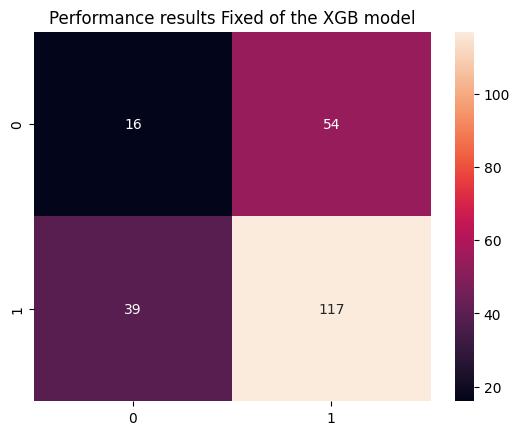


Feature Importance of the model



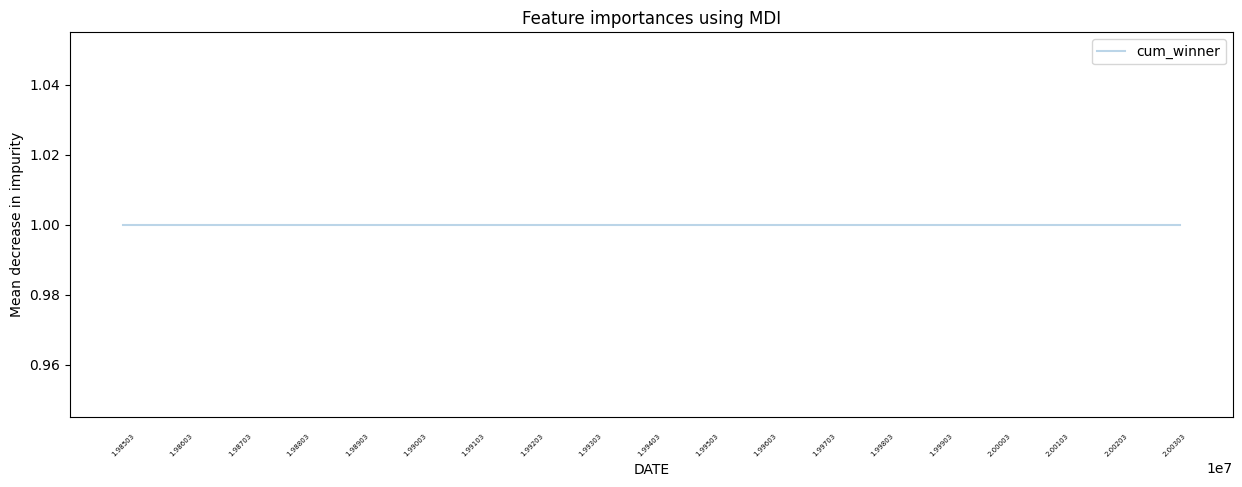

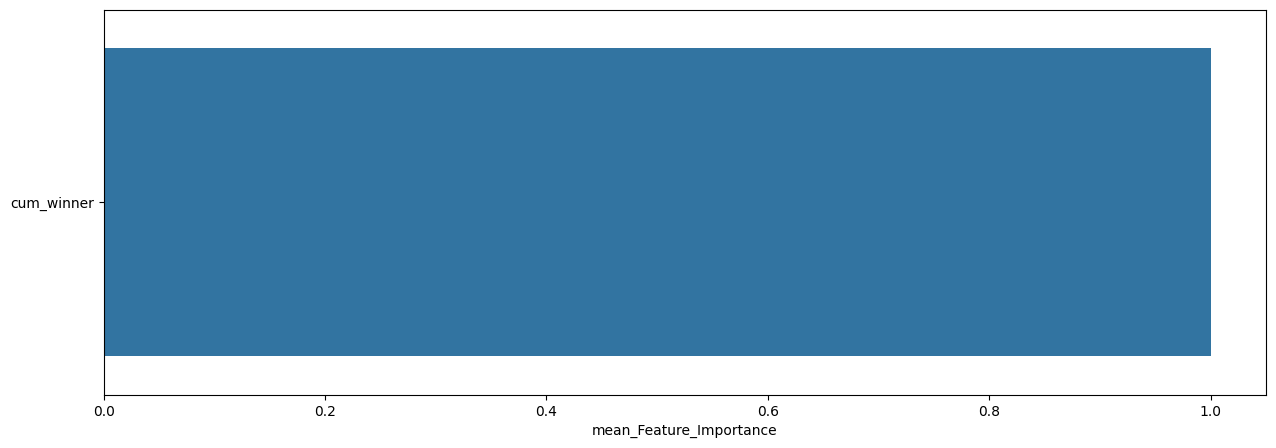

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.23      0.27        96
         1.0       0.53      0.64      0.58       132

    accuracy                           0.47       228
   macro avg       0.43      0.44      0.43       228
weighted avg       0.44      0.47      0.45       228


accuracy : 0.4692982456140351

precision : 0.5345911949685535

recall : 0.6439393939393939

F1-Score : 0.5841924398625429



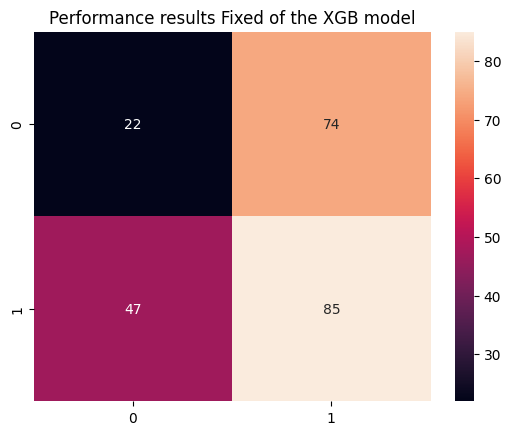


Feature Importance of the model



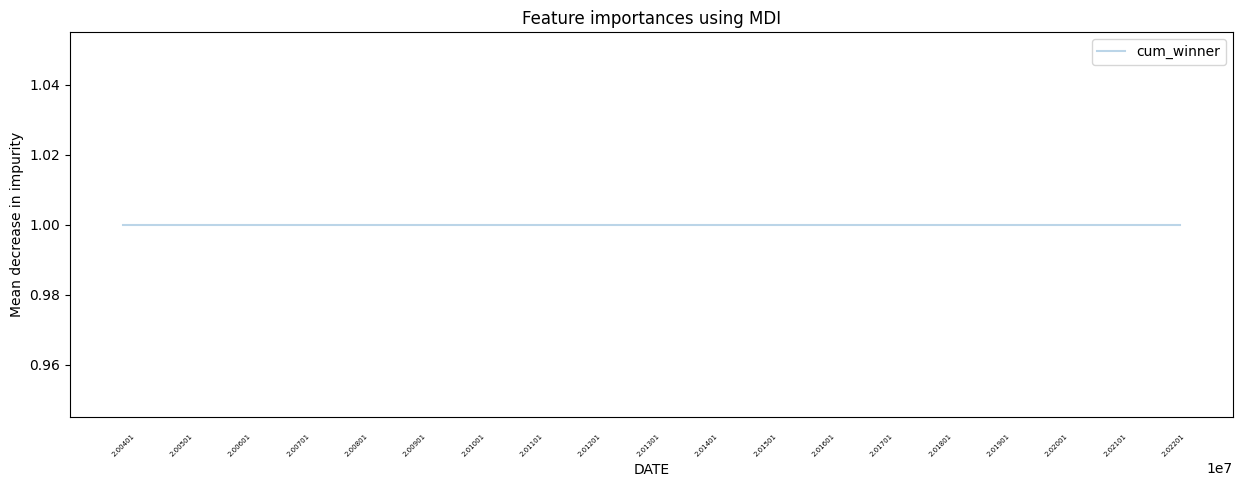

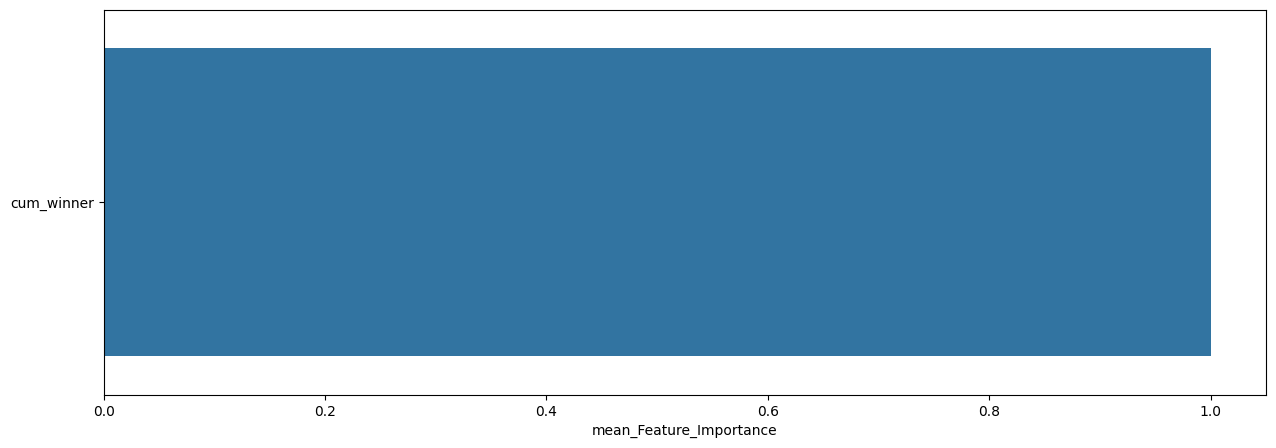

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [103]:
slice_feature_importance(Fixed_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



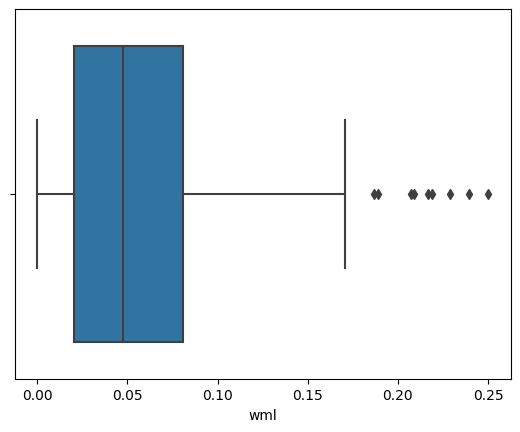

count      mean       std       min       25%       50%       75%  \
wml  413.0  0.056336  0.046085  0.000128  0.020549  0.047411  0.080744   

          max  
wml  0.250175


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



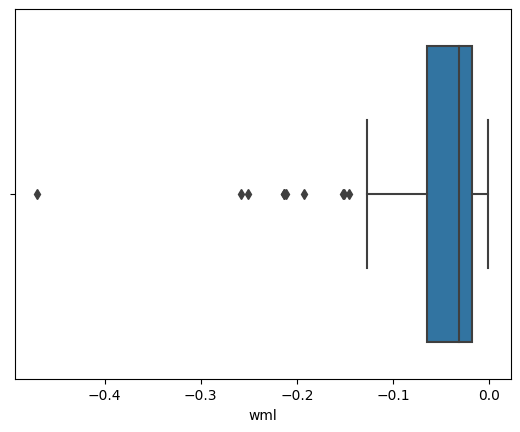

count      mean       std       min       25%       50%       75%  \
wml   89.0 -0.057507  0.073092 -0.469903 -0.064834 -0.031582 -0.018056   

          max  
wml -0.000957


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



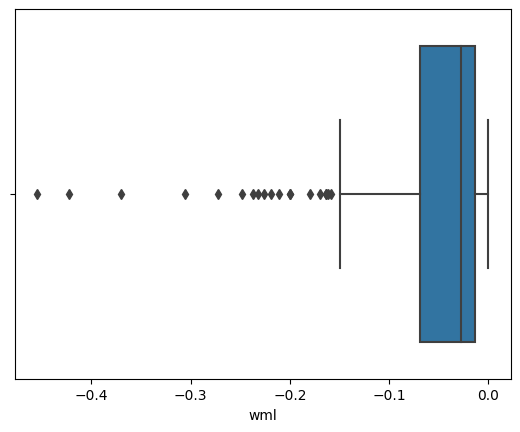

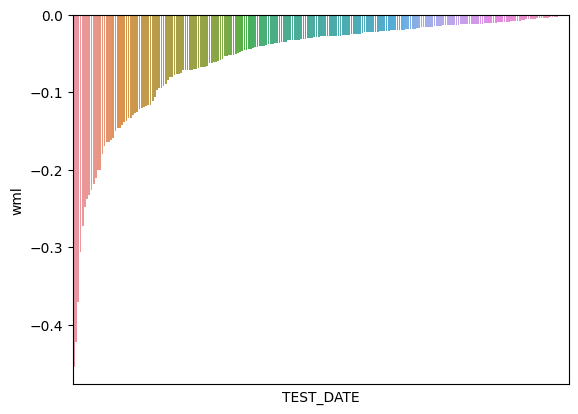

count      mean       std       min       25%       50%      75%  \
wml  227.0 -0.055842  0.070652 -0.454349 -0.068896 -0.027746 -0.01346   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



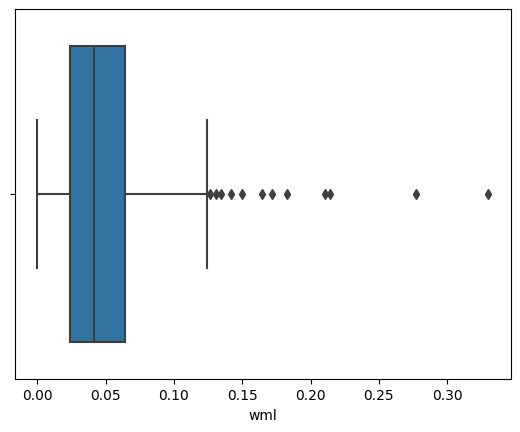

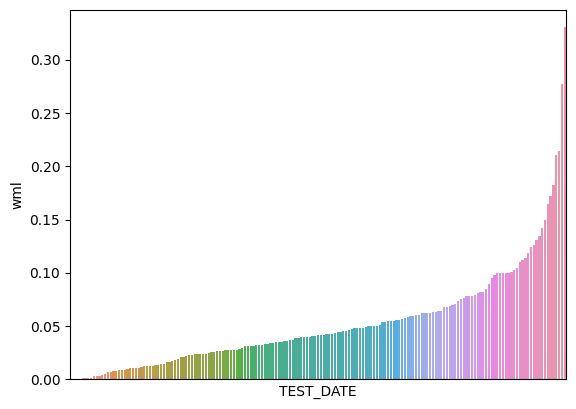

count      mean       std       min       25%       50%       75%  \
wml  177.0  0.052714  0.048501  0.000007  0.023561  0.041368  0.064195   

          max  
wml  0.330163

In [104]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Fixed_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.67891

최근 누적 수익률

  2022년-12월 -> 4745.38
  2022년-11월 -> 4745.38
  2022년-10월 -> 4513.81
  2022년-09월 -> 3996.81
  2022년-08월 -> 3996.81

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-06월 -> 13530.91
  2등 : 2002년-07월 -> 13530.91
  3등 : 2002년-08월 -> 13530.91
  4등 : 2002년-09월 -> 13530.91
  5등 : 2002년-10월 -> 13530.91
  6등 : 2009년-02월 -> 13061.36
  7등 : 2008년-11월 -> 11912.13
  8등 : 2002년-05월 -> 11634.86
  9등 : 2009년-01월 -> 11630.16
  10등 : 2008년-12월 -> 11630.16



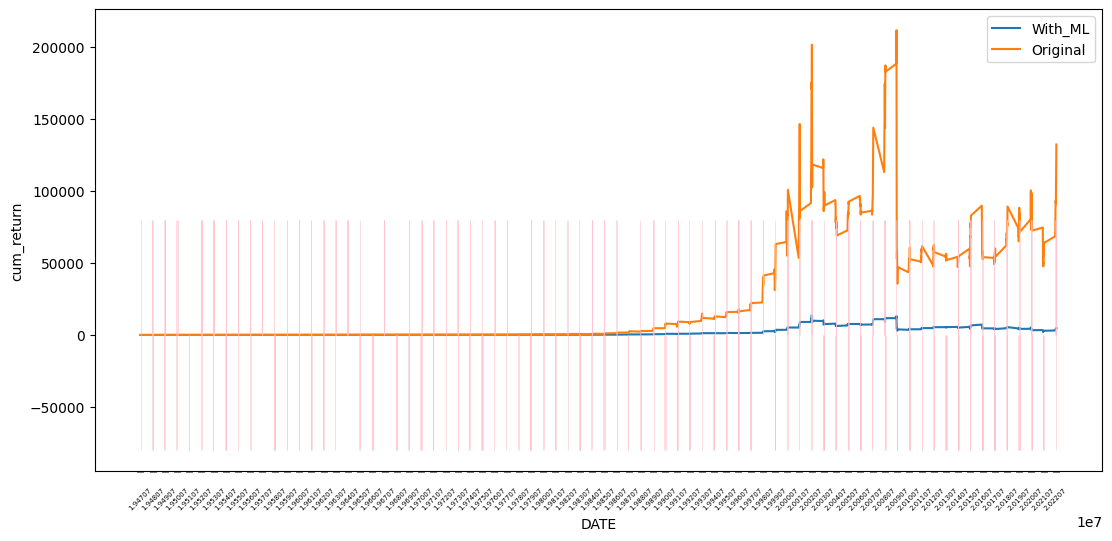

In [105]:
XGB_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.75489

최근 누적 수익률

  2022년-12월 -> 5131.08
  2022년-11월 -> 5050.25
  2022년-10월 -> 4854.40
  2022년-09월 -> 4352.61
  2022년-08월 -> 4296.90

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 7575.87
  2등 : 2002년-09월 -> 7367.42
  3등 : 2008년-11월 -> 7110.91
  4등 : 2009년-01월 -> 7101.96
  5등 : 2008년-12월 -> 7003.20
  6등 : 2002년-07월 -> 6935.14
  7등 : 2002년-06월 -> 6870.46
  8등 : 2008년-06월 -> 6850.65
  9등 : 2002년-08월 -> 6836.07
  10등 : 2002년-10월 -> 6756.41



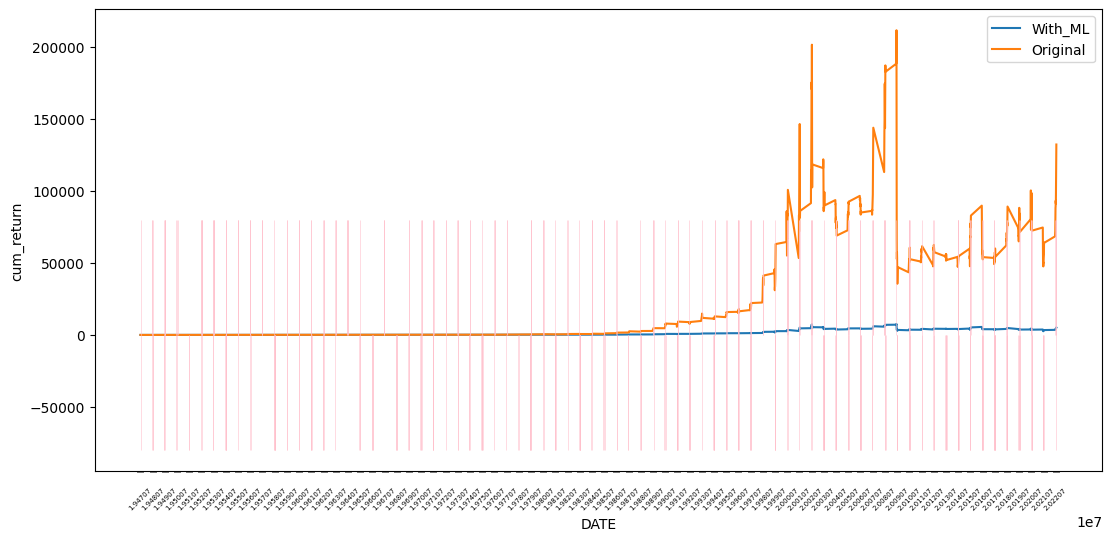

In [106]:
XGB_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [107]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.17      0.22       316
         1.0       0.64      0.79      0.71       590

    accuracy                           0.57       906
   macro avg       0.47      0.48      0.46       906
weighted avg       0.52      0.57      0.54       906


accuracy : 0.5728476821192053

precision : 0.6396148555708391

recall : 0.788135593220339

F1-Score : 0.7061503416856492



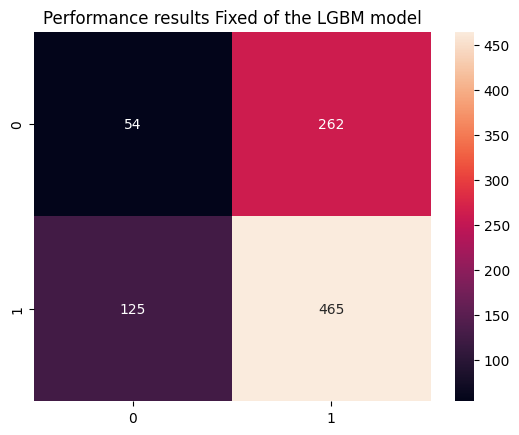


Feature Importance of the model



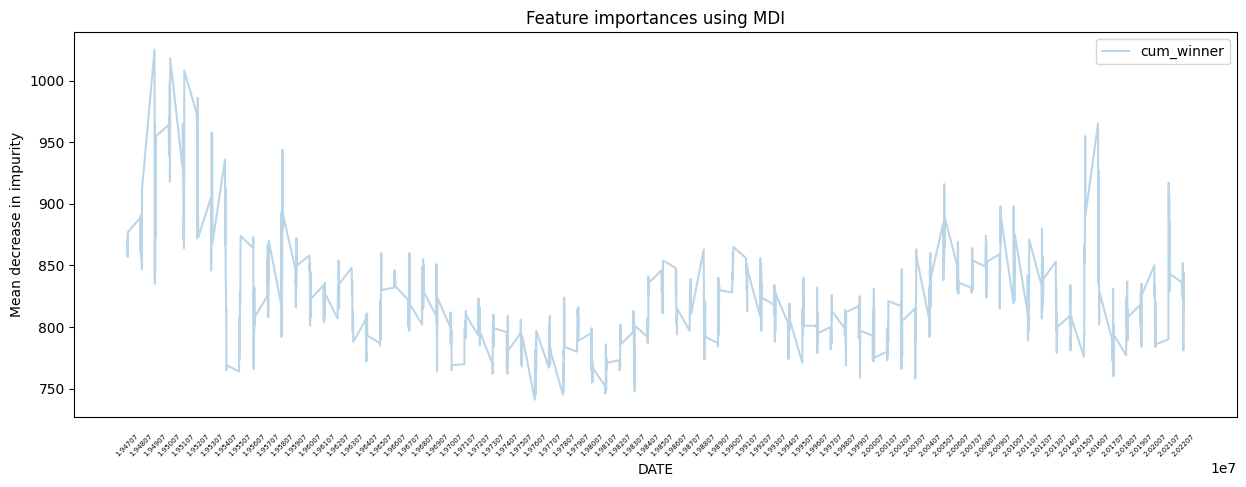

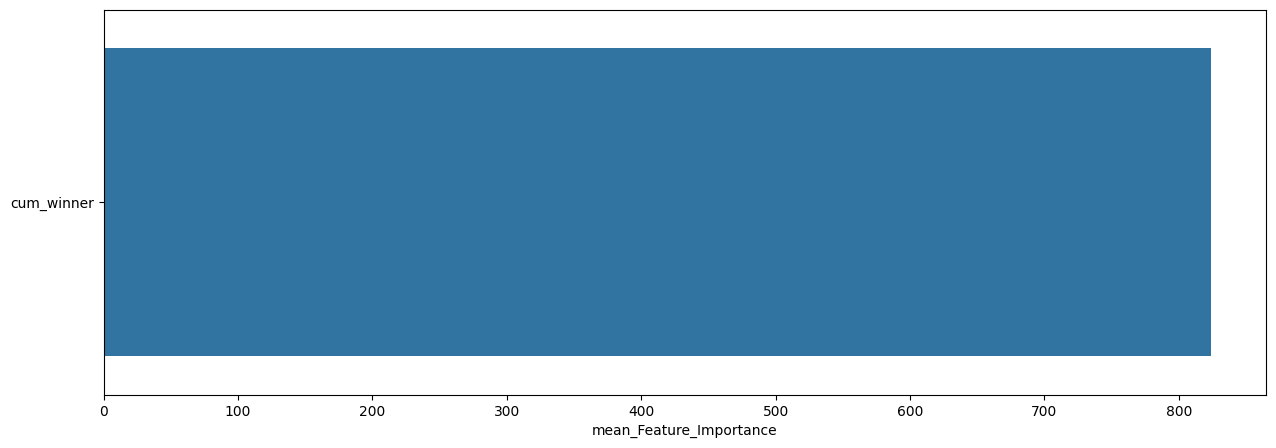

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               823.774834                    1025   

            min_Feature_Importance  
cum_winner                     741

In [108]:
Fixed_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.29      0.29      0.29        75
         1.0       0.65      0.65      0.65       151

    accuracy                           0.53       226
   macro avg       0.47      0.47      0.47       226
weighted avg       0.53      0.53      0.53       226


accuracy : 0.5309734513274337

precision : 0.6490066225165563

recall : 0.6490066225165563

F1-Score : 0.6490066225165563



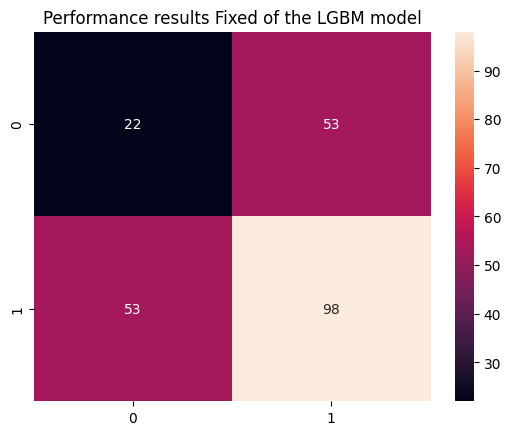


Feature Importance of the model



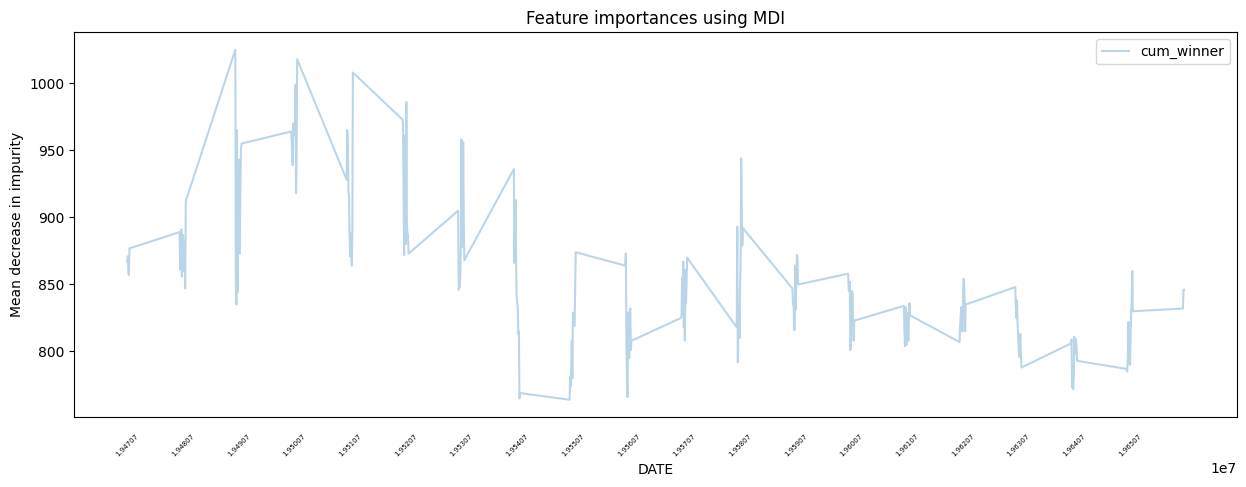

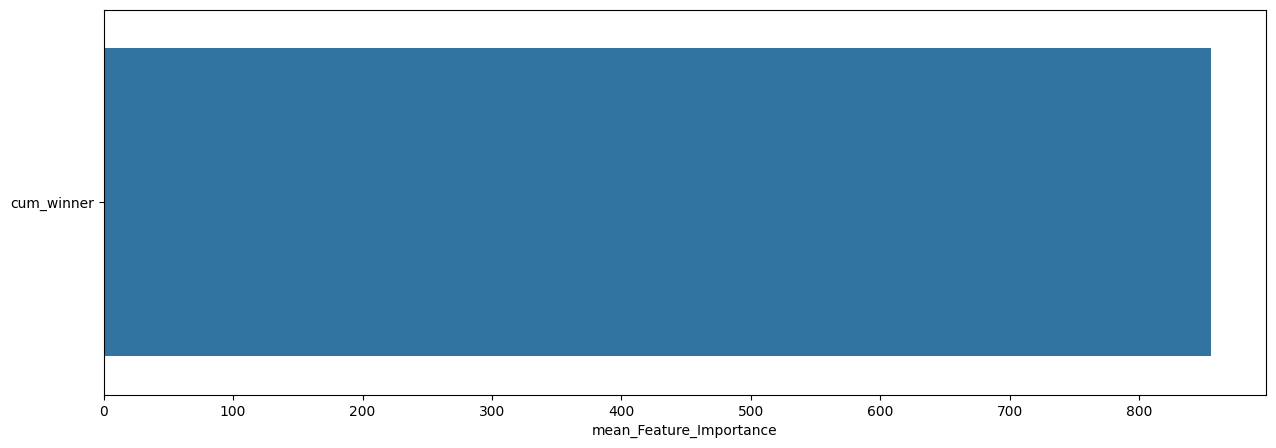

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               855.146018                    1025   

            min_Feature_Importance  
cum_winner                     764


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.20      0.04      0.07        75
         1.0       0.66      0.92      0.77       151

    accuracy                           0.63       226
   macro avg       0.43      0.48      0.42       226
weighted avg       0.51      0.63      0.54       226


accuracy : 0.6283185840707964

precision : 0.6587677725118484

recall : 0.9205298013245033

F1-Score : 0.7679558011049724



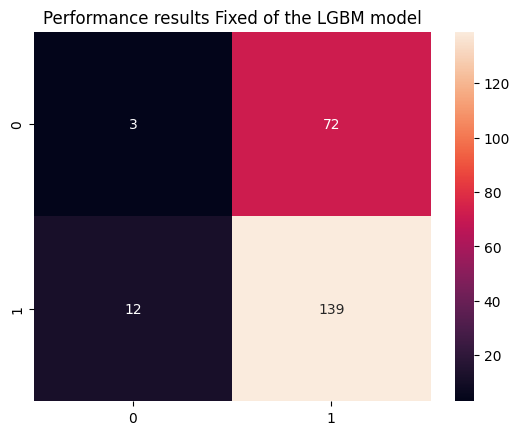


Feature Importance of the model



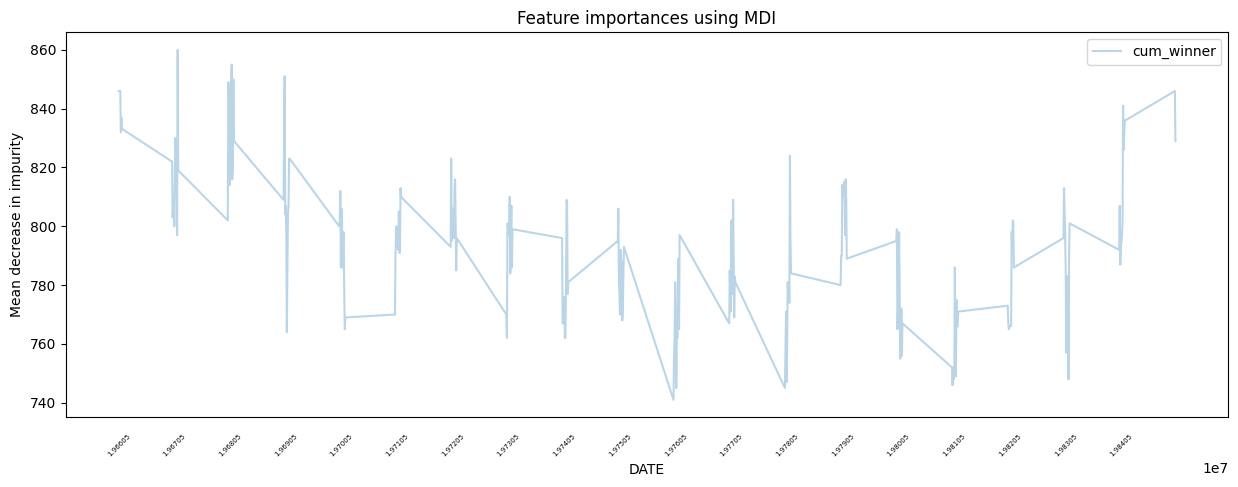

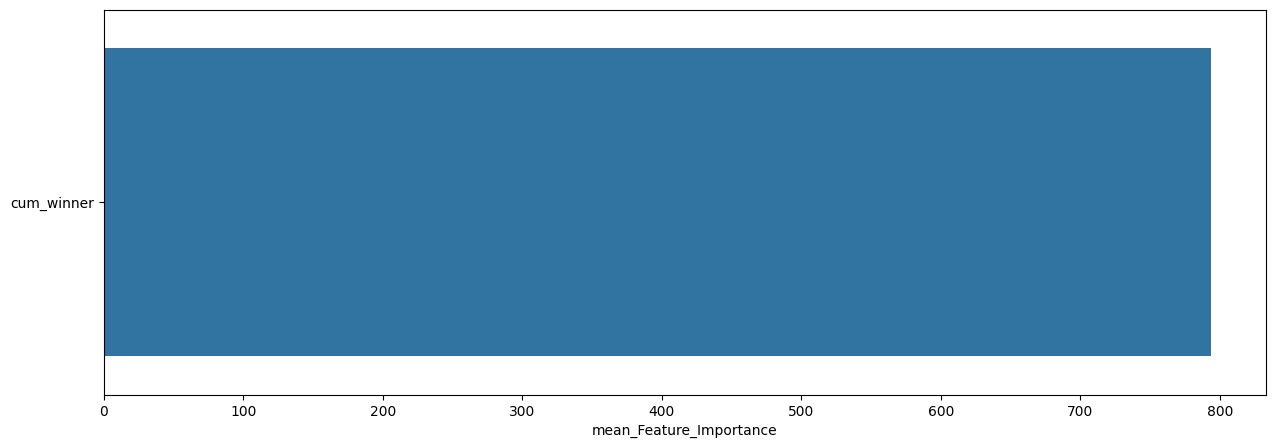

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               793.429204                     860   

            min_Feature_Importance  
cum_winner                     741


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.27      0.10      0.15        70
         1.0       0.69      0.88      0.77       156

    accuracy                           0.64       226
   macro avg       0.48      0.49      0.46       226
weighted avg       0.56      0.64      0.58       226


accuracy : 0.6371681415929203

precision : 0.685

recall : 0.8782051282051282

F1-Score : 0.7696629213483147



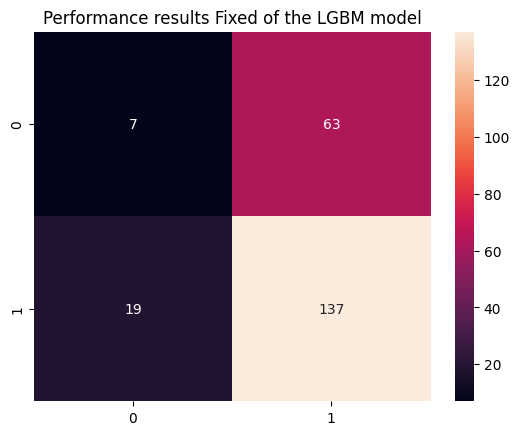


Feature Importance of the model



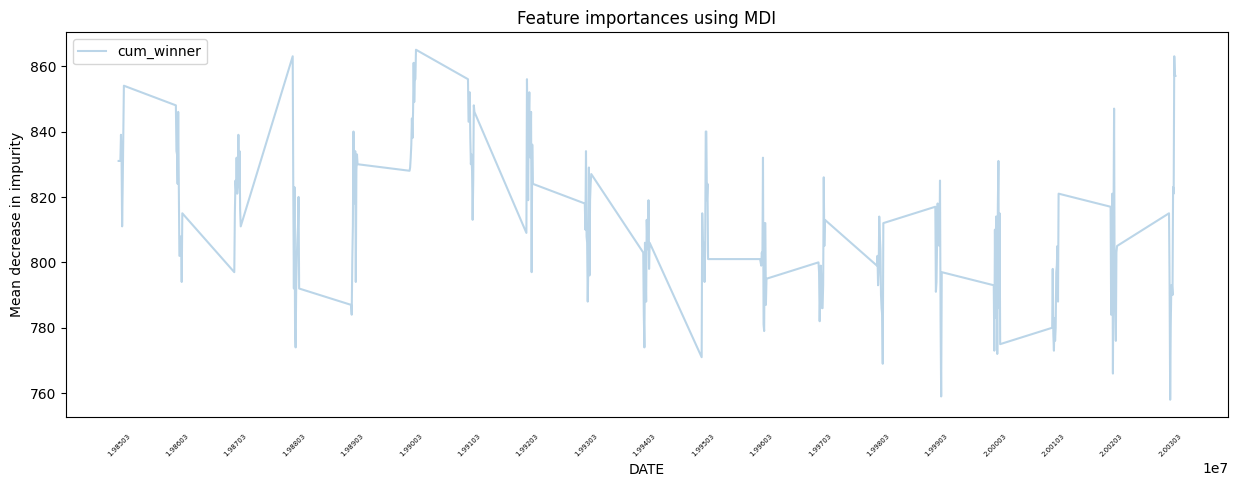

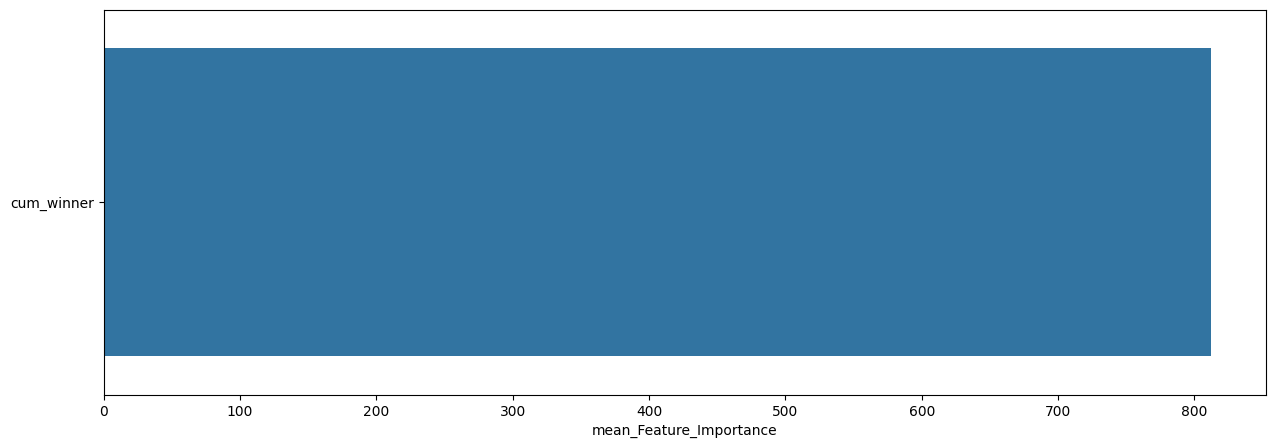

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               811.911504                     865   

            min_Feature_Importance  
cum_winner                     758


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.23      0.28        96
         1.0       0.55      0.69      0.61       132

    accuracy                           0.50       228
   macro avg       0.45      0.46      0.44       228
weighted avg       0.47      0.50      0.47       228


accuracy : 0.4956140350877193

precision : 0.5515151515151515

recall : 0.6893939393939394

F1-Score : 0.6127946127946129



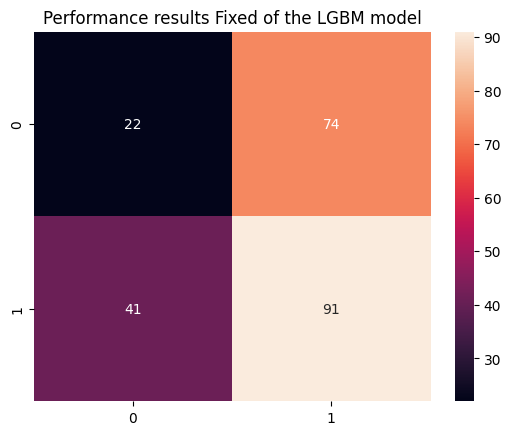


Feature Importance of the model



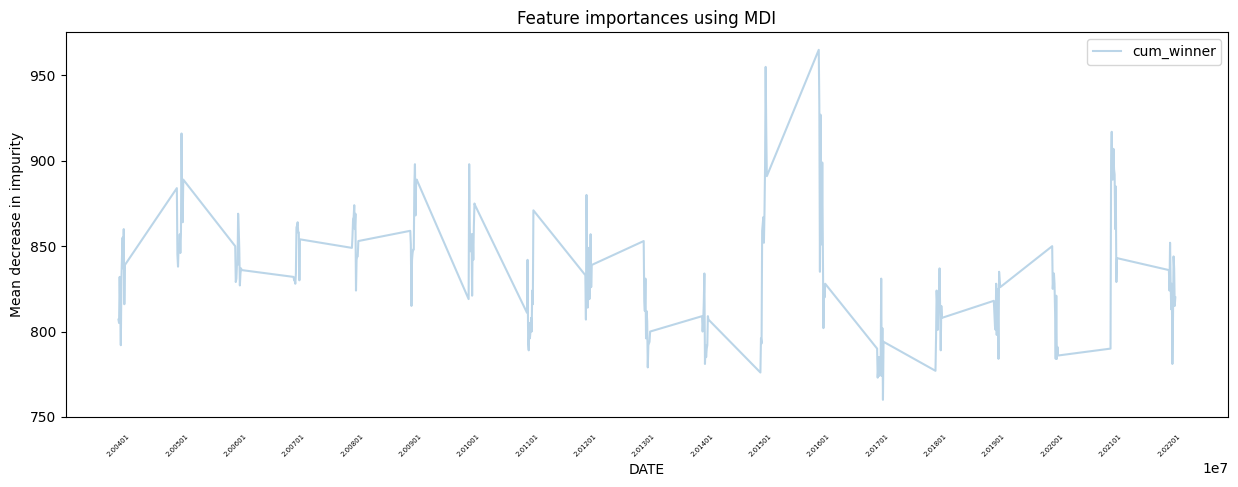

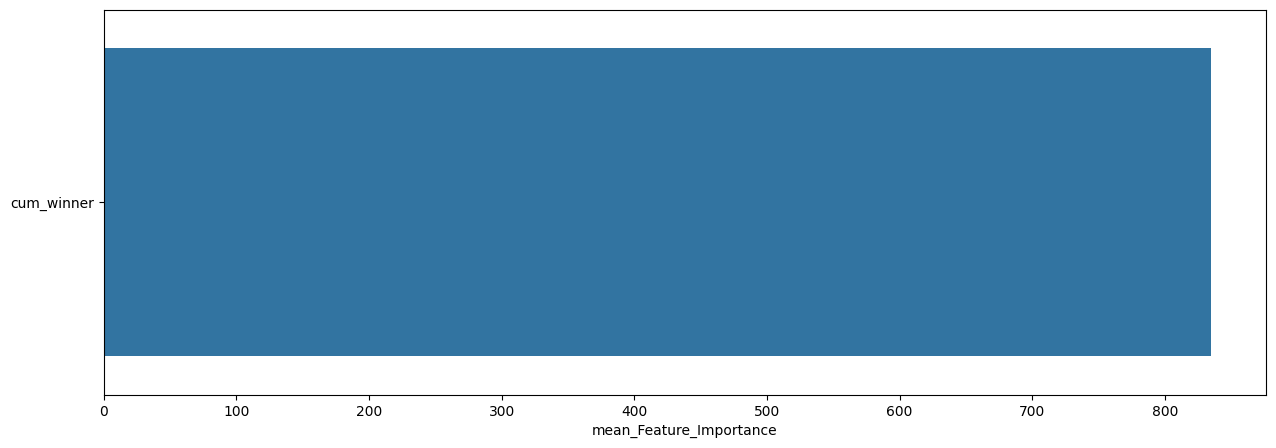

mean_Feature_Importance  max_Feature_Importance  \
cum_winner               834.517544                     965   

            min_Feature_Importance  
cum_winner                     760

In [109]:
slice_feature_importance(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Fixed', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



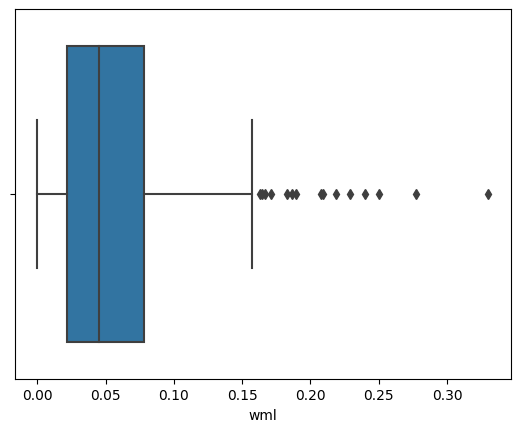

count      mean       std       min       25%       50%       75%  \
wml  465.0  0.056098  0.047032  0.000128  0.022009  0.045557  0.078379   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



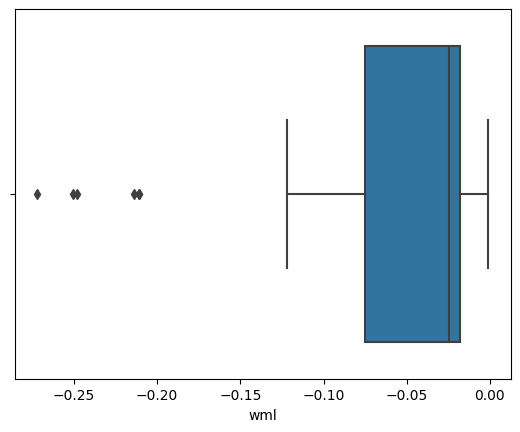

count      mean       std       min       25%       50%       75%  \
wml   54.0 -0.057552  0.069941 -0.271971 -0.075261 -0.024723 -0.017908   

          max  
wml -0.000957


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



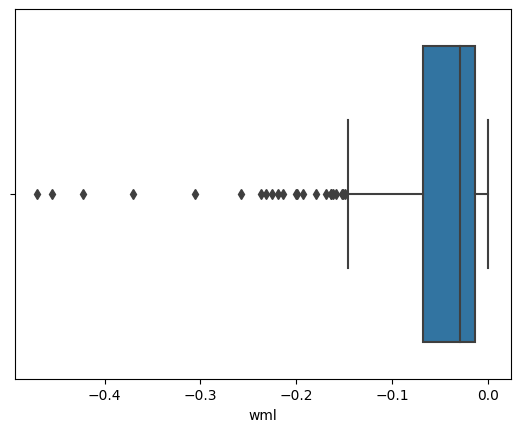

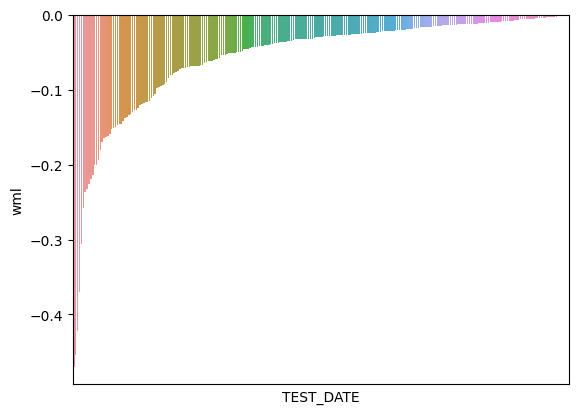

count      mean       std       min       25%       50%       75%  \
wml  262.0 -0.056055  0.071628 -0.469903 -0.067781 -0.029177 -0.013984   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



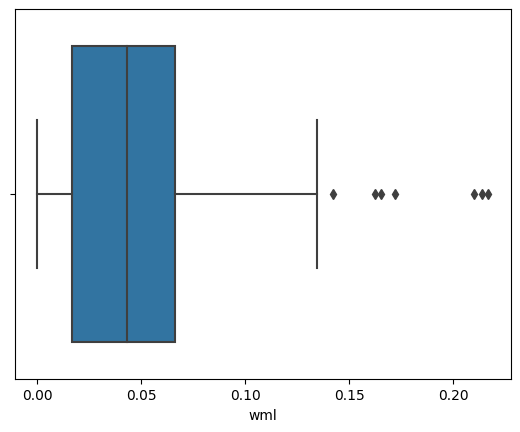

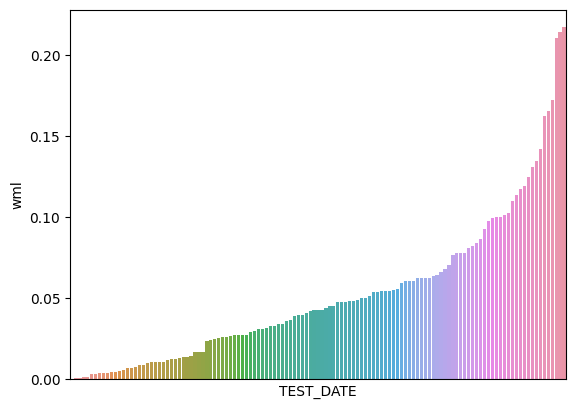

count      mean       std       min       25%       50%      75%  \
wml  125.0  0.052095  0.046029  0.000007  0.016722  0.042914  0.06612   

          max  
wml  0.216883

In [110]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Fixed_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.76451

최근 누적 수익률

  2022년-12월 -> 7479.41
  2022년-11월 -> 7479.41
  2022년-10월 -> 7479.41
  2022년-09월 -> 6622.81
  2022년-08월 -> 6622.81

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 15921.26
  2등 : 2002년-09월 -> 15239.11
  3등 : 2009년-01월 -> 14176.71
  4등 : 2008년-11월 -> 14084.24
  5등 : 2008년-12월 -> 13750.85
  6등 : 2002년-07월 -> 13269.91
  7등 : 2002년-06월 -> 13269.91
  8등 : 2008년-06월 -> 13132.15
  9등 : 2002년-08월 -> 12885.44
  10등 : 2008년-10월 -> 12843.56



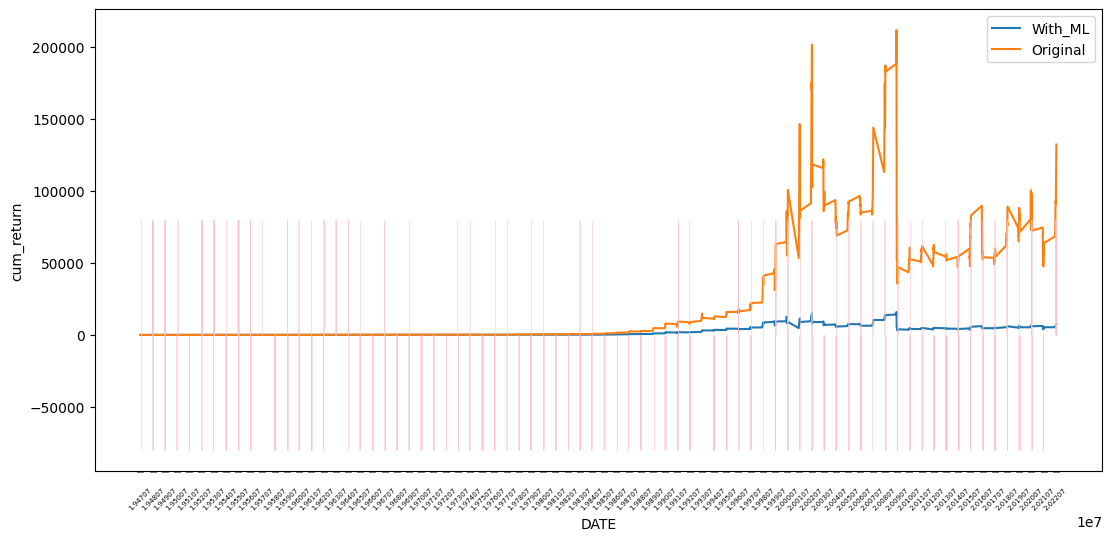

In [111]:
LGBM_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.76209

최근 누적 수익률

  2022년-12월 -> 5481.85
  2022년-11월 -> 5231.17
  2022년-10월 -> 5108.42
  2022년-09월 -> 4646.78
  2022년-08월 -> 4513.99

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 6319.17
  2등 : 2002년-09월 -> 5928.45
  3등 : 2009년-01월 -> 5878.84
  4등 : 2008년-11월 -> 5868.96
  5등 : 2008년-12월 -> 5781.50
  6등 : 2008년-06월 -> 5599.37
  7등 : 2008년-10월 -> 5540.59
  8등 : 2022년-12월 -> 5481.85
  9등 : 2002년-07월 -> 5348.85
  10등 : 2008년-09월 -> 5346.24



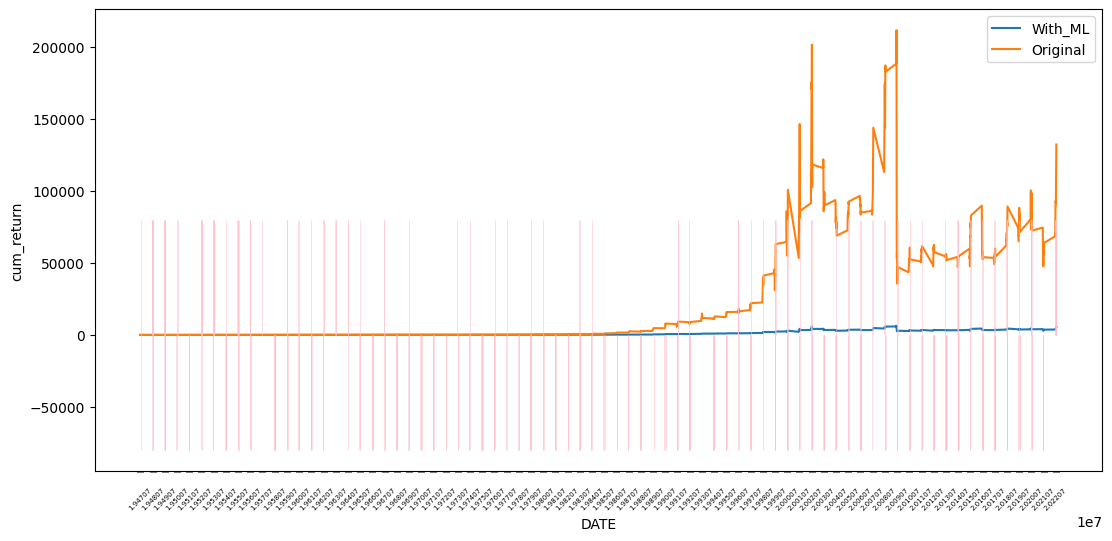

In [112]:
LGBM_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

## Rolling Expanding Windows

### Random Forest

In [113]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.33      0.33       316
         1.0       0.64      0.65      0.65       590

    accuracy                           0.54       906
   macro avg       0.49      0.49      0.49       906
weighted avg       0.54      0.54      0.54       906


accuracy : 0.5375275938189845

precision : 0.6436974789915967

recall : 0.6491525423728813

F1-Score : 0.6464135021097047



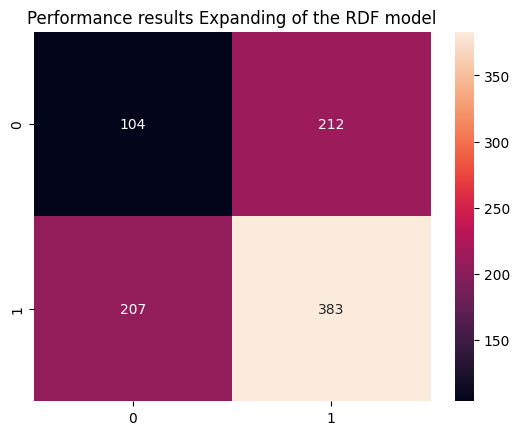


Feature Importance of the model



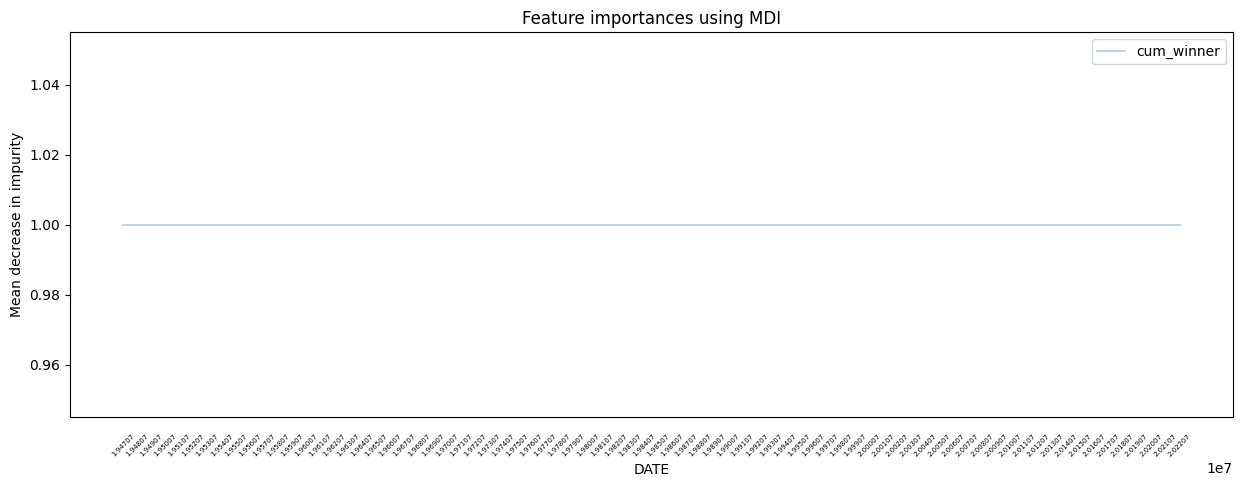

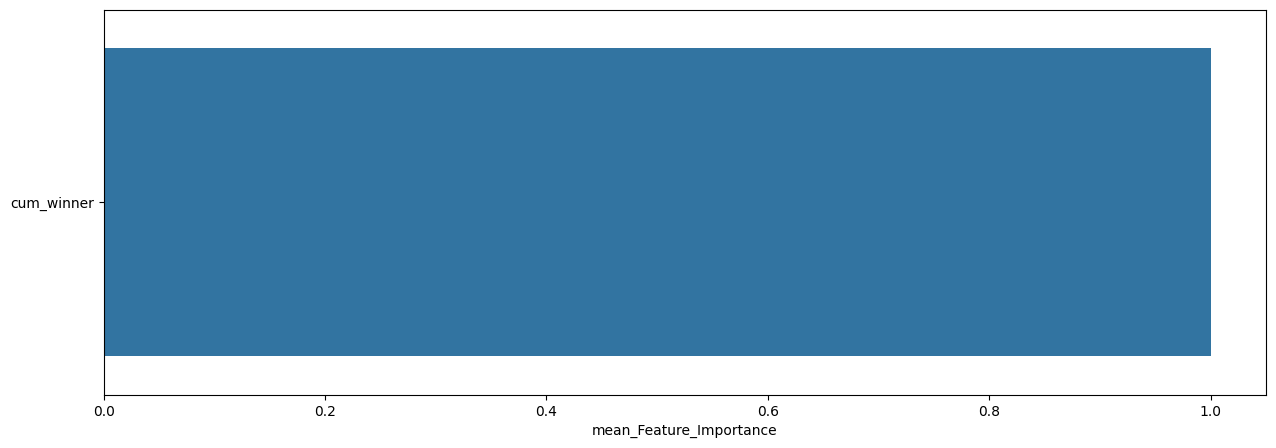

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [114]:
Expanding_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=RDF, # 사용할 모델
                                      model_name='RDF', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.40      0.39        75
         1.0       0.70      0.68      0.69       151

    accuracy                           0.59       226
   macro avg       0.54      0.54      0.54       226
weighted avg       0.59      0.59      0.59       226


accuracy : 0.588495575221239

precision : 0.6959459459459459

recall : 0.6821192052980133

F1-Score : 0.6889632107023412



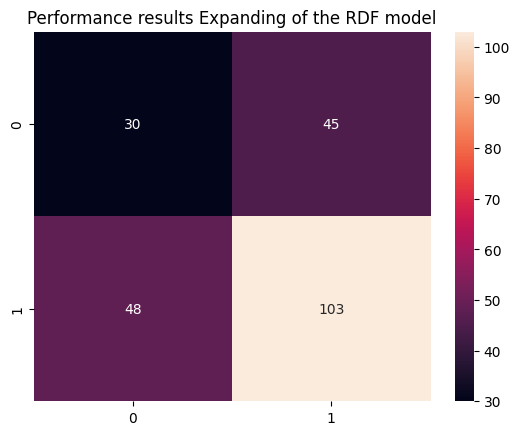


Feature Importance of the model



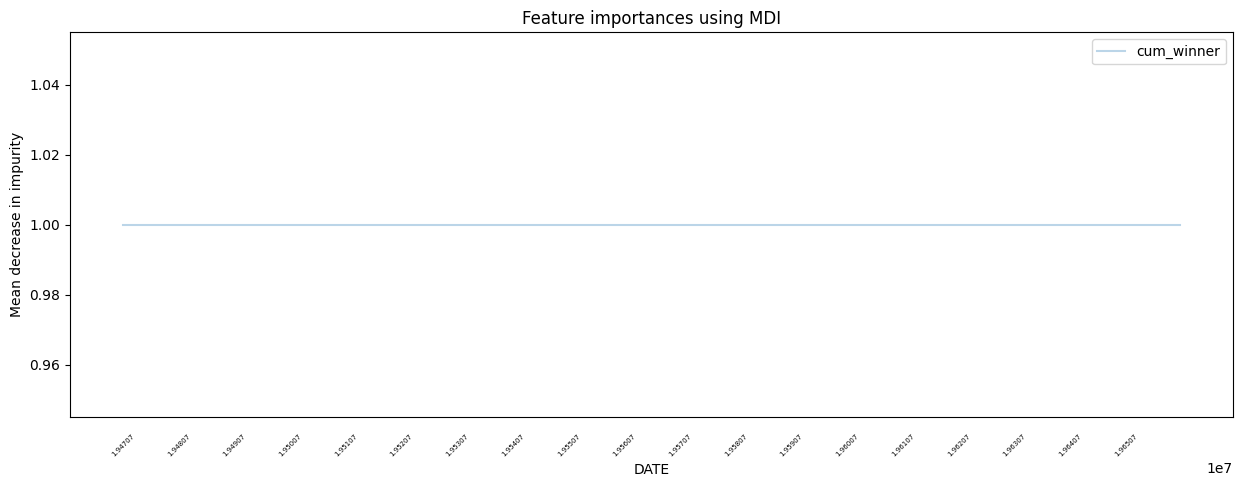

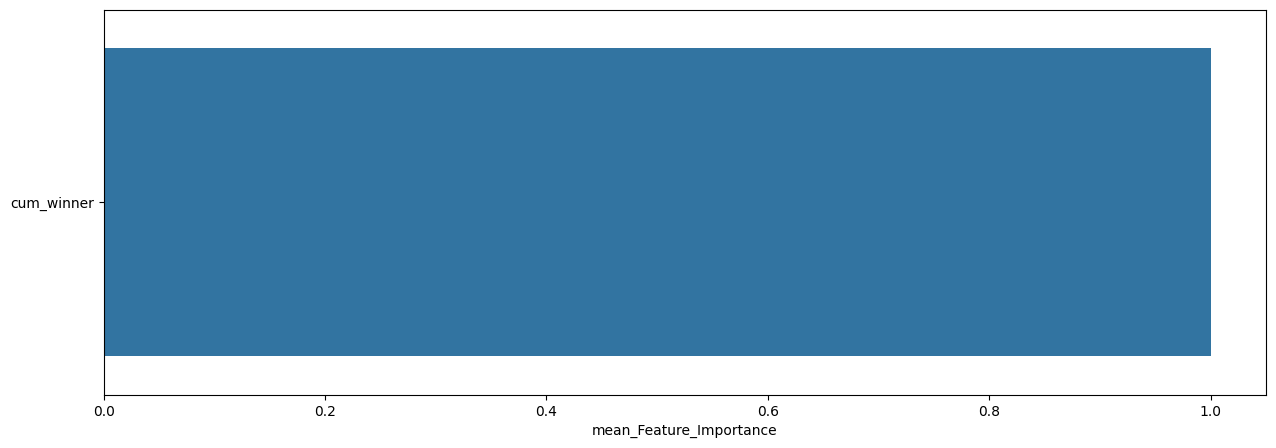

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.35      0.34        75
         1.0       0.67      0.65      0.66       151

    accuracy                           0.55       226
   macro avg       0.50      0.50      0.50       226
weighted avg       0.55      0.55      0.55       226


accuracy : 0.5486725663716814

precision : 0.6666666666666666

recall : 0.6490066225165563

F1-Score : 0.6577181208053691



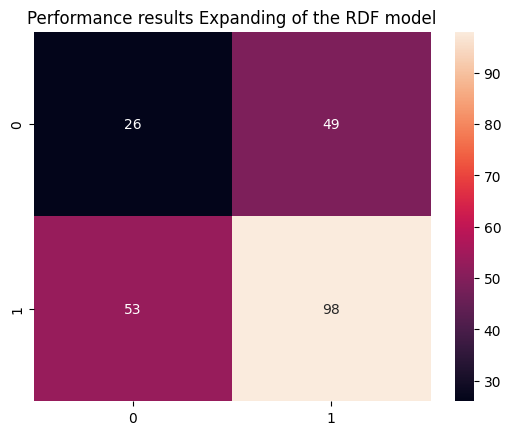


Feature Importance of the model



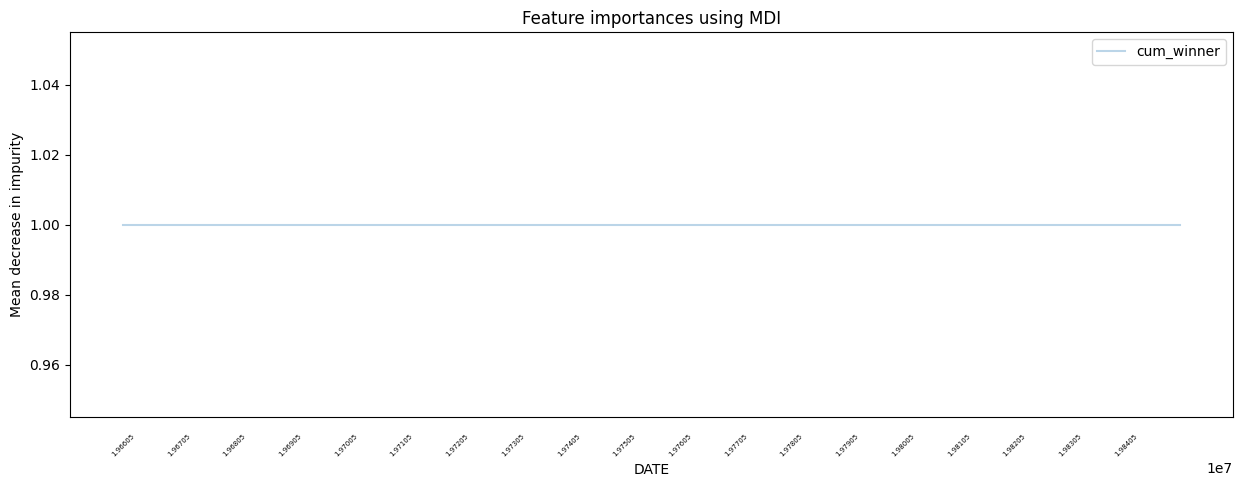

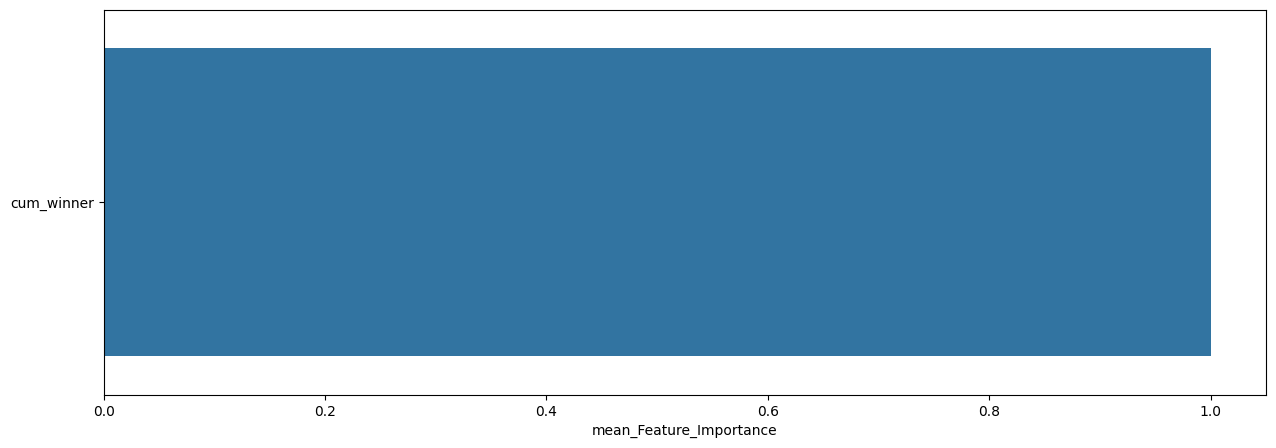

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.27      0.29      0.28        70
         1.0       0.67      0.65      0.66       156

    accuracy                           0.54       226
   macro avg       0.47      0.47      0.47       226
weighted avg       0.54      0.54      0.54       226


accuracy : 0.5353982300884956

precision : 0.6688741721854304

recall : 0.6474358974358975

F1-Score : 0.6579804560260586



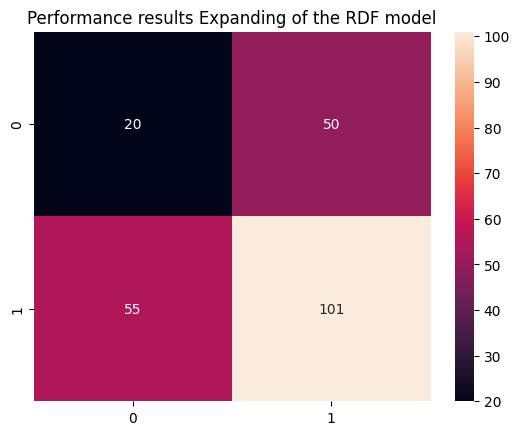


Feature Importance of the model



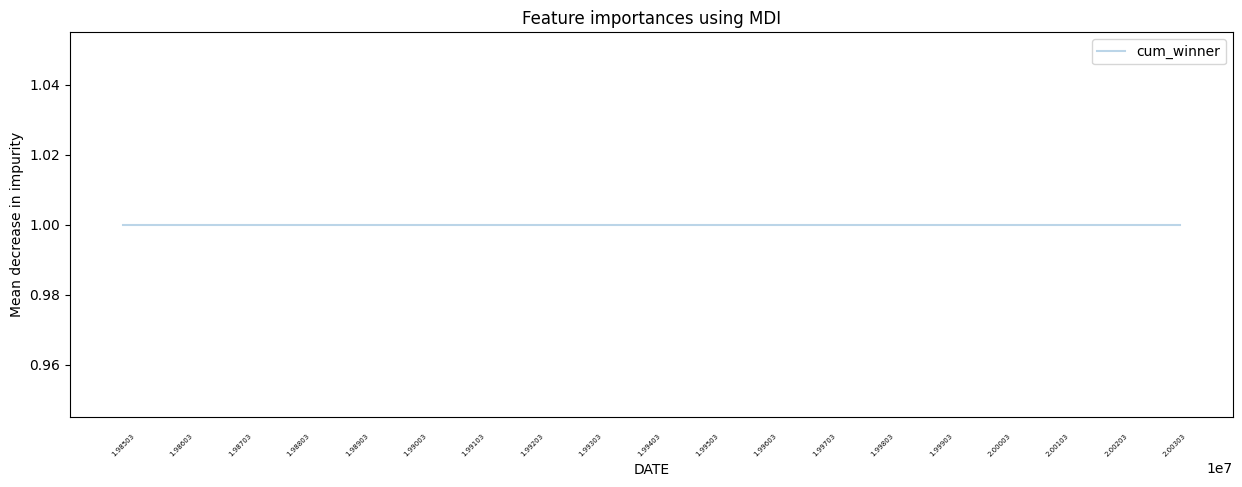

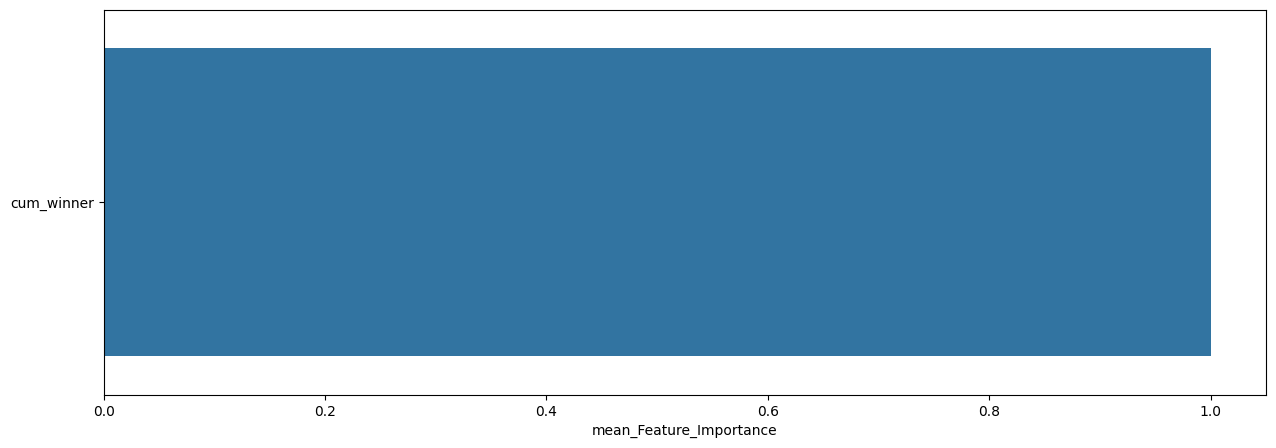

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.29      0.32        96
         1.0       0.54      0.61      0.58       132

    accuracy                           0.48       228
   macro avg       0.45      0.45      0.45       228
weighted avg       0.46      0.48      0.47       228


accuracy : 0.4780701754385965

precision : 0.5436241610738255

recall : 0.6136363636363636

F1-Score : 0.5765124555160143



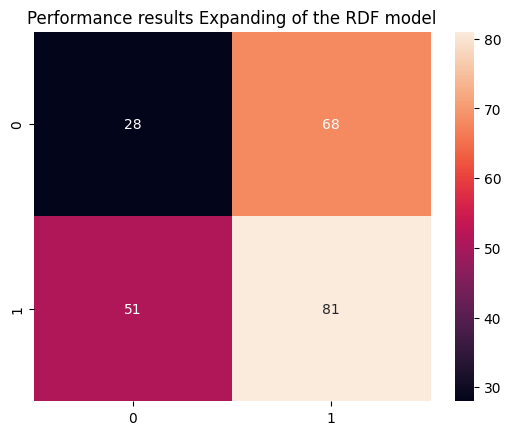


Feature Importance of the model



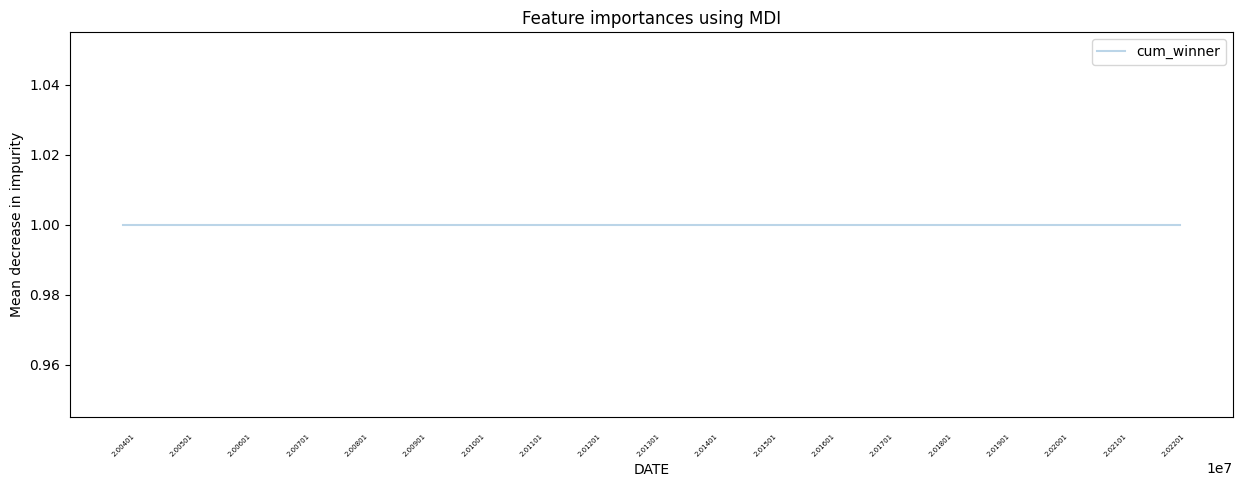

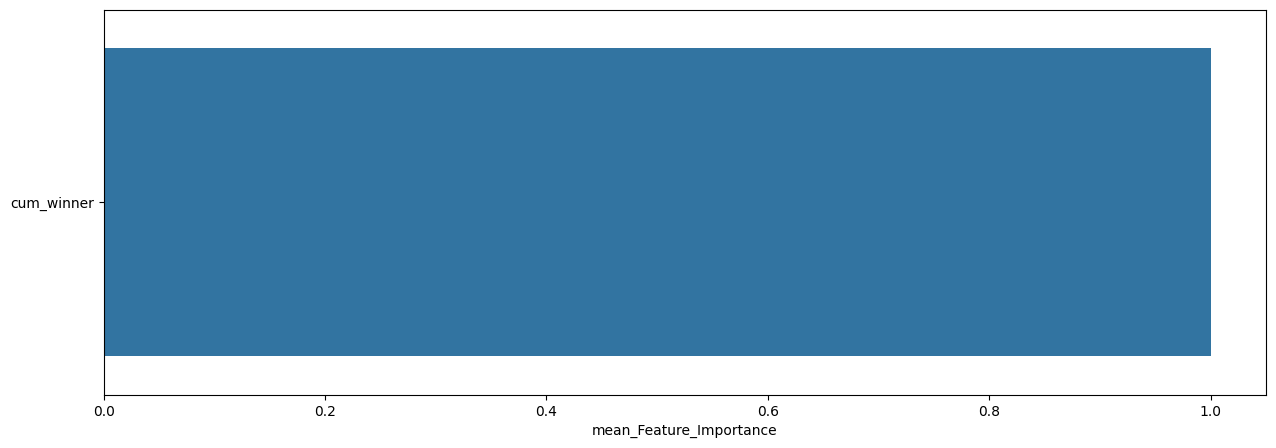

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [115]:
slice_feature_importance(Expanding_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



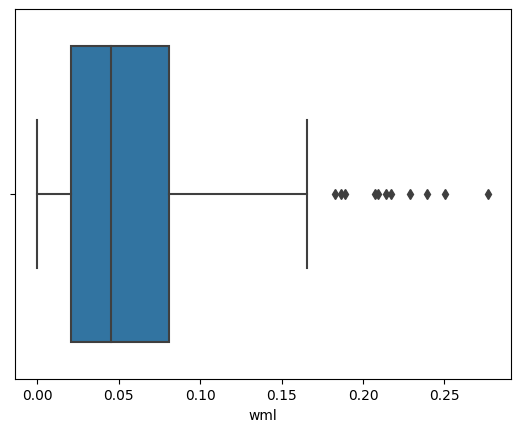

count      mean      std       min       25%       50%       75%  \
wml  383.0  0.056186  0.04773  0.000128  0.020516  0.045201  0.080768   

          max  
wml  0.276912


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



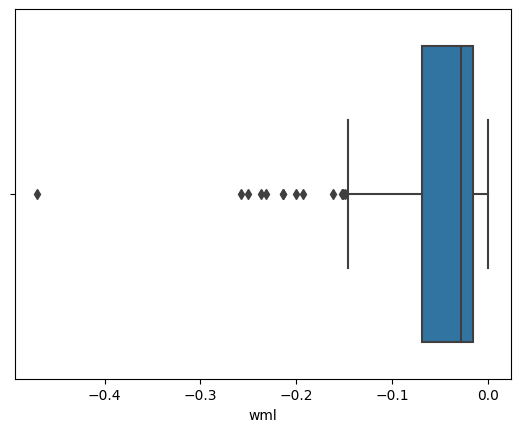

count    mean       std       min       25%       50%      75%       max
wml  104.0 -0.0597  0.074543 -0.469903 -0.069073 -0.028323 -0.01592 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



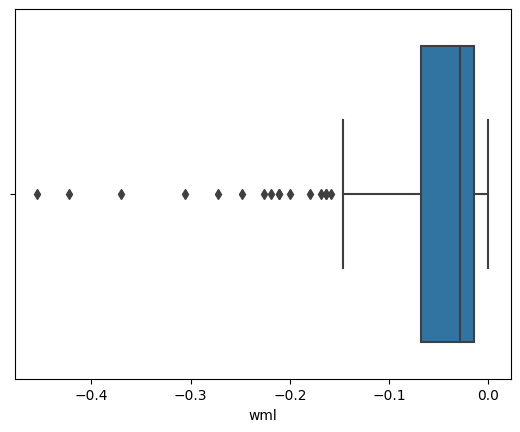

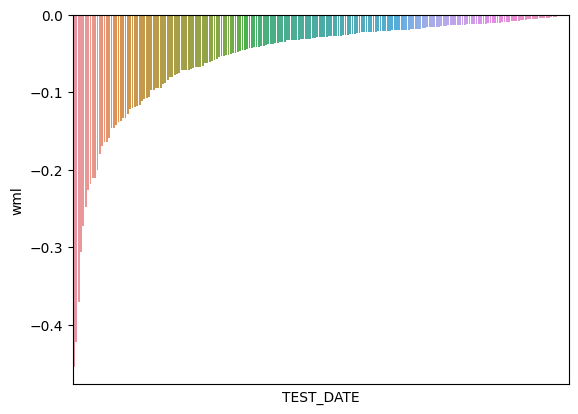

count      mean       std       min       25%       50%       75%  \
wml  212.0 -0.054649  0.069676 -0.454349 -0.067829 -0.028699 -0.014364   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



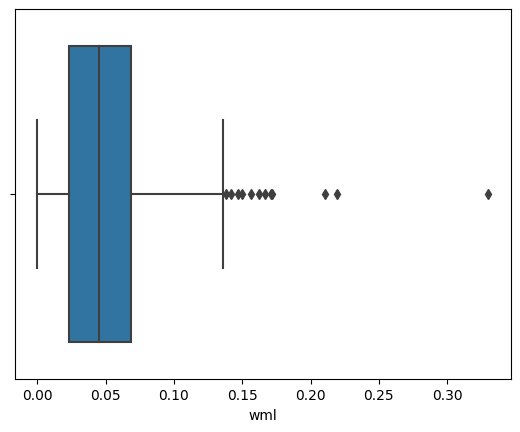

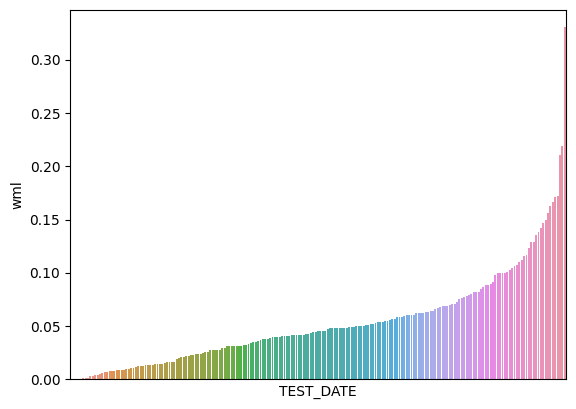

count      mean       std       min       25%      50%       75%  \
wml  207.0  0.053518  0.045124  0.000007  0.023337  0.04498  0.068607   

          max  
wml  0.330163

In [116]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Expanding_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.63564

최근 누적 수익률

  2022년-12월 -> 2874.46
  2022년-11월 -> 2874.46
  2022년-10월 -> 2734.17
  2022년-09월 -> 2734.17
  2022년-08월 -> 2485.68

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 13459.96
  2등 : 2002년-10월 -> 13459.96
  3등 : 2002년-07월 -> 11720.65
  4등 : 2002년-06월 -> 11720.65
  5등 : 2002년-08월 -> 11381.06
  6등 : 2008년-11월 -> 10931.06
  7등 : 2009년-02월 -> 10672.31
  8등 : 2009년-01월 -> 10672.31
  9등 : 2008년-12월 -> 10672.31
  10등 : 2008년-06월 -> 10192.11



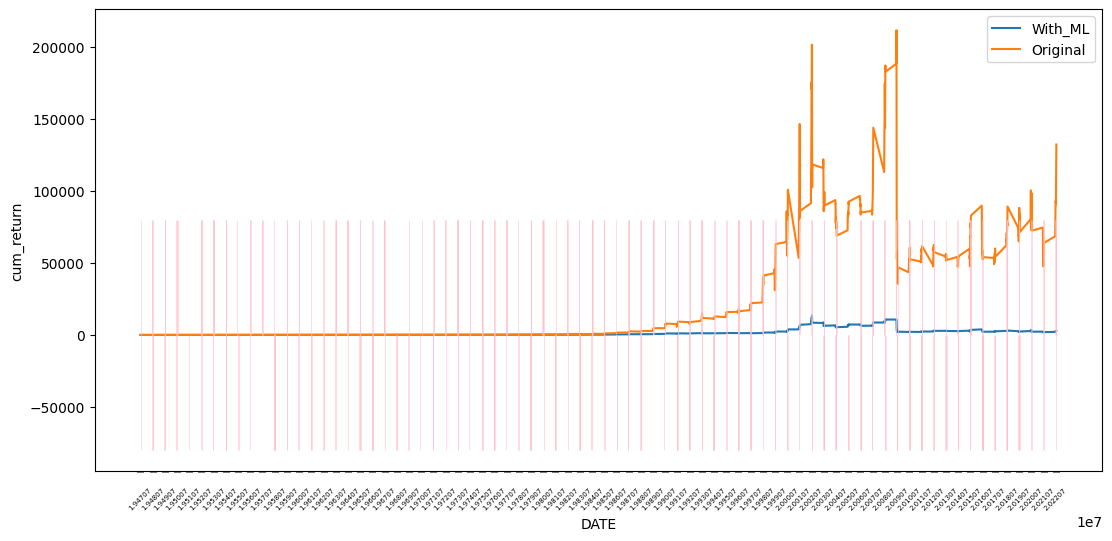

In [117]:
RDF_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.69044

최근 누적 수익률

  2022년-12월 -> 5332.52
  2022년-11월 -> 5280.28
  2022년-10월 -> 5042.30
  2022년-09월 -> 4872.14
  2022년-08월 -> 4532.38

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 13236.59
  2등 : 2002년-10월 -> 12418.42
  3등 : 2002년-07월 -> 12112.64
  4등 : 2002년-06월 -> 12106.02
  5등 : 2002년-08월 -> 11793.29
  6등 : 2009년-02월 -> 11147.69
  7등 : 2008년-11월 -> 10822.97
  8등 : 2009년-01월 -> 10725.34
  9등 : 2008년-12월 -> 10610.33
  10등 : 2002년-05월 -> 10409.63



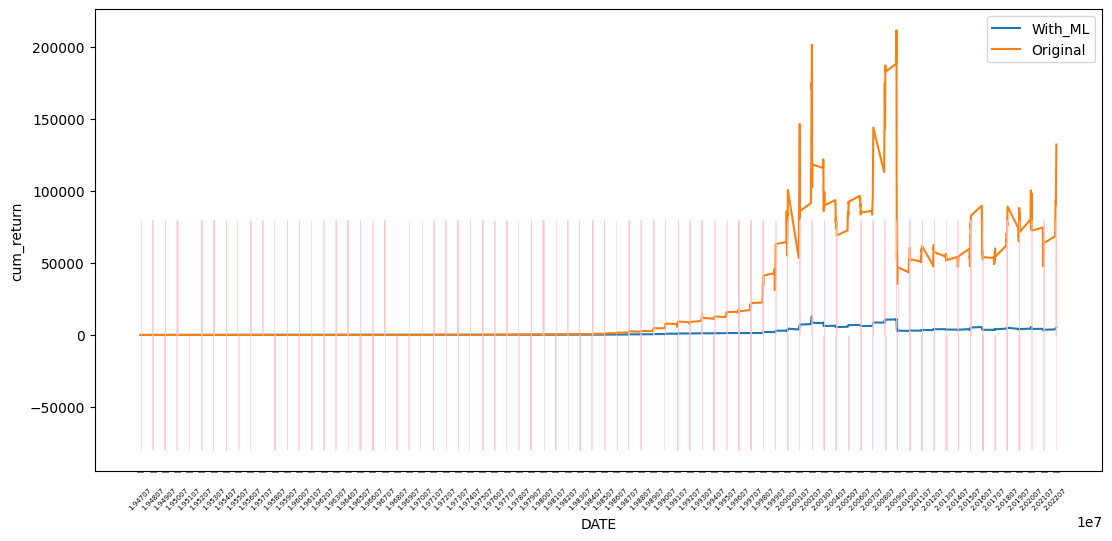

In [118]:
RDF_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [119]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.15      0.22       316
         1.0       0.66      0.88      0.75       590

    accuracy                           0.62       906
   macro avg       0.53      0.51      0.48       906
weighted avg       0.57      0.62      0.57       906


accuracy : 0.6236203090507726

precision : 0.6581956797966964

recall : 0.8779661016949153

F1-Score : 0.7523602033405955



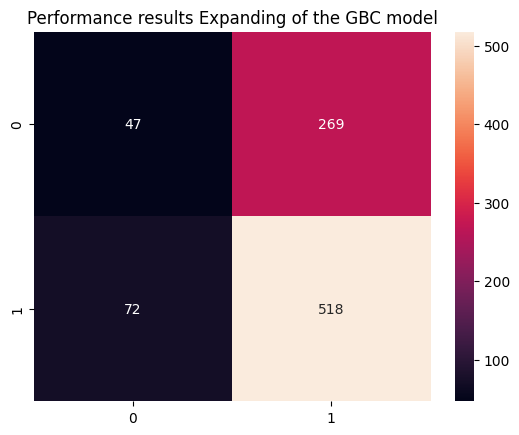


Feature Importance of the model



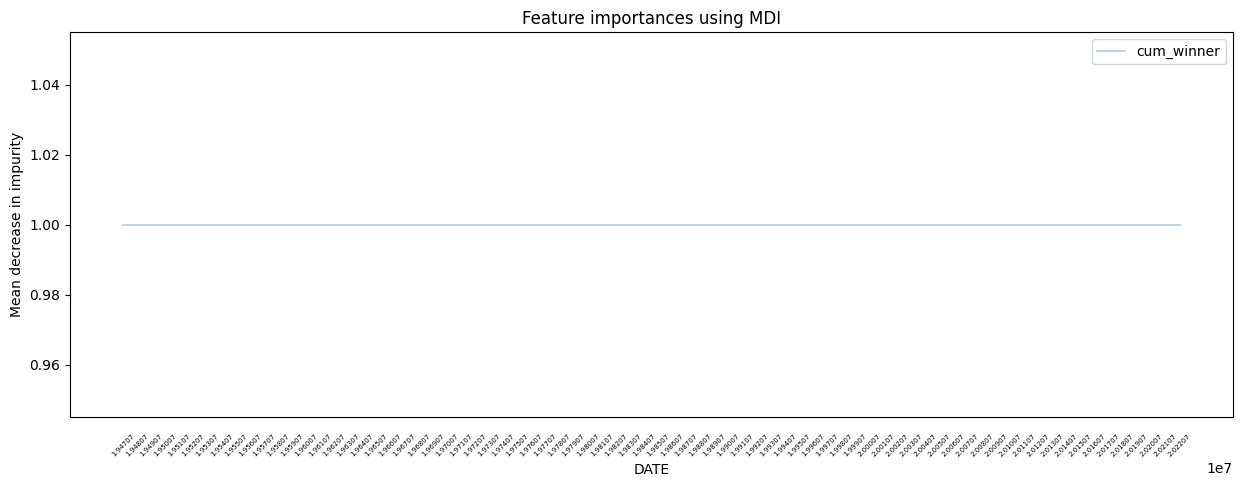

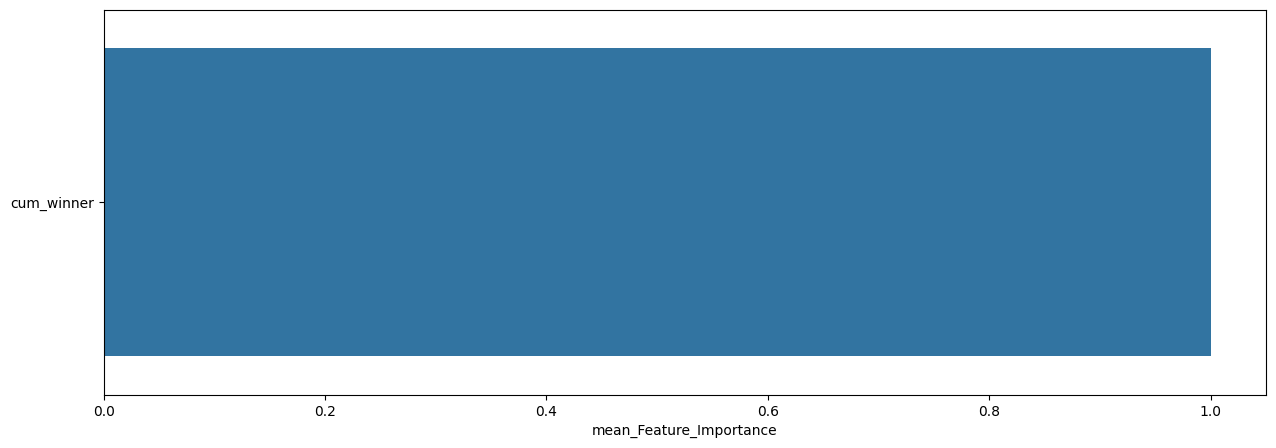

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [120]:
Expanding_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=GBC, # 사용할 모델
                                      model_name='GBC', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.40      0.29      0.34        75
         1.0       0.69      0.78      0.73       151

    accuracy                           0.62       226
   macro avg       0.55      0.54      0.54       226
weighted avg       0.59      0.62      0.60       226


accuracy : 0.6194690265486725

precision : 0.6900584795321637

recall : 0.7814569536423841

F1-Score : 0.732919254658385



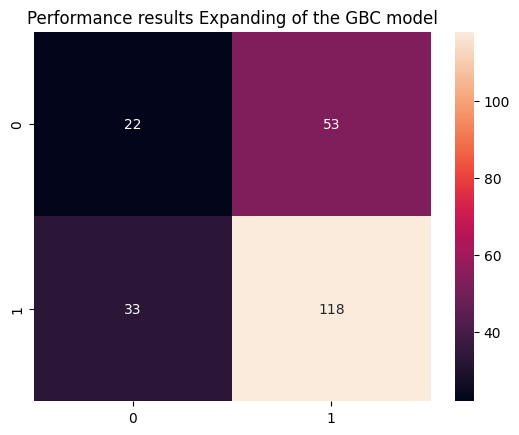


Feature Importance of the model



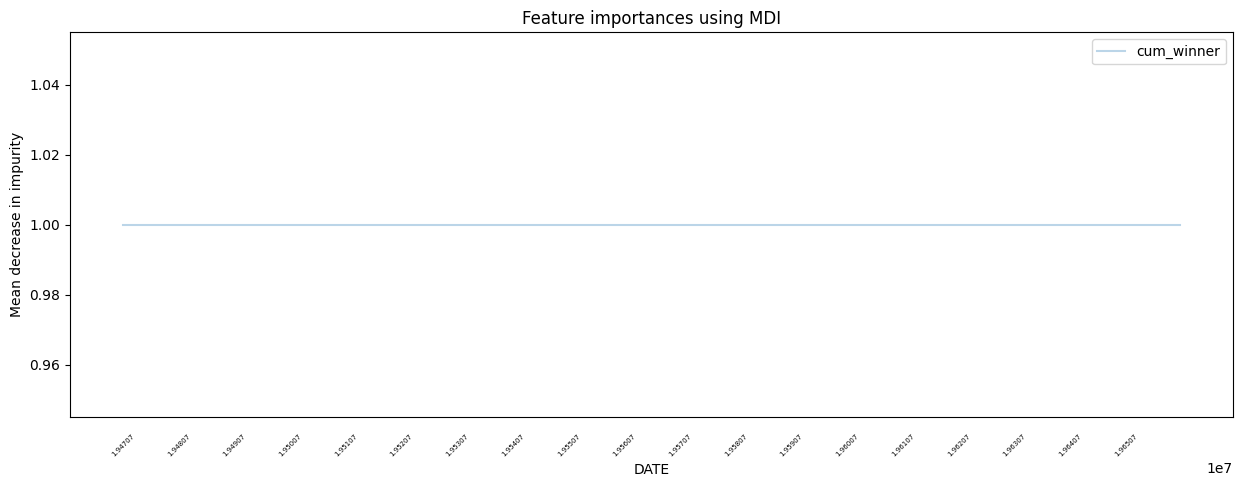

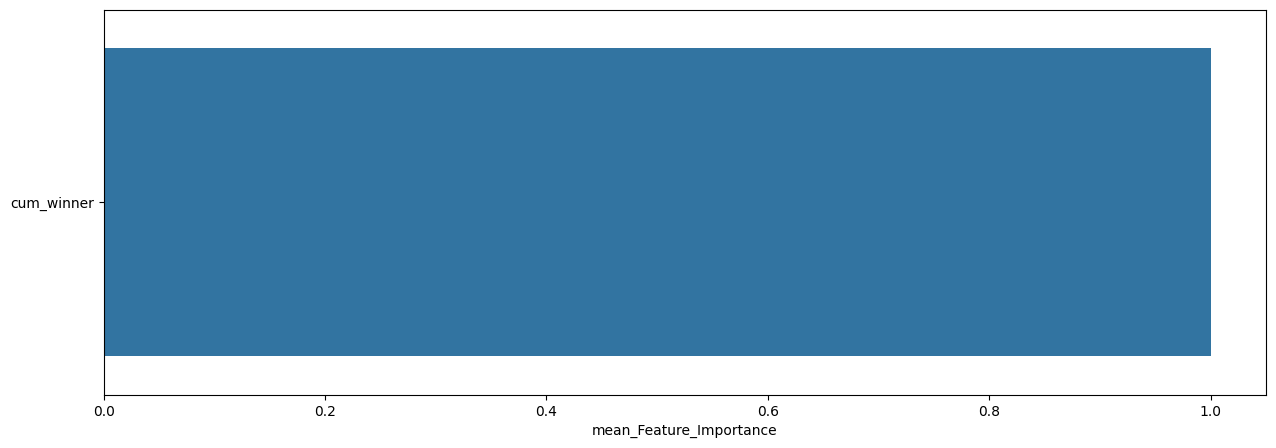

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.50      0.16      0.24        75
         1.0       0.69      0.92      0.79       151

    accuracy                           0.67       226
   macro avg       0.59      0.54      0.51       226
weighted avg       0.63      0.67      0.61       226


accuracy : 0.668141592920354

precision : 0.6881188118811881

recall : 0.9205298013245033

F1-Score : 0.7875354107648724



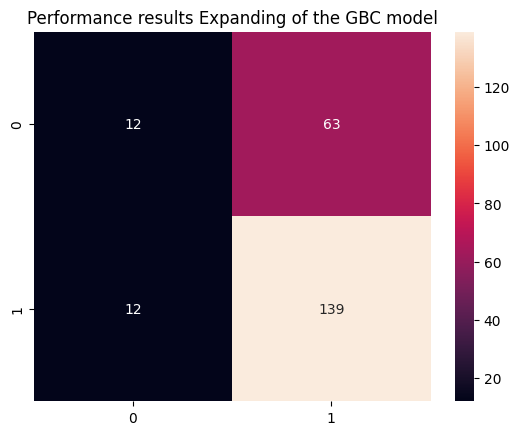


Feature Importance of the model



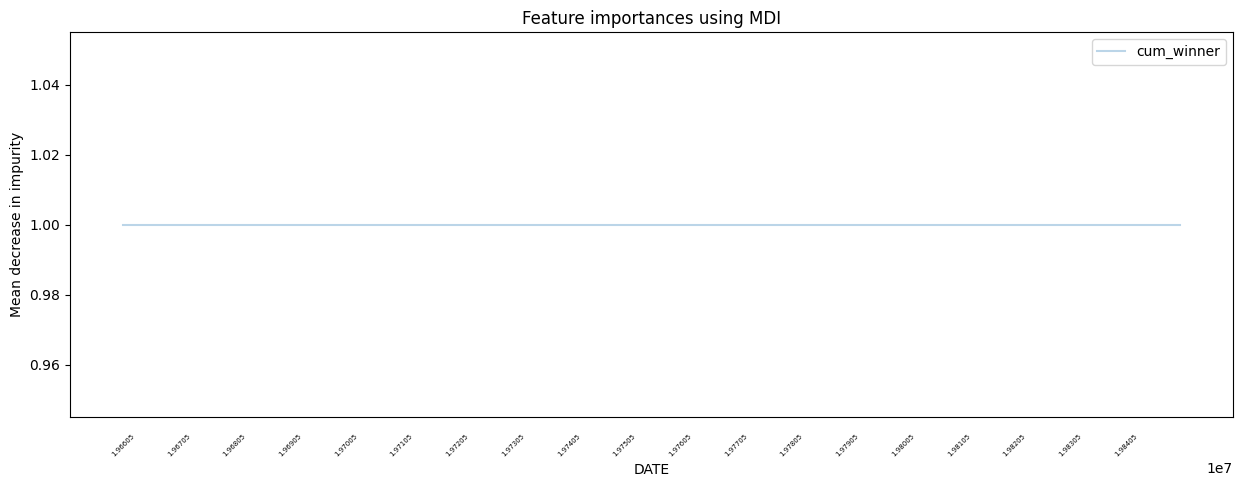

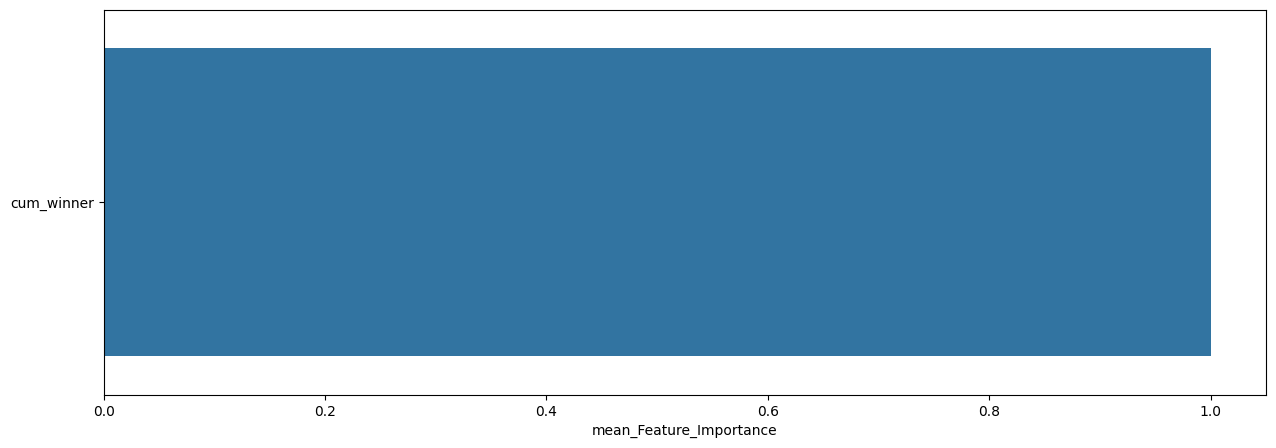

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.10      0.15        70
         1.0       0.69      0.91      0.79       156

    accuracy                           0.66       226
   macro avg       0.51      0.51      0.47       226
weighted avg       0.58      0.66      0.59       226


accuracy : 0.6592920353982301

precision : 0.6926829268292682

recall : 0.9102564102564102

F1-Score : 0.7867036011080331



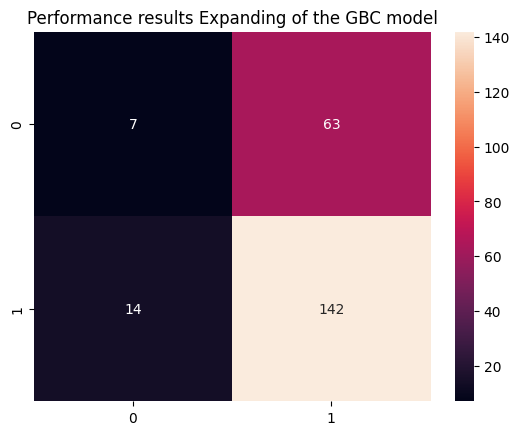


Feature Importance of the model



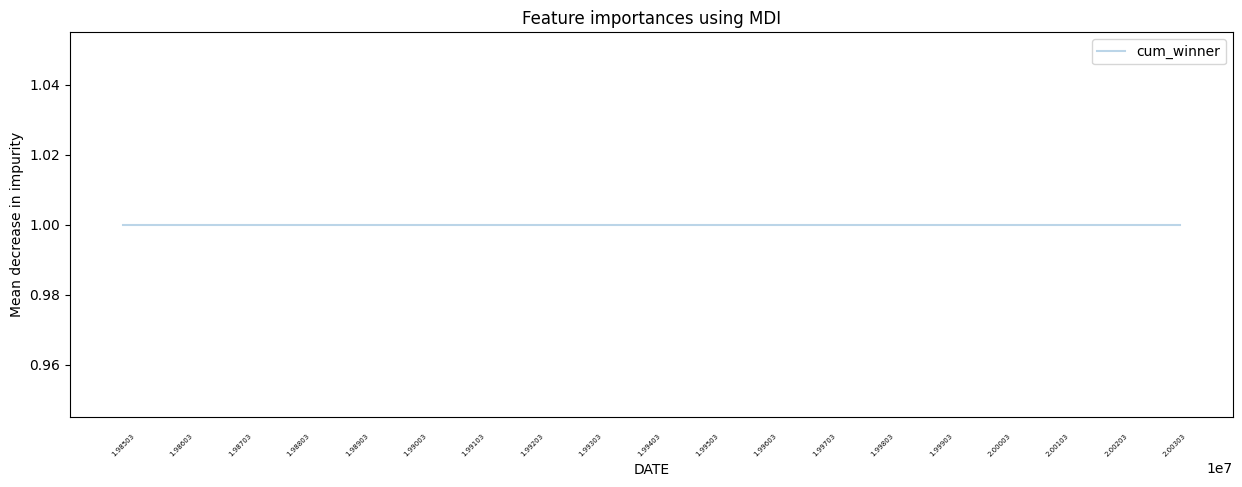

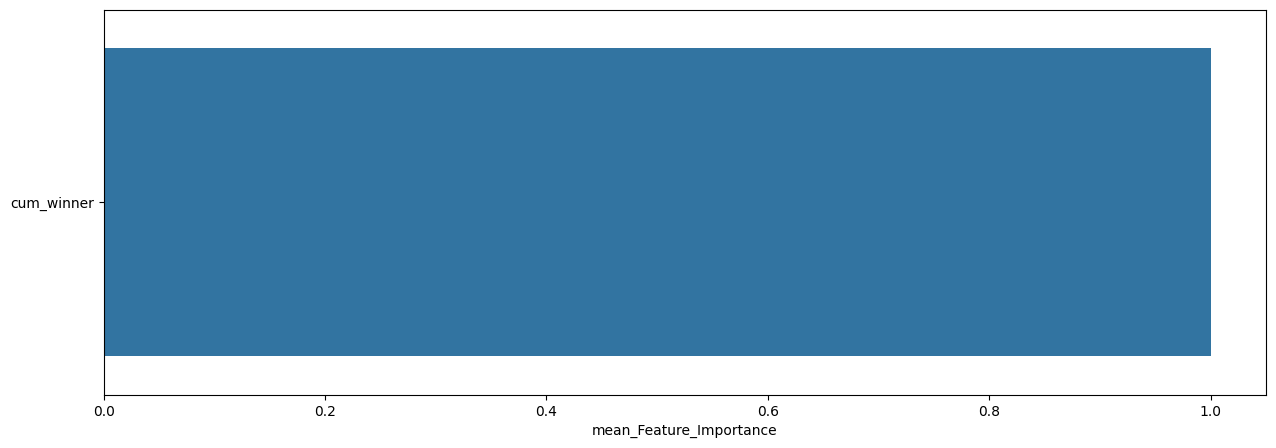

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.06      0.10        96
         1.0       0.57      0.90      0.70       132

    accuracy                           0.55       228
   macro avg       0.44      0.48      0.40       228
weighted avg       0.46      0.55      0.45       228


accuracy : 0.5482456140350878

precision : 0.569377990430622

recall : 0.9015151515151515

F1-Score : 0.6979472140762462



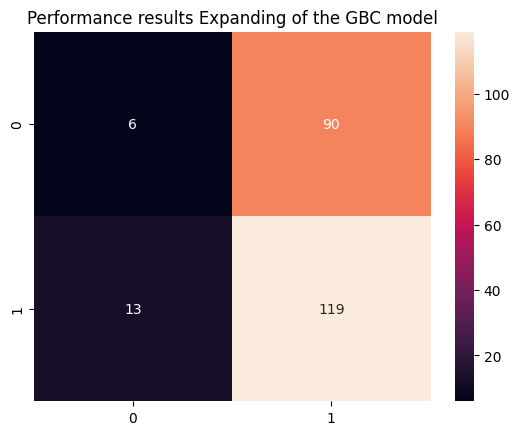


Feature Importance of the model



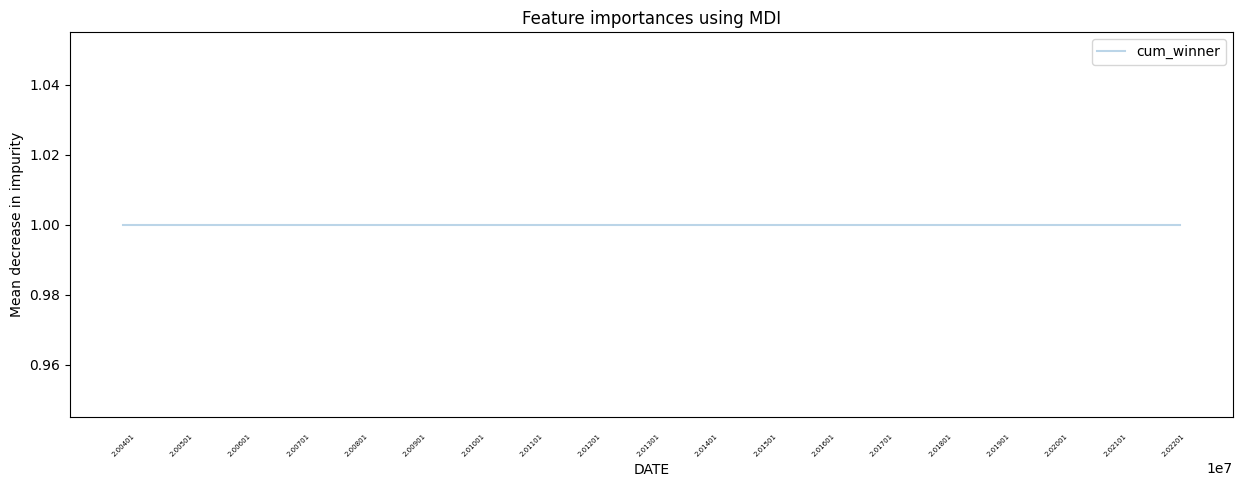

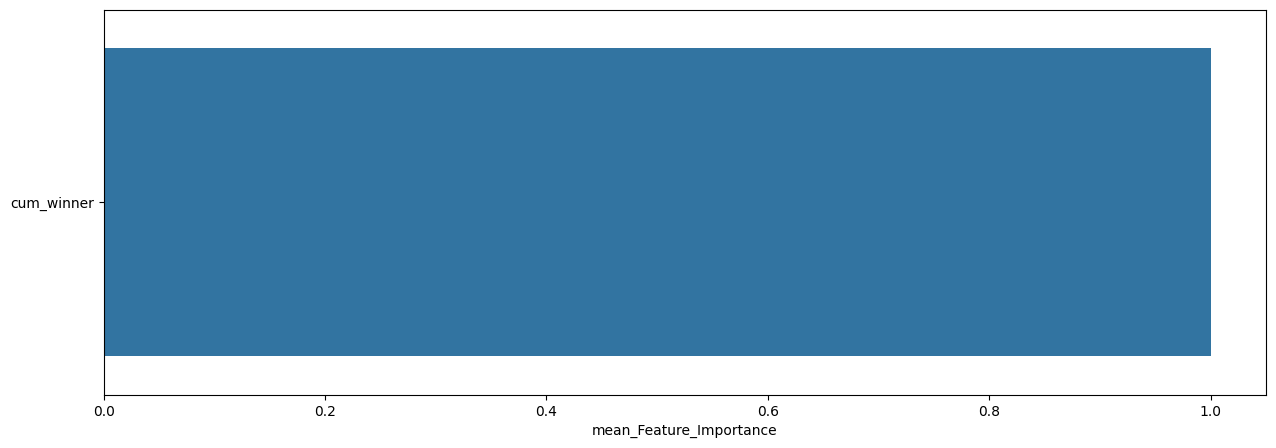

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [121]:
slice_feature_importance(Expanding_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



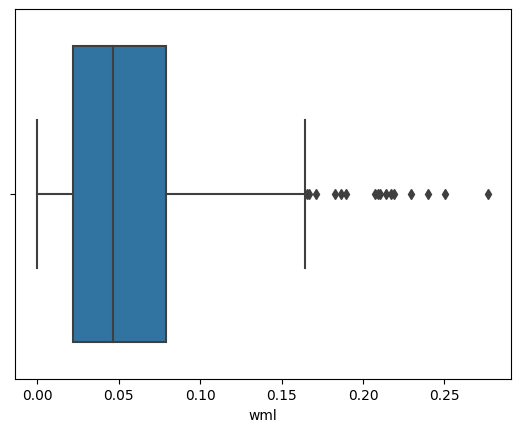

count      mean       std       min       25%       50%       75%  \
wml  518.0  0.056355  0.046529  0.000007  0.022018  0.046155  0.079247   

          max  
wml  0.276912


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



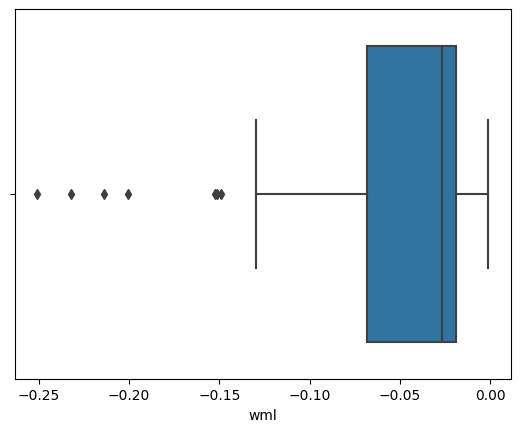

count      mean       std       min       25%       50%       75%  \
wml   47.0 -0.059609  0.064582 -0.250756 -0.068188 -0.026563 -0.019218   

          max  
wml -0.001073


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



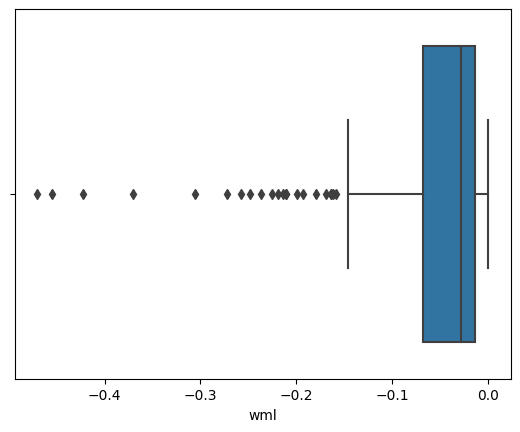

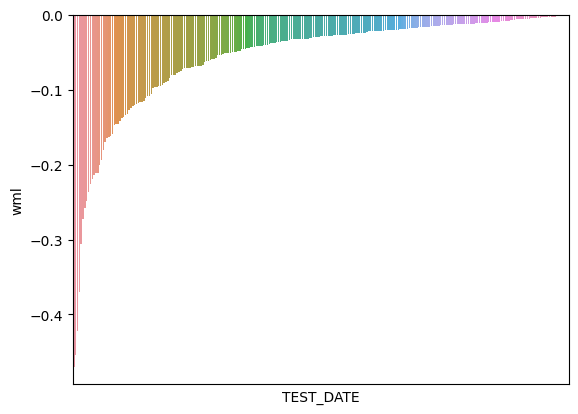

count      mean       std       min       25%       50%       75%  \
wml  269.0 -0.055735  0.072431 -0.469903 -0.067845 -0.028769 -0.013863   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



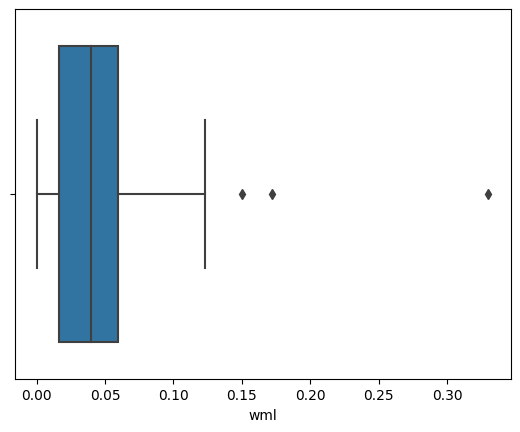

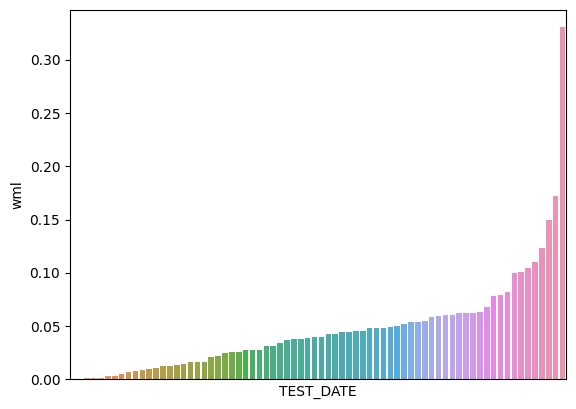

count      mean      std       min       25%       50%       75%  \
wml   72.0  0.047295  0.04838  0.000577  0.016505  0.039729  0.059726   

          max  
wml  0.330163

In [122]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Expanding_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.65136

최근 누적 수익률

  2022년-12월 -> 102732.71
  2022년-11월 -> 102732.71
  2022년-10월 -> 97720.45
  2022년-09월 -> 86530.10
  2022년-08월 -> 78668.64

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 180909.69
  2등 : 2002년-07월 -> 157533.92
  3등 : 2002년-06월 -> 157533.92
  4등 : 2002년-08월 -> 152970.00
  5등 : 2002년-10월 -> 145967.41
  6등 : 2002년-05월 -> 135460.65
  7등 : 2009년-02월 -> 132585.95
  8등 : 2009년-01월 -> 132585.95
  9등 : 2008년-11월 -> 131721.16
  10등 : 2008년-12월 -> 128603.43



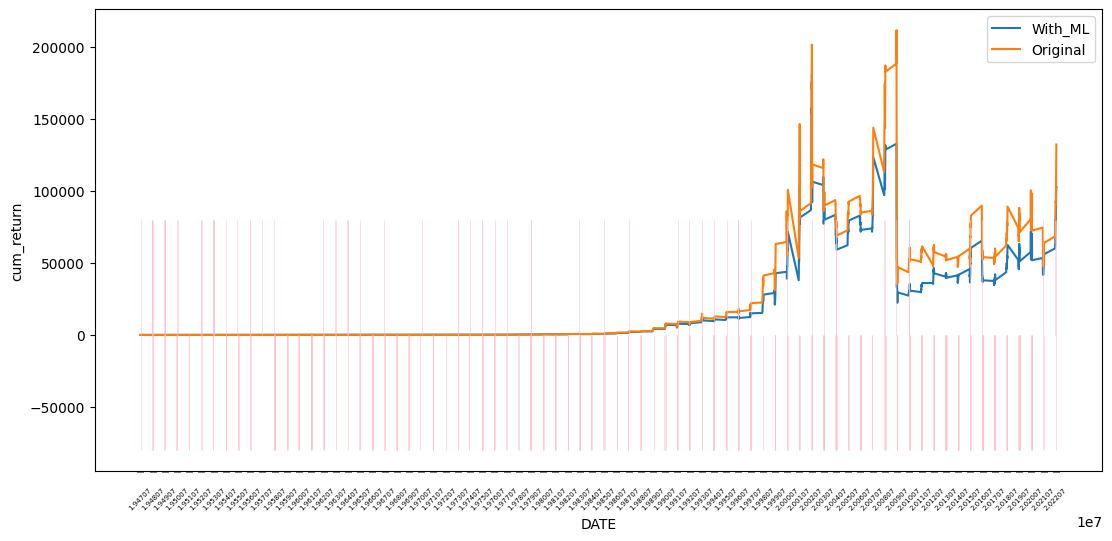

In [123]:
GBC_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.74608

최근 누적 수익률

  2022년-12월 -> 4883.90
  2022년-11월 -> 4706.44
  2022년-10월 -> 4547.28
  2022년-09월 -> 4205.44
  2022년-08월 -> 3948.75

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 6068.05
  2등 : 2002년-09월 -> 6011.48
  3등 : 2009년-01월 -> 5786.20
  4등 : 2008년-11월 -> 5769.70
  5등 : 2008년-12월 -> 5694.65
  6등 : 2002년-07월 -> 5575.66
  7등 : 2002년-08월 -> 5461.52
  8등 : 2002년-06월 -> 5458.99
  9등 : 2008년-06월 -> 5426.10
  10등 : 2008년-10월 -> 5400.31



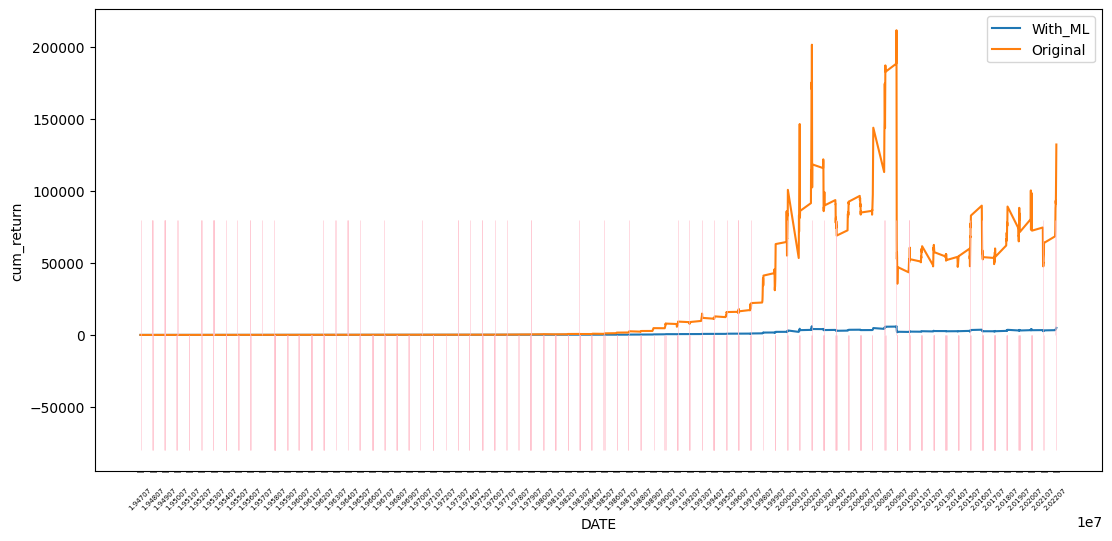

In [124]:
GBC_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                  WML,
                                                  'GBC_PROB_POS_WML',
                                                  GBC_A0_P1,
                                                  GBC_A1_P0,
                                                  plot=True)

### XGB

In [125]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : No

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.26      0.30       316
         1.0       0.65      0.75      0.70       590

    accuracy                           0.58       906
   macro avg       0.50      0.50      0.50       906
weighted avg       0.55      0.58      0.56       906


accuracy : 0.5761589403973509

precision : 0.6523668639053254

recall : 0.747457627118644

F1-Score : 0.6966824644549763



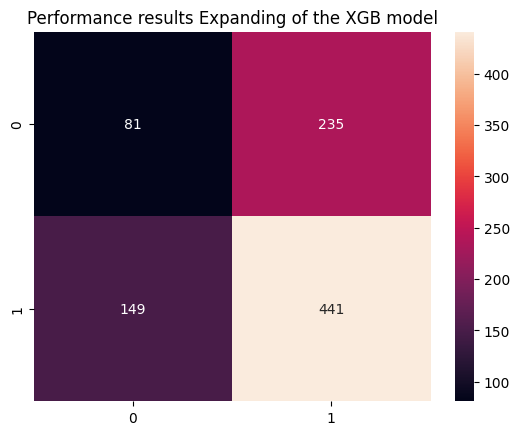


Feature Importance of the model



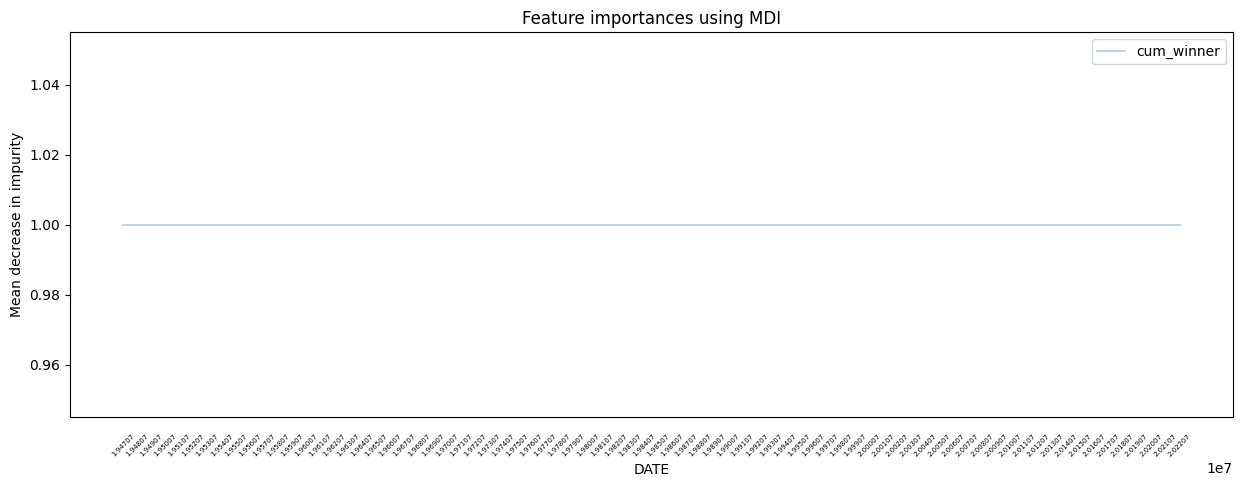

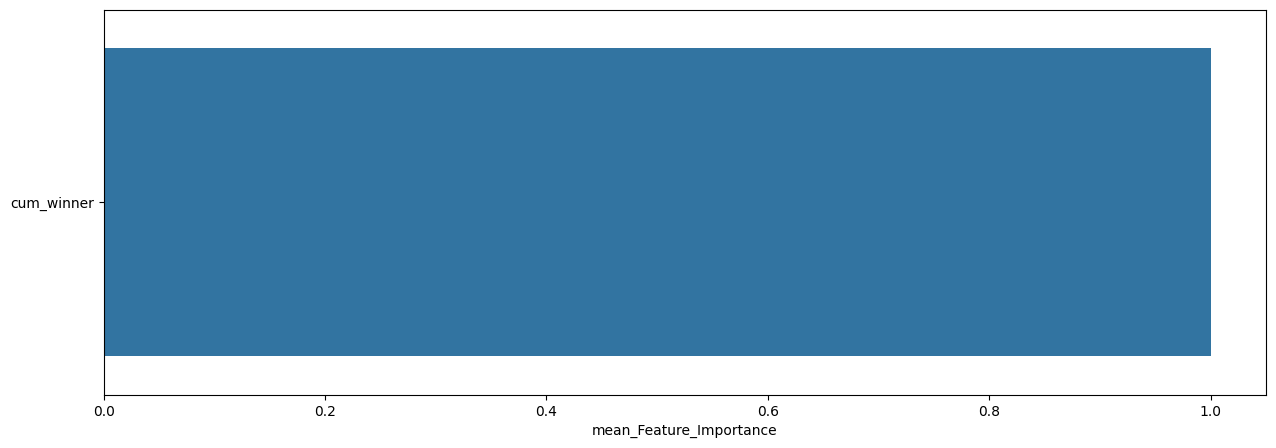

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [126]:
Expanding_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.37      0.37        75
         1.0       0.68      0.68      0.68       151

    accuracy                           0.58       226
   macro avg       0.52      0.52      0.52       226
weighted avg       0.58      0.58      0.58       226


accuracy : 0.5752212389380531

precision : 0.6845637583892618

recall : 0.6754966887417219

F1-Score : 0.6799999999999999



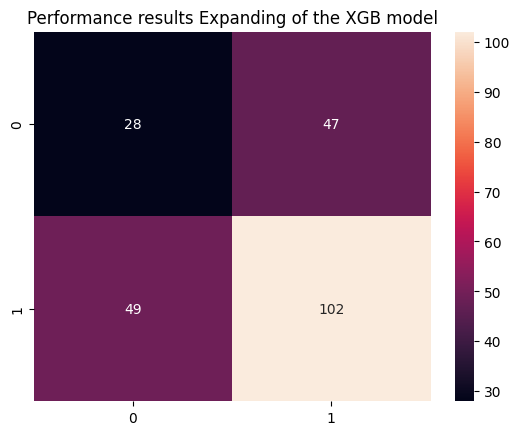


Feature Importance of the model



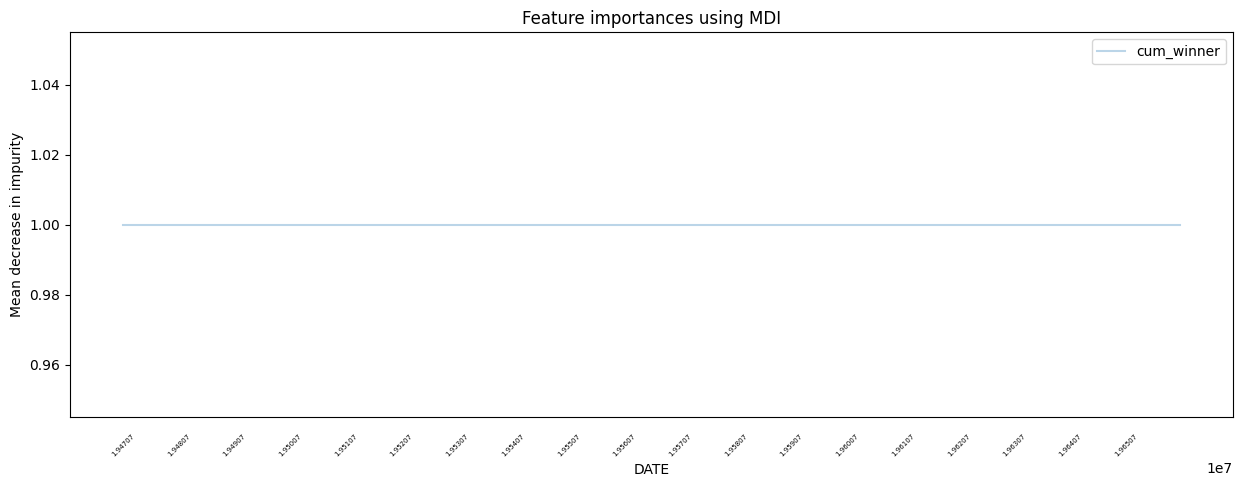

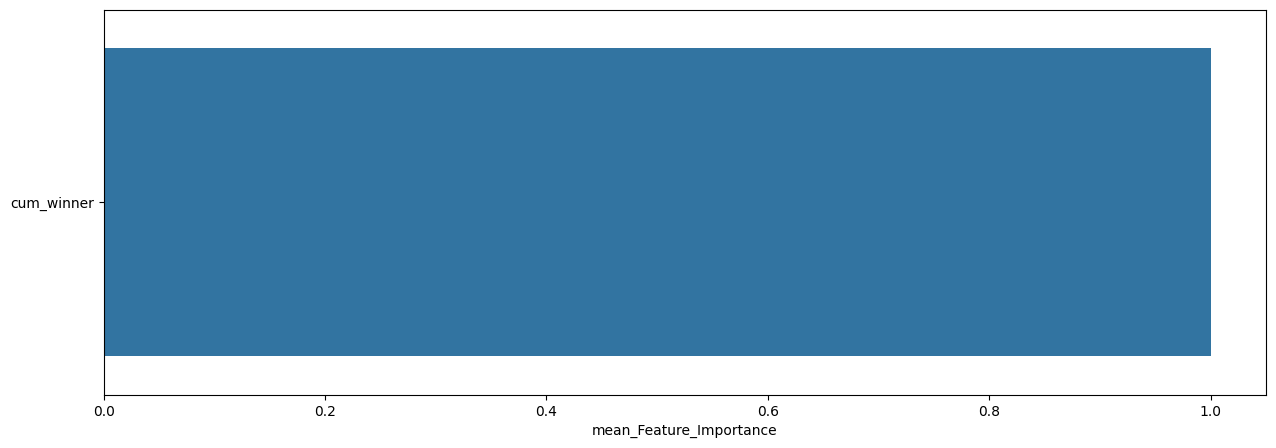

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.23      0.28        75
         1.0       0.67      0.79      0.73       151

    accuracy                           0.61       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.57      0.61      0.58       226


accuracy : 0.6061946902654868

precision : 0.6741573033707865

recall : 0.7947019867549668

F1-Score : 0.729483282674772



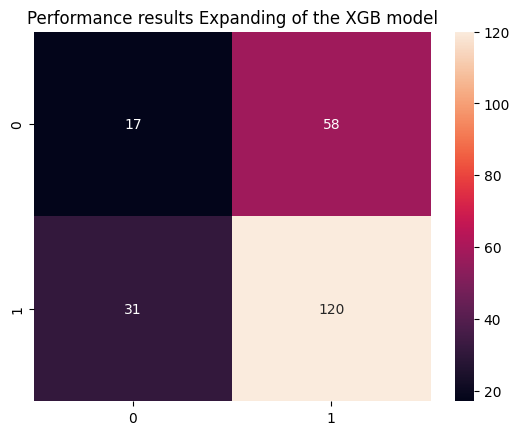


Feature Importance of the model



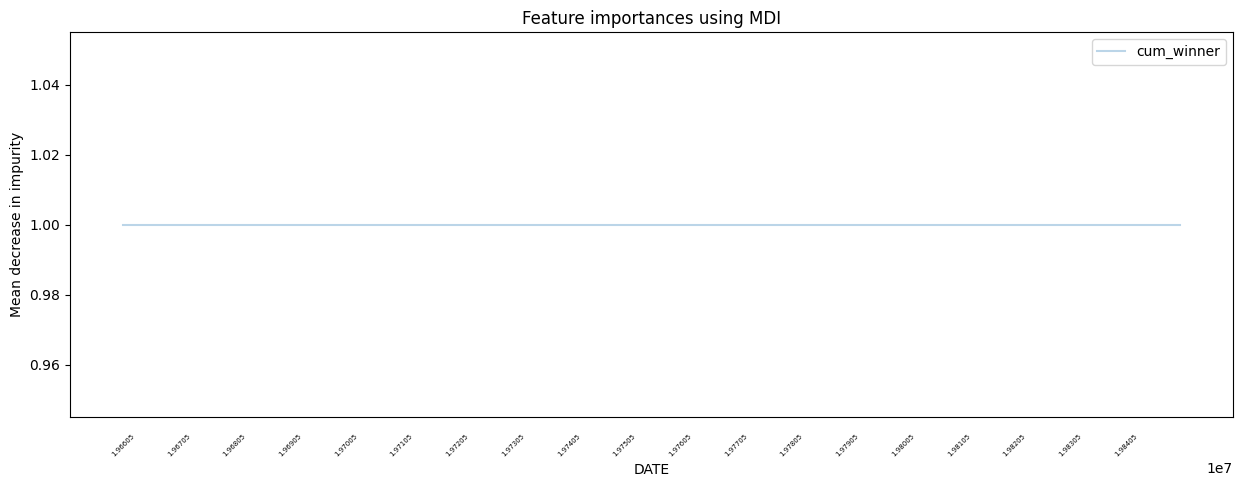

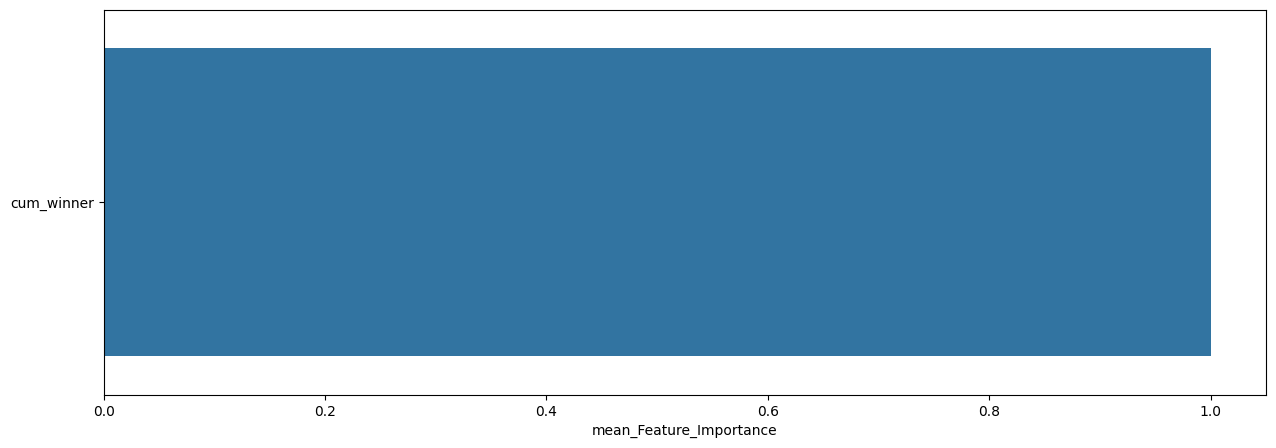

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.23      0.27        70
         1.0       0.69      0.78      0.73       156

    accuracy                           0.61       226
   macro avg       0.51      0.51      0.50       226
weighted avg       0.58      0.61      0.59       226


accuracy : 0.6106194690265486

precision : 0.6931818181818182

recall : 0.782051282051282

F1-Score : 0.7349397590361446



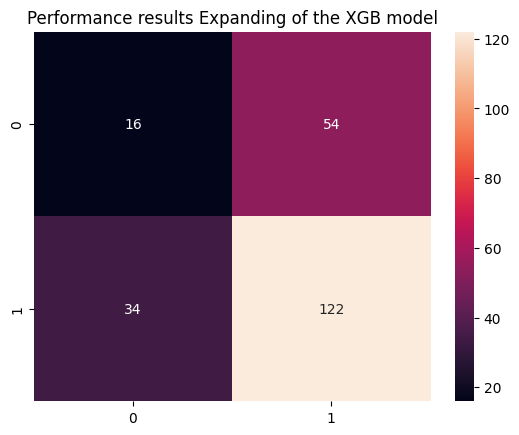


Feature Importance of the model



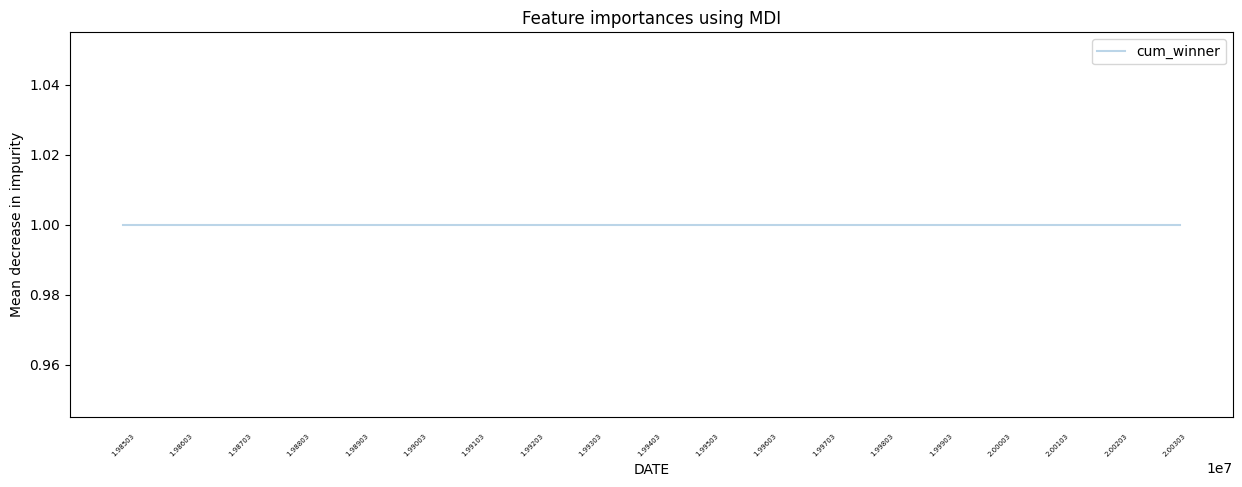

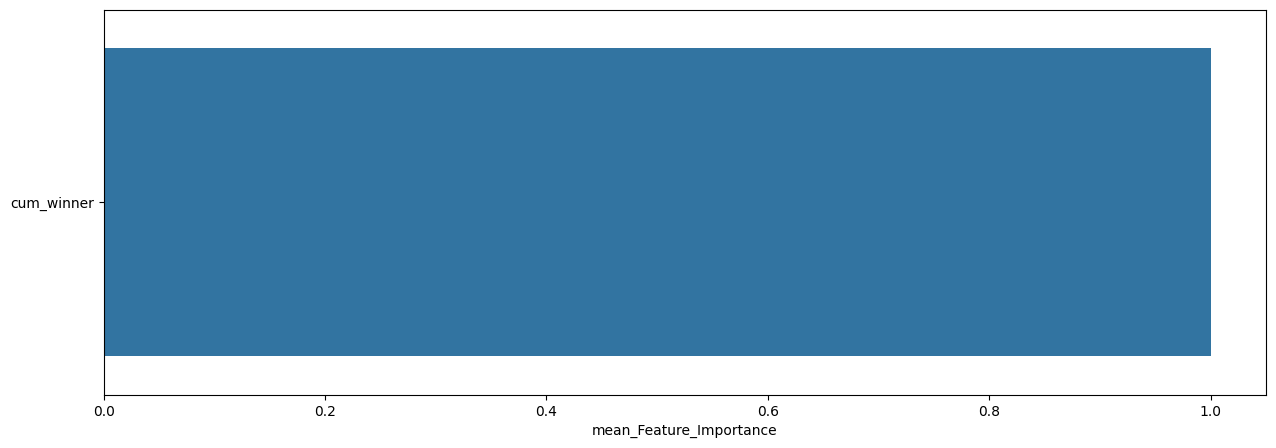

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.21      0.26        96
         1.0       0.56      0.73      0.64       132

    accuracy                           0.51       228
   macro avg       0.46      0.47      0.45       228
weighted avg       0.48      0.51      0.48       228


accuracy : 0.5131578947368421

precision : 0.5606936416184971

recall : 0.7348484848484849

F1-Score : 0.6360655737704918



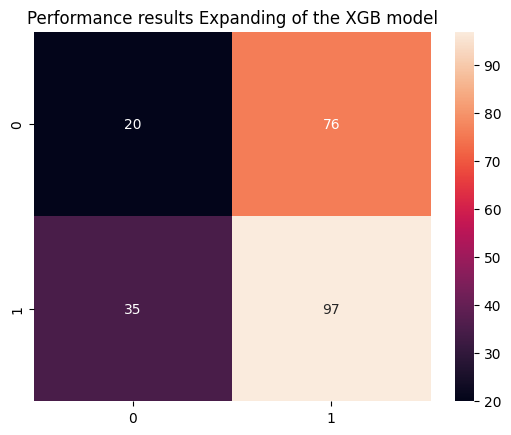


Feature Importance of the model



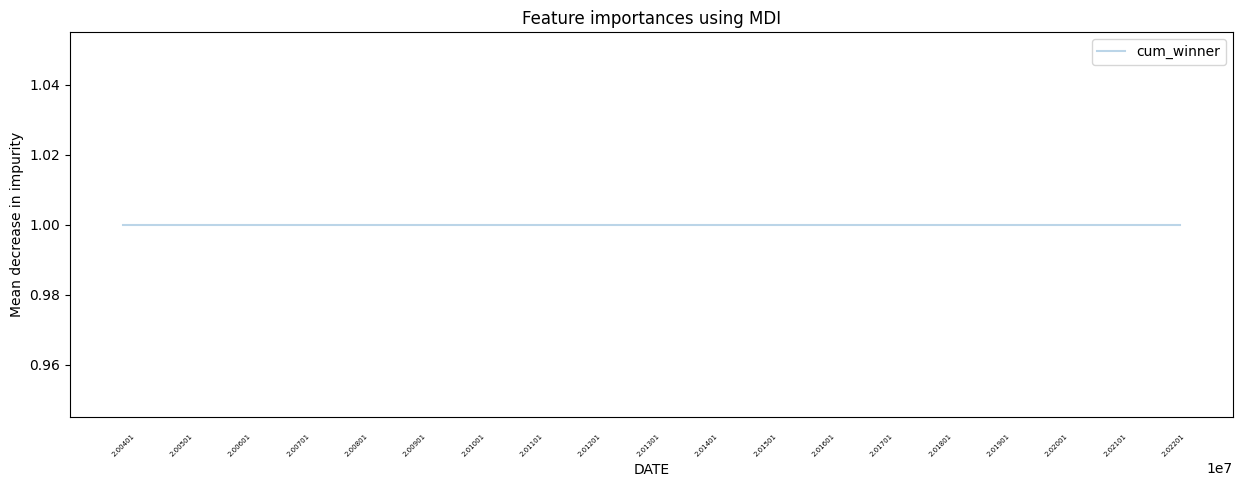

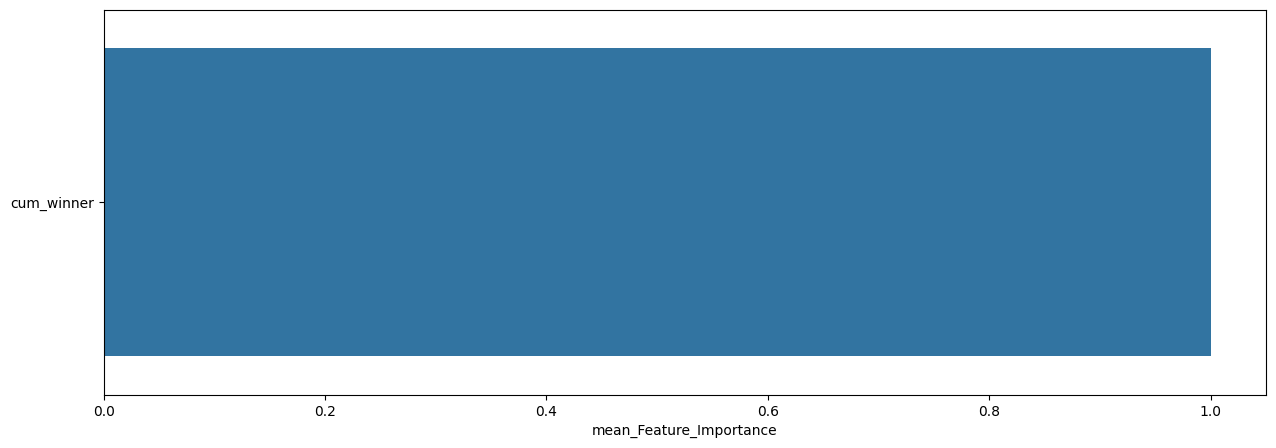

mean_Feature_Importance  max_Feature_Importance  \
cum_winner                      1.0                     1.0   

            min_Feature_Importance  
cum_winner                     1.0

In [127]:
slice_feature_importance(Expanding_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



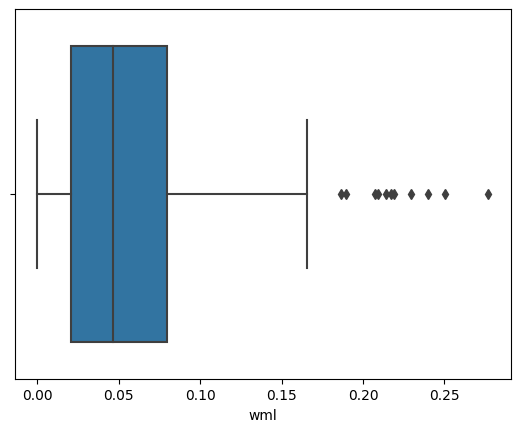

count     mean       std       min       25%       50%      75%       max
wml  441.0  0.05608  0.046948  0.000007  0.020642  0.046139  0.07947  0.276912


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



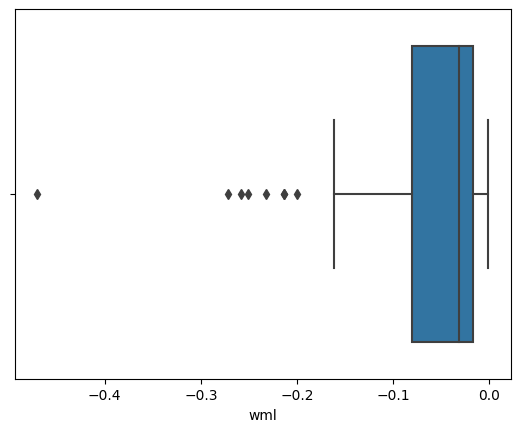

count      mean       std       min       25%       50%       75%  \
wml   81.0 -0.065835  0.081309 -0.469903 -0.080058 -0.032064 -0.017434   

          max  
wml -0.001073


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



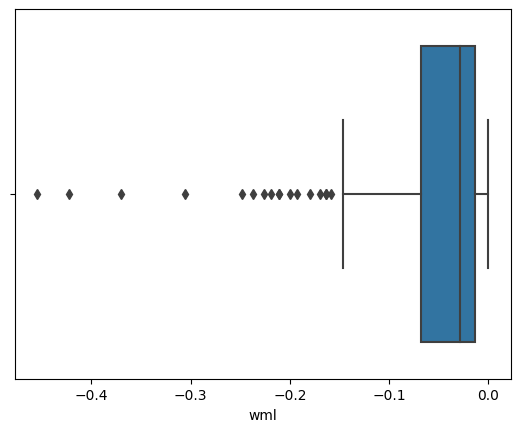

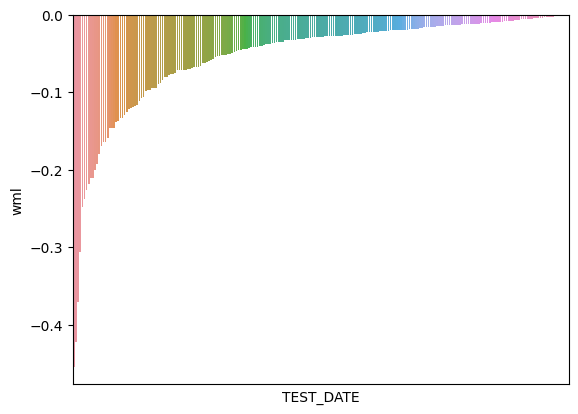

count      mean       std       min       25%       50%       75%  \
wml  235.0 -0.053028  0.067294 -0.454349 -0.067542 -0.028471 -0.013746   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



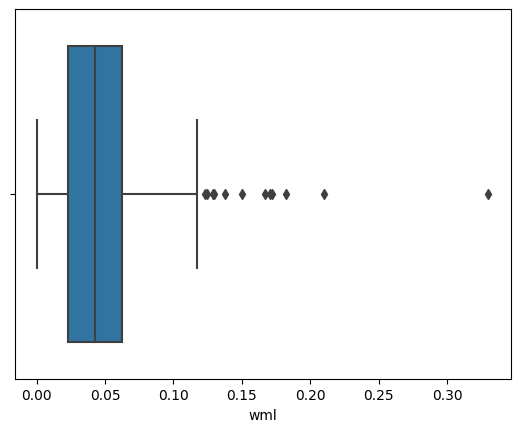

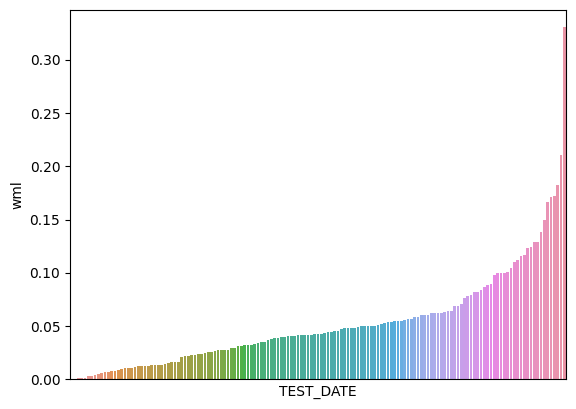

count      mean       std       min       25%       50%       75%  \
wml  149.0  0.052793  0.046475  0.000577  0.022916  0.042778  0.062657   

          max  
wml  0.330163

In [128]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Expanding_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.58669

최근 누적 수익률

  2022년-12월 -> 25289.86
  2022년-11월 -> 25289.86
  2022년-10월 -> 24055.94
  2022년-09월 -> 24055.94
  2022년-08월 -> 24055.94

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 52586.76
  2등 : 2009년-01월 -> 52586.76
  3등 : 2008년-11월 -> 52243.76
  4등 : 2008년-12월 -> 51007.18
  5등 : 2008년-06월 -> 48712.29
  6등 : 2002년-07월 -> 48274.44
  7등 : 2002년-06월 -> 48274.44
  8등 : 2008년-10월 -> 47641.85
  9등 : 2002년-08월 -> 46875.86
  10등 : 2002년-09월 -> 46875.86



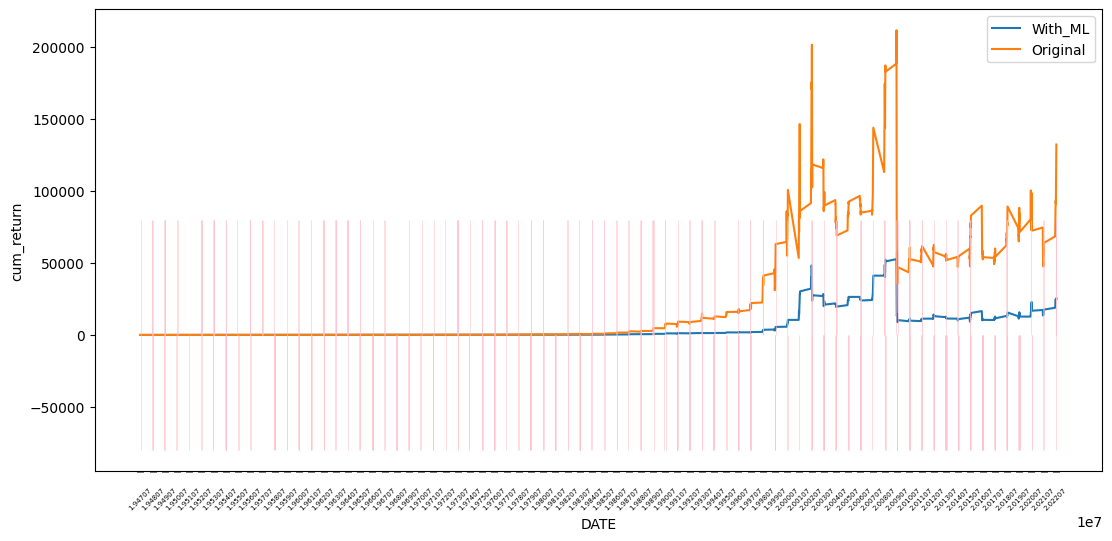

In [129]:
XGB_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.70134

최근 누적 수익률

  2022년-12월 -> 5630.01
  2022년-11월 -> 5554.66
  2022년-10월 -> 5327.27
  2022년-09월 -> 5014.79
  2022년-08월 -> 4805.27

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 9828.53
  2등 : 2002년-07월 -> 9207.77
  3등 : 2002년-06월 -> 9105.77
  4등 : 2009년-02월 -> 9081.19
  5등 : 2002년-08월 -> 9014.99
  6등 : 2009년-01월 -> 8957.99
  7등 : 2008년-11월 -> 8927.47
  8등 : 2008년-12월 -> 8818.09
  9등 : 2008년-06월 -> 8490.68
  10등 : 2002년-10월 -> 8418.55



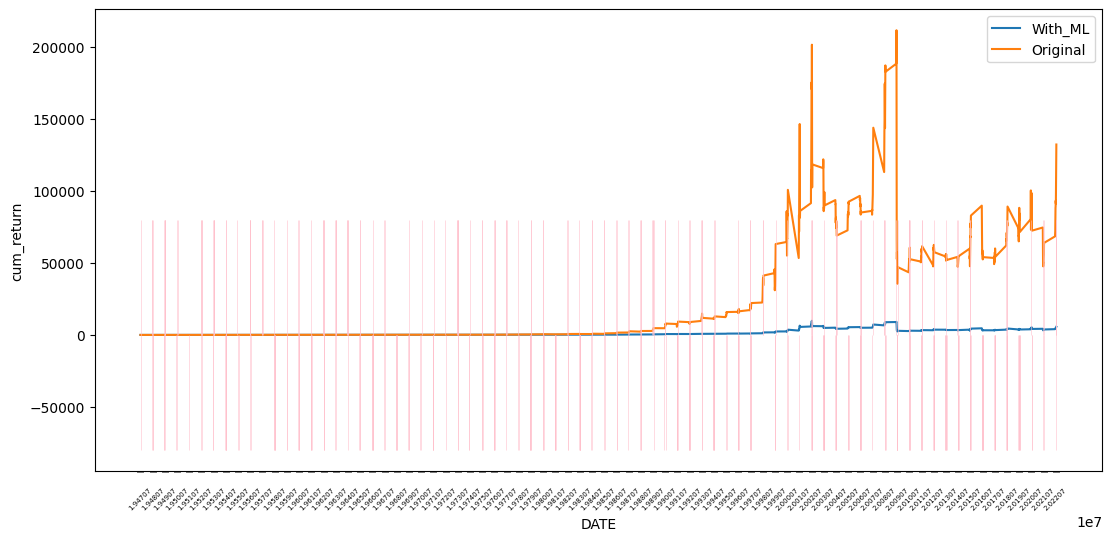

In [130]:
XGB_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [131]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.21      0.26       316
         1.0       0.65      0.78      0.71       590

    accuracy                           0.58       906
   macro avg       0.49      0.50      0.48       906
weighted avg       0.54      0.58      0.55       906


accuracy : 0.5827814569536424

precision : 0.648876404494382

recall : 0.7830508474576271

F1-Score : 0.7096774193548387



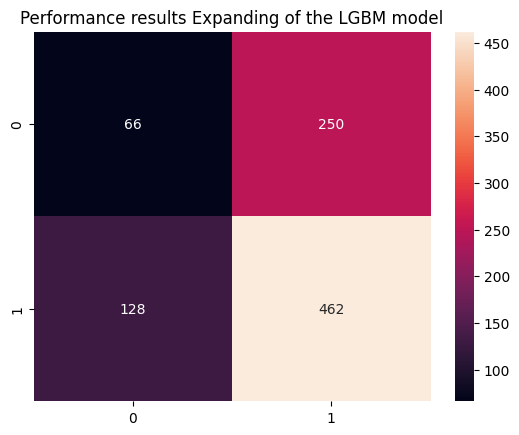


Feature Importance of the model



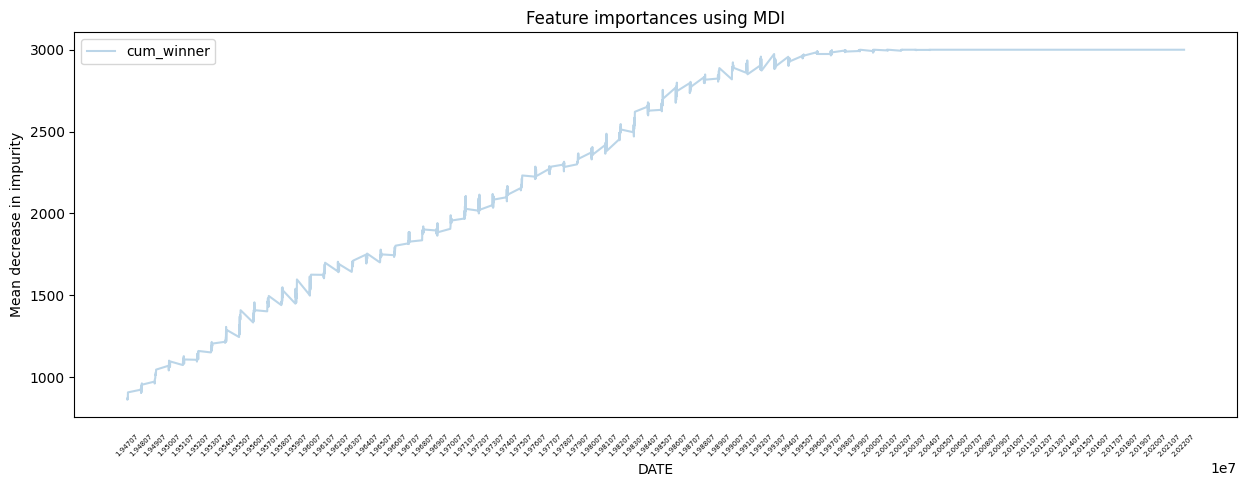

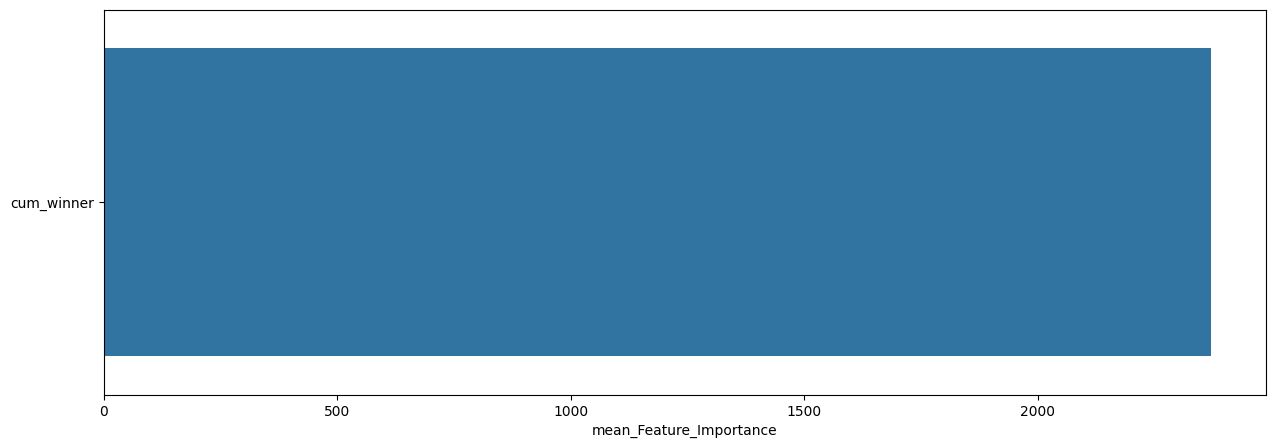

mean_Feature_Importance  max_Feature_Importance  \
cum_winner              2369.811258                    3000   

            min_Feature_Importance  
cum_winner                     862

In [132]:
Expanding_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.26      0.24      0.25        75
         1.0       0.63      0.66      0.64       151

    accuracy                           0.52       226
   macro avg       0.45      0.45      0.45       226
weighted avg       0.51      0.52      0.51       226


accuracy : 0.5176991150442478

precision : 0.6346153846153846

recall : 0.6556291390728477

F1-Score : 0.6449511400651466



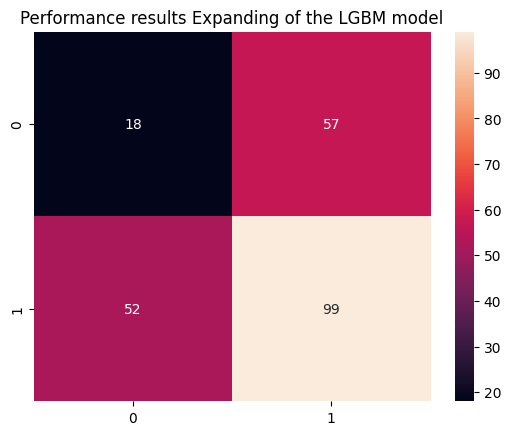


Feature Importance of the model



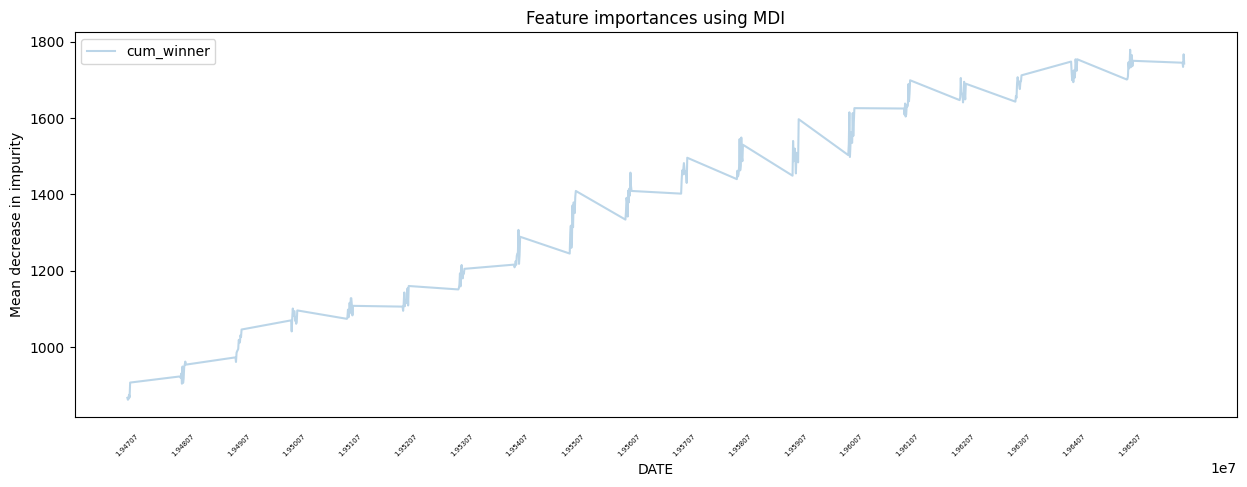

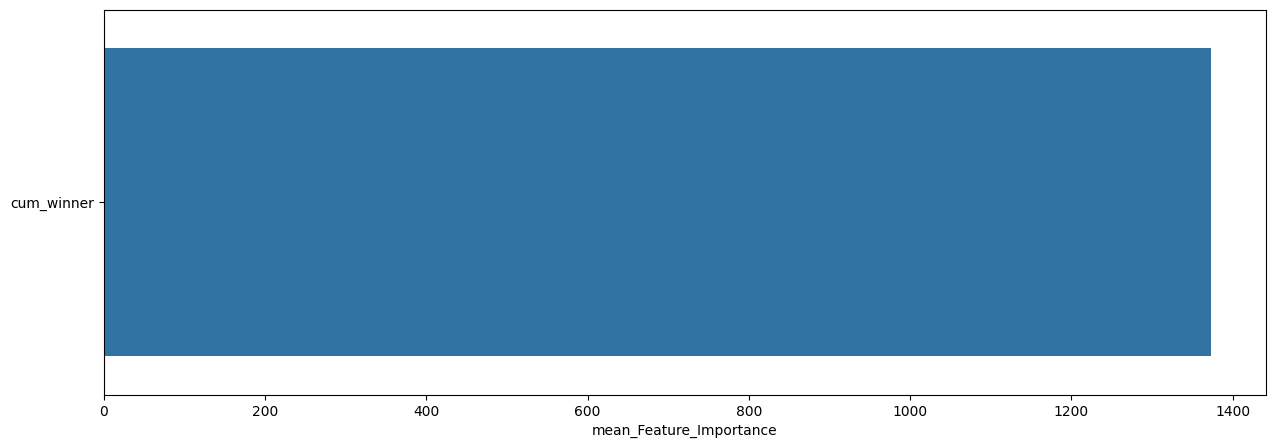

mean_Feature_Importance  max_Feature_Importance  \
cum_winner              1372.663717                    1779   

            min_Feature_Importance  
cum_winner                     862


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.17      0.23        75
         1.0       0.67      0.83      0.74       151

    accuracy                           0.62       226
   macro avg       0.51      0.50      0.49       226
weighted avg       0.56      0.62      0.57       226


accuracy : 0.6150442477876106

precision : 0.6702127659574468

recall : 0.8344370860927153

F1-Score : 0.743362831858407



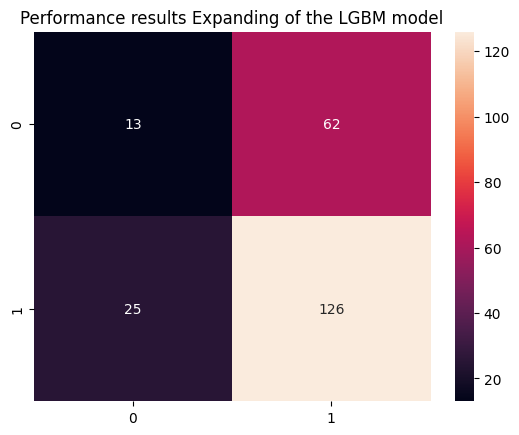


Feature Importance of the model



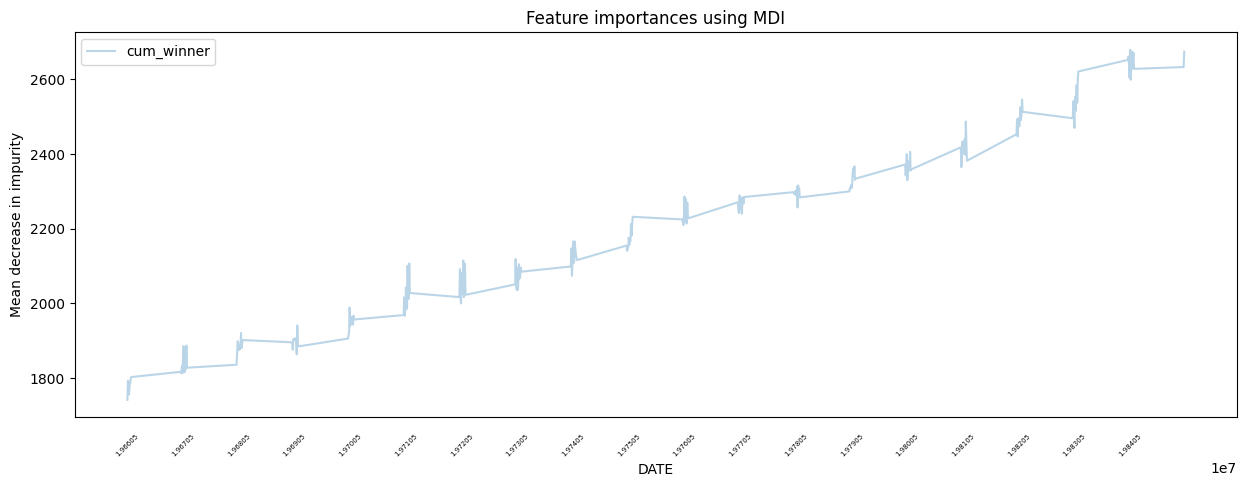

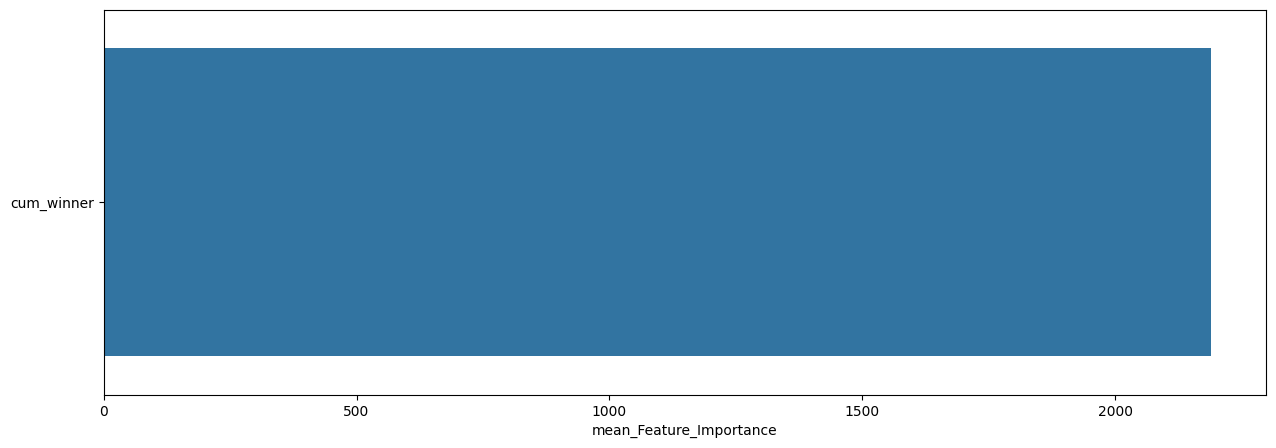

mean_Feature_Importance  max_Feature_Importance  \
cum_winner              2188.783186                    2679   

            min_Feature_Importance  
cum_winner                    1742


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.20      0.26        70
         1.0       0.70      0.85      0.77       156

    accuracy                           0.65       226
   macro avg       0.54      0.53      0.52       226
weighted avg       0.60      0.65      0.61       226


accuracy : 0.6504424778761062

precision : 0.7037037037037037

recall : 0.8525641025641025

F1-Score : 0.7710144927536231



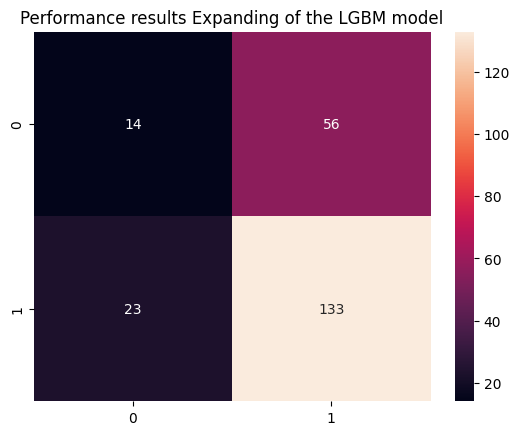


Feature Importance of the model



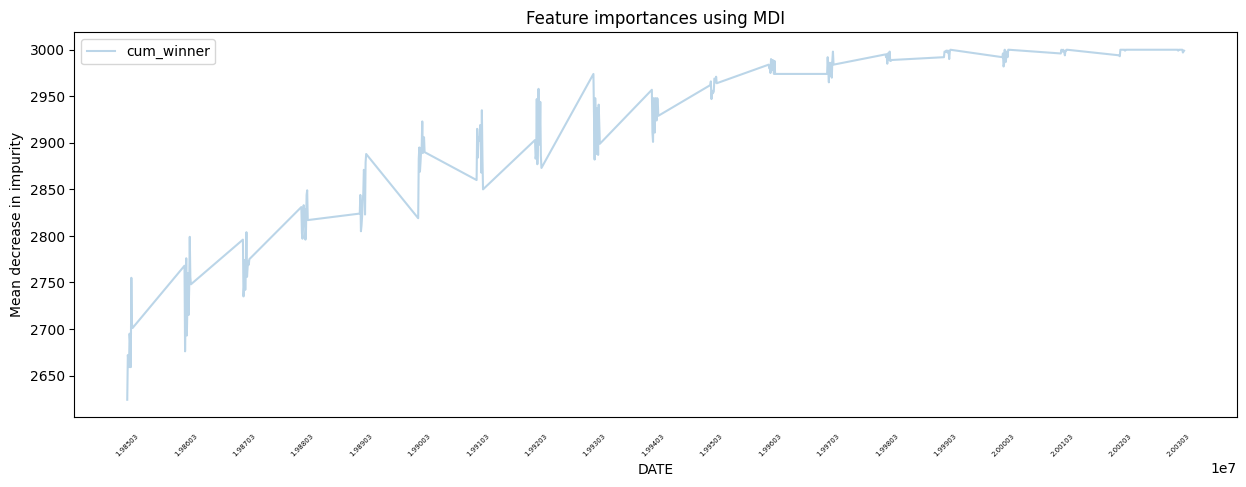

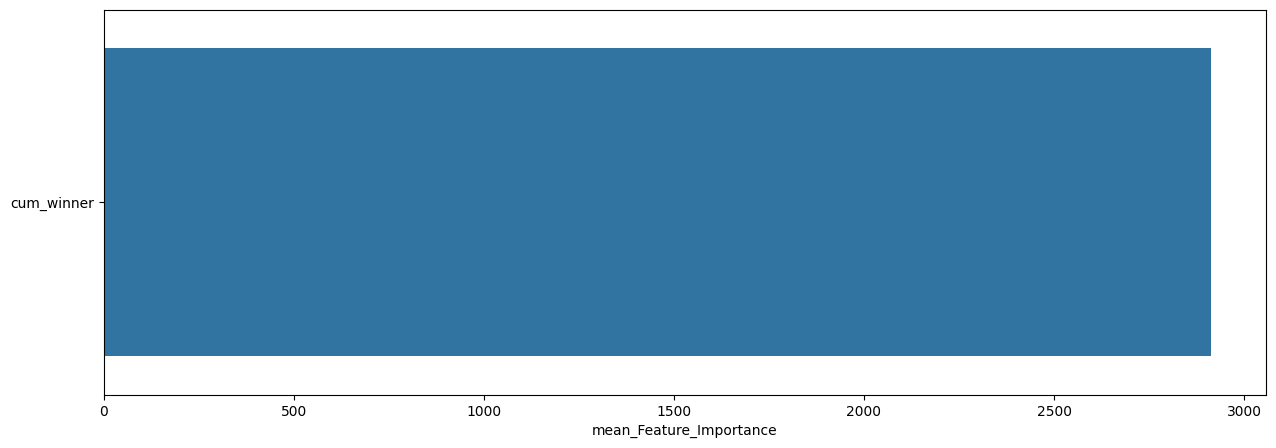

mean_Feature_Importance  max_Feature_Importance  \
cum_winner              2912.247788                    3000   

            min_Feature_Importance  
cum_winner                    2624


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.43      0.22      0.29        96
         1.0       0.58      0.79      0.67       132

    accuracy                           0.55       228
   macro avg       0.50      0.50      0.48       228
weighted avg       0.52      0.55      0.51       228


accuracy : 0.5482456140350878

precision : 0.5810055865921788

recall : 0.7878787878787878

F1-Score : 0.6688102893890676



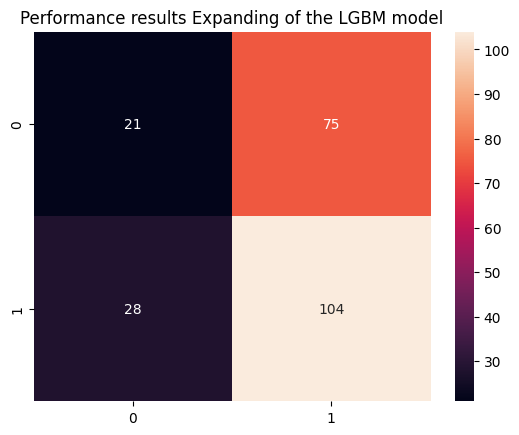


Feature Importance of the model



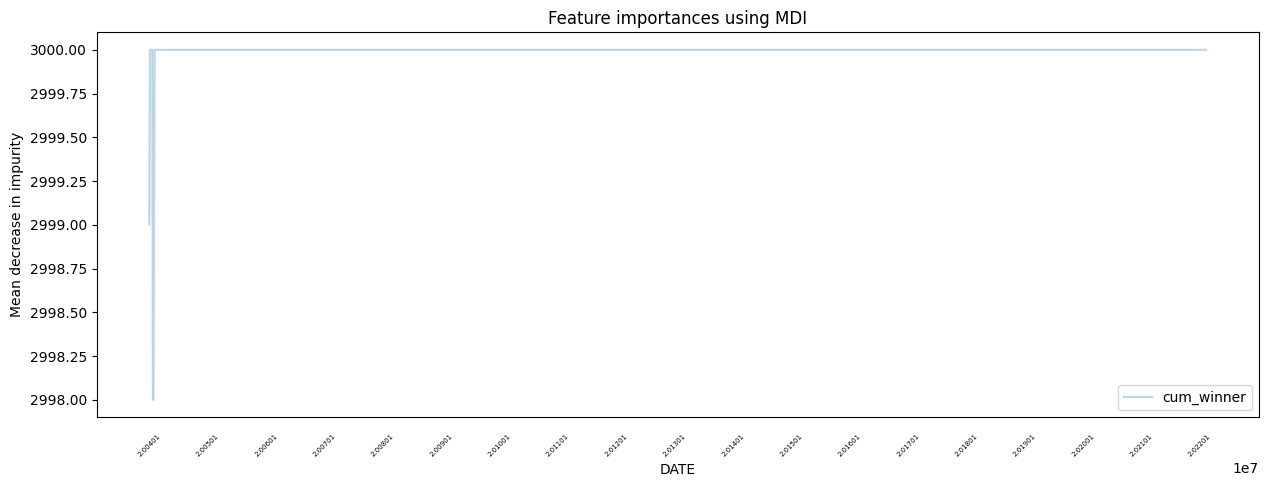

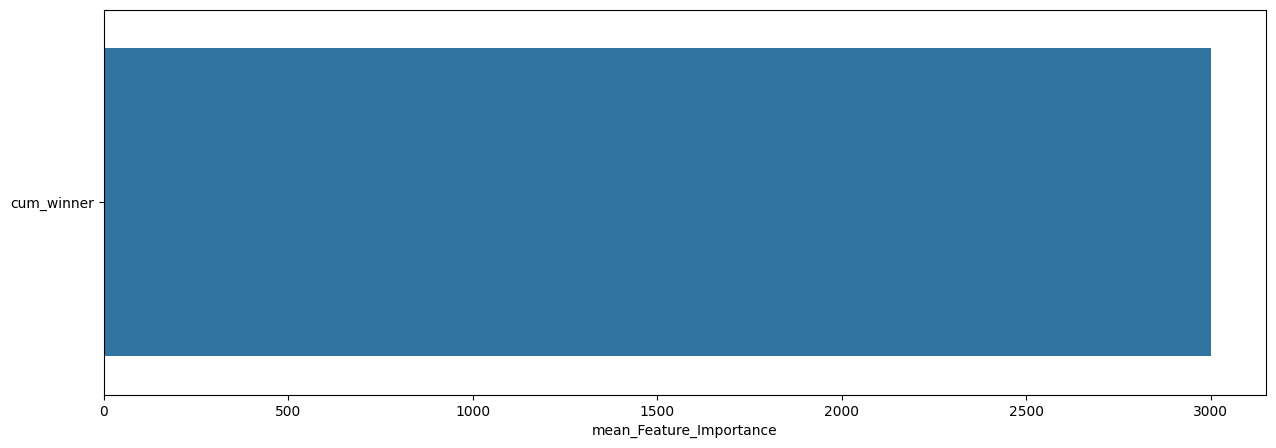

mean_Feature_Importance  max_Feature_Importance  \
cum_winner              2999.973684                    3000   

            min_Feature_Importance  
cum_winner                    2998

In [133]:
slice_feature_importance(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Expanding', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



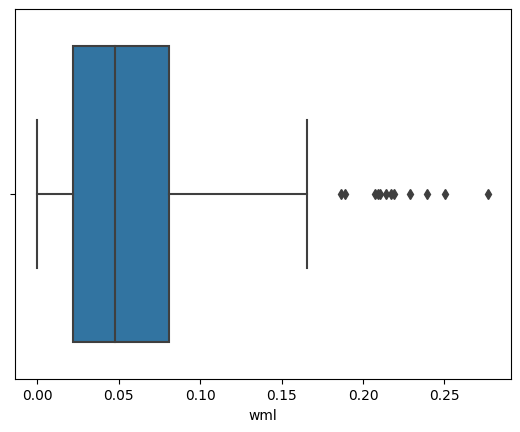

count      mean       std       min       25%       50%      75%  \
wml  462.0  0.056949  0.046996  0.000128  0.021907  0.047802  0.08078   

          max  
wml  0.276912


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



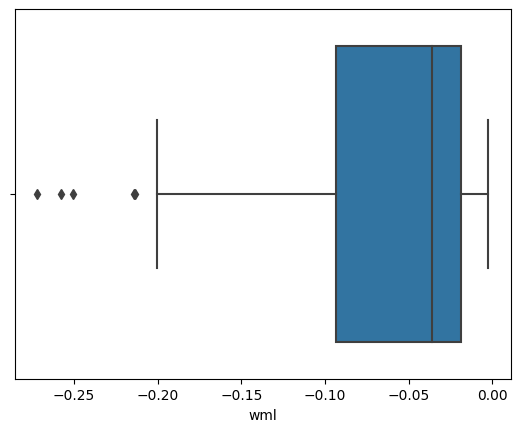

count      mean       std       min       25%       50%       75%  \
wml   66.0 -0.066728  0.068824 -0.271971 -0.093643 -0.035806 -0.018901   

          max  
wml -0.002394


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



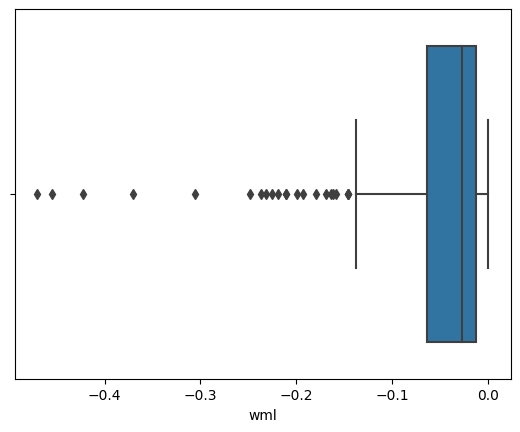

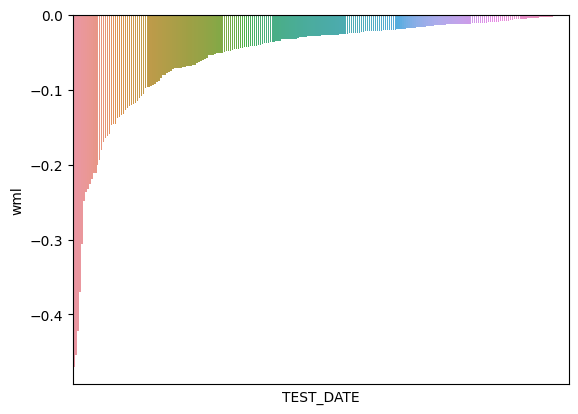

count      mean      std       min       25%       50%       75%  \
wml  250.0 -0.053561  0.07174 -0.469903 -0.064235 -0.027518 -0.013277   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



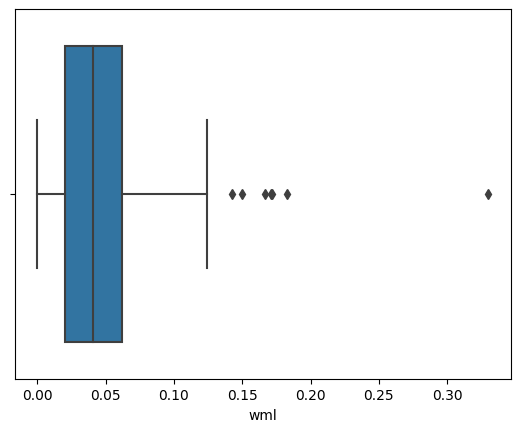

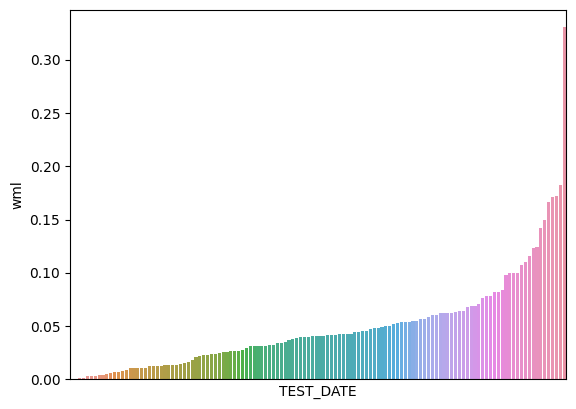

count      mean       std       min       25%       50%       75%  \
wml  128.0  0.049115  0.045796  0.000007  0.020258  0.040781  0.061957   

          max  
wml  0.330163

In [134]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Expanding_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.61896

최근 누적 수익률

  2022년-12월 -> 36928.14
  2022년-11월 -> 36928.14
  2022년-10월 -> 35126.41
  2022년-09월 -> 31103.88
  2022년-08월 -> 31103.88

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2008년-11월 -> 46872.60
  2등 : 2009년-02월 -> 45763.15
  3등 : 2009년-01월 -> 45763.15
  4등 : 2008년-12월 -> 45763.15
  5등 : 2002년-07월 -> 43288.67
  6등 : 2002년-06월 -> 43288.67
  7등 : 2008년-06월 -> 43014.53
  8등 : 2008년-10월 -> 42743.81
  9등 : 2002년-09월 -> 42034.53
  10등 : 2002년-08월 -> 42034.53



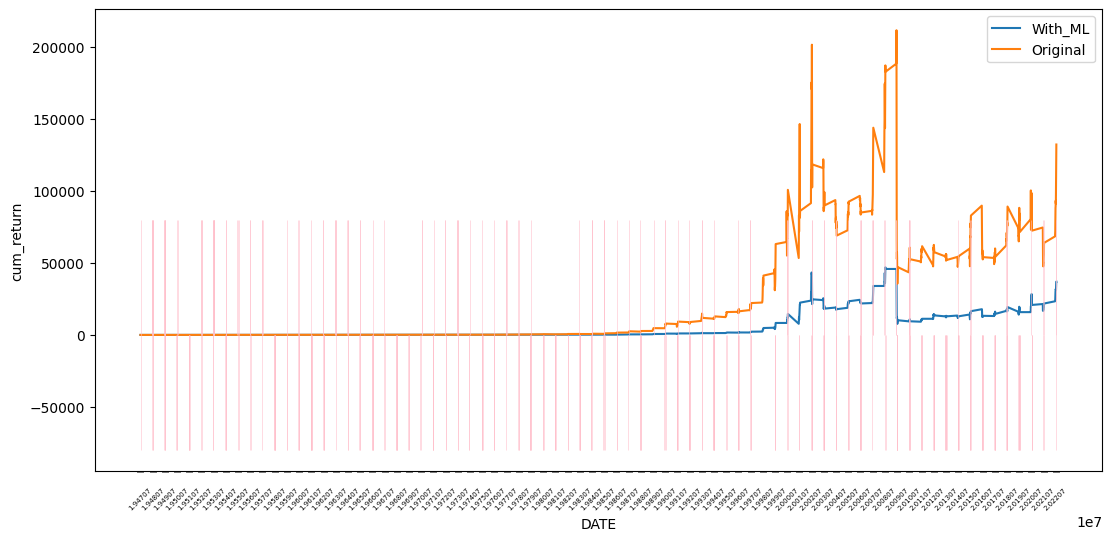

In [135]:
LGBM_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.71551

최근 누적 수익률

  2022년-12월 -> 6940.35
  2022년-11월 -> 6651.53
  2022년-10월 -> 6410.11
  2022년-09월 -> 5879.03
  2022년-08월 -> 5650.51

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 7878.63
  2등 : 2009년-02월 -> 7847.85
  3등 : 2009년-01월 -> 7409.72
  4등 : 2008년-11월 -> 7391.73
  5등 : 2002년-07월 -> 7382.72
  6등 : 2008년-12월 -> 7303.39
  7등 : 2002년-06월 -> 7233.19
  8등 : 2002년-08월 -> 7222.51
  9등 : 2008년-06월 -> 7135.09
  10등 : 2022년-12월 -> 6940.35



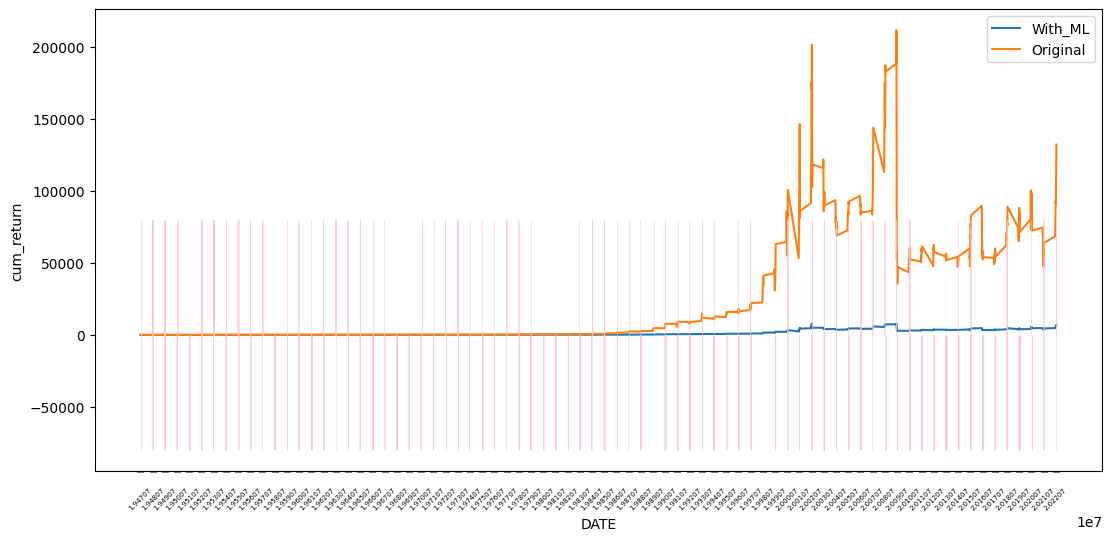

In [136]:
LGBM_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

# Performance

## F1 - Score

RDF의 F1-Score : 0.6588432523051132
GBC의 F1-Score : 0.6940711462450593
XGB의 F1-Score : 0.6715447154471544
LGBM의 F1-Score : 0.7061503416856492



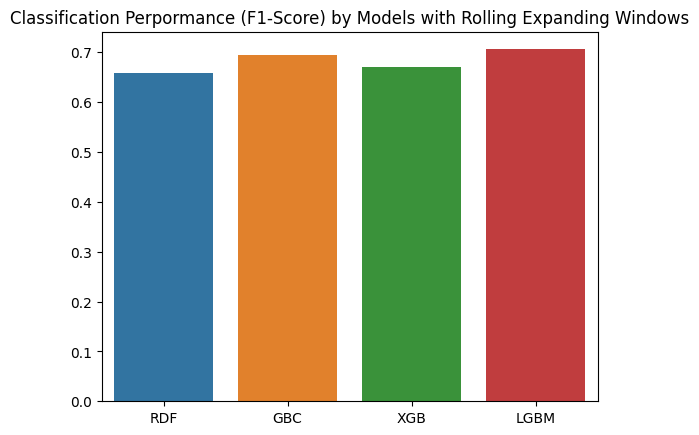

In [137]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

RDF의 F1-Score : 0.6464135021097047
GBC의 F1-Score : 0.7523602033405955
XGB의 F1-Score : 0.6966824644549763
LGBM의 F1-Score : 0.7096774193548387



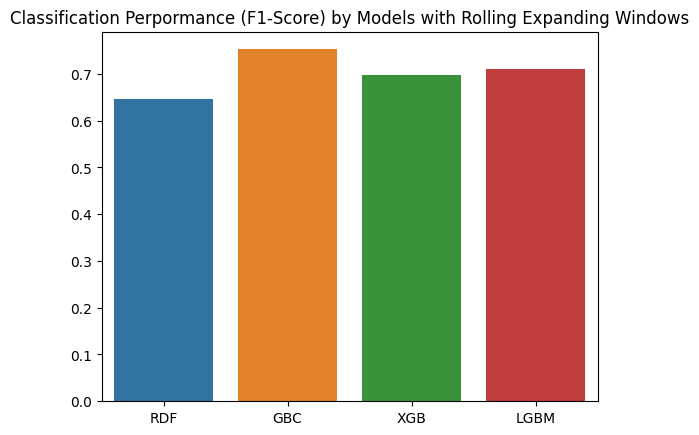

In [138]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

## Cum Return & Sharpe Ratio

In [139]:
R_WML = WML.loc[19470731:].copy()
CUM_WML = WML.loc[19470731:].copy()

CUM_WML['wml'] = (1 + CUM_WML.wml).cumprod() - 1
CUM_WML.columns = ['cum_return'] 

last_r = CUM_WML['cum_return'].values[-1]
w_S = (R_WML['wml'].mean()/R_WML['wml'].std()) * math.sqrt(12)

In [140]:
def compare_sharpe_ratio(list_model, list_result, list_cum, dynamic=True):

  print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format('ORG', w_S, last_r))

  for model, data, cum in zip(list_model, list_result, list_cum):
    data['wml'] = WML.loc[19470731:]['wml']

    if dynamic == True:

      data[f'{model}_PROB_WML'] = data['wml'] * data[f'{model}_PROB_POS_WML']
      S = (data[f'{model}_PROB_WML'].mean()/data[f'{model}_PROB_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))

      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

    else:

      data[f'{model}_PRED_WML'] = data['wml'] * data[f'{model}_PRED_POS_WML']
      S = (data[f'{model}_PRED_WML'].mean()/data[f'{model}_PRED_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))
      
      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

  sns.lineplot(data=CUM_WML, x=CUM_WML.index, y='cum_return', alpha=0.7, label='ORG')
  plt.title('Sharpe Ratio & Cum Return by Model')
  plt.xticks([CUM_WML.index[i] for i in range(0,len(CUM_WML.index), 12)])
  plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=1,
                    width=0.1)
  plt.show()

### Rolling Fixed Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6238  최종 누적 수익률 : 3737.6350301600874
GBC Sharpe Ratio : 0.6550  최종 누적 수익률 : 9792.078578295414
XGB Sharpe Ratio : 0.6170  최종 누적 수익률 : 4745.382822841794
LGBM Sharpe Ratio : 0.6175  최종 누적 수익률 : 7479.410921294201


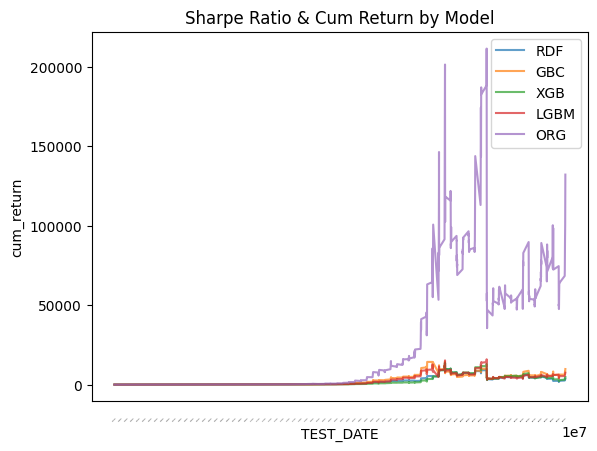

In [141]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_static, GBC_F_CUM_RETURN_static, XGB_F_CUM_RETURN_static, LGBM_F_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7061  최종 누적 수익률 : 5280.553050128134
GBC Sharpe Ratio : 0.7213  최종 누적 수익률 : 5214.293349387563
XGB Sharpe Ratio : 0.7144  최종 누적 수익률 : 5131.078588906837
LGBM Sharpe Ratio : 0.7467  최종 누적 수익률 : 5481.848045753709


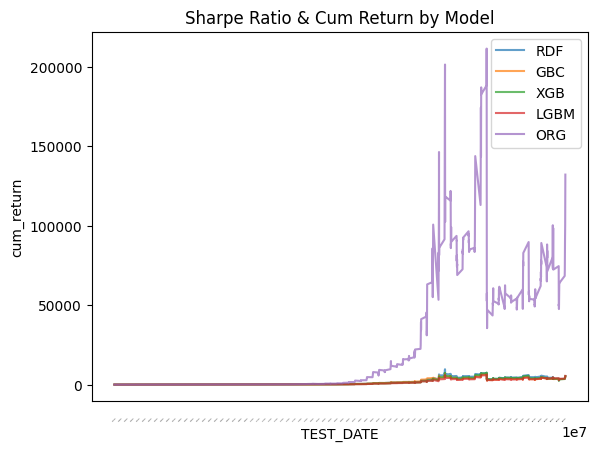

In [142]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_dynamic, GBC_F_CUM_RETURN_dynamic, XGB_F_CUM_RETURN_dynamic, LGBM_F_CUM_RETURN_dynamic],
                     dynamic=True)

### Rolling Expanding Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.5999  최종 누적 수익률 : 2874.4632781816213
GBC Sharpe Ratio : 0.7468  최종 누적 수익률 : 102732.70679285932
XGB Sharpe Ratio : 0.7136  최종 누적 수익률 : 25289.857311512995
LGBM Sharpe Ratio : 0.7141  최종 누적 수익률 : 36928.14191682155


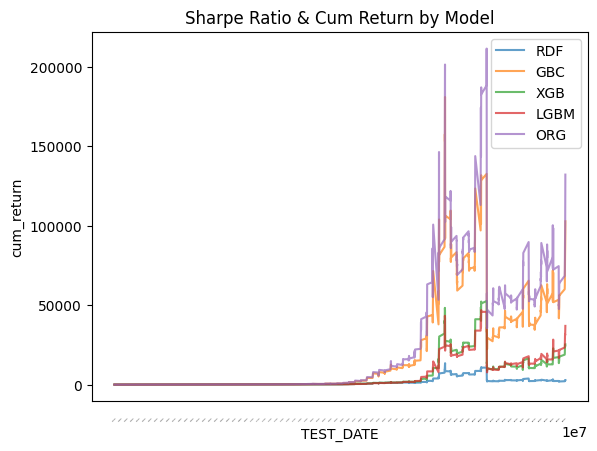

In [143]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_static, GBC_E_CUM_RETURN_static, XGB_E_CUM_RETURN_static, LGBM_E_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6855  최종 누적 수익률 : 5332.517172248374
GBC Sharpe Ratio : 0.7253  최종 누적 수익률 : 4883.904173694783
XGB Sharpe Ratio : 0.7185  최종 누적 수익률 : 5630.014950970668
LGBM Sharpe Ratio : 0.7469  최종 누적 수익률 : 6940.353341865584


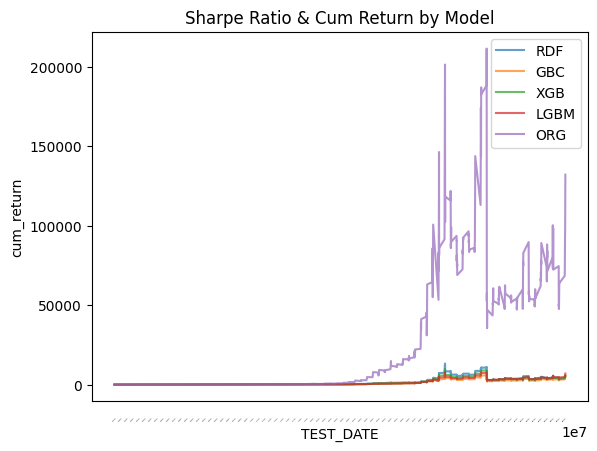

In [144]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_dynamic, GBC_E_CUM_RETURN_dynamic, XGB_E_CUM_RETURN_dynamic, LGBM_E_CUM_RETURN_dynamic],
                     dynamic=True)